# Enable Inline Display in Jupyter
For displaying plots inline in the notebook, enable inline plotting

In [1]:
%matplotlib inline

# Preliminary settings

Libraries imported.

TensorFlow, Keras, and other relevant libraries for building the image captioning model.

In [2]:
import os
import re
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization

from datetime import datetime
seed = int(round(datetime.now().timestamp()))
np.random.seed(seed)
tf.random.set_seed(seed)

Path to data.

In [3]:
dx = "/data/train/rxxch9vw59.2/"

Important constants.

In [4]:
# Path to the images
IMAGES_PATH = dx+"images"

# Desired image dimensions
# IMAGE_SIZE = (224, 224)
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 6000
# later to be updated to VOCAB_SIZE = len(filtered_words) + 2

# Fixed length allowed for any sequence
# SEQ_LENGTH = 8
SEQ_LENGTH = 10
# SEQ_LENGTH = 12

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 256
# EMBED_DIM = 512
# EMBED_DIM = 768

# Per-layer units in the feed-forward network
FF_DIM = 256
# FF_DIM = 1024
# FF_DIM = 2048

# Other training parameters
BATCH_SIZE = 25
# BATCH_SIZE = 64

# EPOCHS = 20
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

# Dataset creation

The image files are loaded. Each image is paired with two captions.
The pairs are shuffled and split into 20% test and 80% train set.

* Loading caption data from JSON.
* Mapping captions to images and splitting the data into training and validation sets.

In [5]:
def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """
    with open(filename, encoding="utf8") as caption_file:
        caption_data = json.load(caption_file)
        caption_mapping = {}
        text_data = []

        for item in caption_data:  # Iterate over the list of dictionaries
            img_name = os.path.join(IMAGES_PATH, item['filename'].strip())  # Access 'filename'
            caption_mapping[img_name] = ["<start> " + caption.strip() + " <end>" for caption in item['caption']]  # Access 'caption'
            text_data.extend(caption_mapping[img_name])

        return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Training and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset
captions_mapping, text_data = load_captions_data(dx + "captions.json")

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  7323
Number of validation samples:  1831


# Analyze Word Frequency Distribution
* After tokenizing the dataset, count the frequency of each word. This can be done using libraries like `collections.Counter`
* Plot a word frequency distribution to visualize how many words appear frequently and how many appear only a few times (the latter are often noise).

In [6]:
# Import necessary libraries
from collections import Counter
import json
import matplotlib.pyplot as plt

# Load the captions data from the file
captions_path = dx + "captions.json"
with open(captions_path, 'r', encoding='utf-8') as f:
    captions_data = json.load(f)

# Flatten all captions into a single list
captions = []
for item in captions_data:
    captions.extend(item['caption'])

# Tokenize the captions by splitting on spaces
all_words = ' '.join(captions).split()

# Count the frequency of each word
word_freq = Counter(all_words)

# Visualize the word frequency distribution
plt.figure(figsize=(10,6))
plt.hist(list(word_freq.values()), bins=50)
plt.yscale('log')
plt.title('Word Frequency Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Save the visualization as an image
visualization_path = '/results/' + "word_frequency_distribution.png"
plt.savefig(visualization_path)
plt.close()
print(f"Visualization saved at {visualization_path}")

# Save word frequencies to a CSV file
csv_path = '/results/' + "word_frequencies.csv"
with open(csv_path, 'w', encoding='utf-8') as f:
    f.write("Word,Frequency\n")
    for word, freq in sorted(word_freq.items(), key=lambda item: item[1], reverse=True):
        f.write(f"{word},{freq}\n")
print(f"Word frequencies saved at {csv_path}")

# Show the 10 most common words for reference
print("Top 10 most common words:", word_freq.most_common(10))

# Tokenize captions for sequence length analysis
tokenized_captions = [caption.split() for caption in captions]
seq_lengths = [len(tokens) for tokens in tokenized_captions]

# Analyze length statistics
max_seq_length = max(seq_lengths)
mean_seq_length = int(np.mean(seq_lengths))
seq_length_95th = int(np.percentile(seq_lengths, 95))
seq_length_99th = int(np.percentile(seq_lengths, 99))
print(f"Max Sequence Length: {max_seq_length}")
print(f"Mean Sequence Length: {mean_seq_length}")
print(f"95th Percentile Sequence Length: {seq_length_95th}")
print(f"99th Percentile Sequence Length: {seq_length_99th}")

# Dynamically set SEQ_LENGTH based on 99th percentile
# SEQ_LENGTH = seq_length_99th
# print(f"Adjusted SEQ_LENGTH: {SEQ_LENGTH}")

Visualization saved at /results/word_frequency_distribution.png
Word frequencies saved at /results/word_frequencies.csv
Top 10 most common words: [('আছে।', 9264), ('একজন', 8775), ('একটি', 6006), ('পুরুষ', 4564), ('মানুষ', 4091), ('দাড়িয়ে', 3489), ('বসে', 3379), ('ও', 2350), ('দিয়ে', 2223), ('জন', 2201)]
Max Sequence Length: 38
Mean Sequence Length: 8
95th Percentile Sequence Length: 17
99th Percentile Sequence Length: 22


# Inspect Rare Tokens
* Review the least frequent tokens to ensure they're relevant

In [7]:
rare_tokens = [word for word, freq in word_freq.items() if freq == 1]
print(f"Rare tokens ({len(rare_tokens)}):", rare_tokens[:10])


Rare tokens (2840): ['পিটানোর', 'ঘুরানো,', 'গুলোর', 'ঢুল', 'অফ', 'হুয়াট', 'প্রনে', 'ঝার', 'বসতি', 'বানিয়ে,']


# Set a Minimum Word Frequency Threshold
* Set a threshold to eliminate words that appear too infrequently (e.g., words appearing less than 2 times). These words don’t contribute much to the model and might be considered noise.

In [8]:
# Token frequency adjustment for balanced coverage
rare_threshold = 2  # Minimum count for inclusion
frequent_threshold = float('inf')  # No upper limit on frequency
filtered_words = {word: freq for word, freq in word_freq.items()
                  if rare_threshold <= freq <= frequent_threshold}

# Check how many words have left after filtering
print(f"Number of filtered words: {len(filtered_words)}")

Number of filtered words: 3136


# Review and Fine-Tune the Vocabulary Size
* Based on the frequency analysis, adjust the `VOCAB_SIZE` parameter to ensure it matches the number of words that appear frequently.

In [9]:
# Determine the vocabulary size with a buffer for special tokens
VOCAB_SIZE = len(filtered_words) + 2 # Adding 2 for `""` and `[UNK]`
print(f"Balanced Vocabulary Size: {VOCAB_SIZE}")

Balanced Vocabulary Size: 3138


In [10]:
text_data[:3]

['<start> তিন জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর দুই জন বসে আছে। <end>',
 '<start> একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে একটি বেত নিয়ে পিটানোর ভাব দেখাচ্ছে আর ছোট একটি মেয়ে পিছনে ব্যাগ নিয়ে বসে কাঁদছে। <end>',
 '<start> অনেক মেয়ে মানুষ বসে আছে। <end>']

The captions are vectorised

# Update the Vocabulary
* Use the filtered frequent words as the vocabulary when building the `TextVectorization` layer.

In [11]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

# List of words to include in the final vocabulary
final_vocab = list(filtered_words.keys())
print(f"Final Vocabulary Length: {len(final_vocab)}")

# Initialize the TextVectorization layer with the final vocabulary
vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.set_vocabulary(final_vocab)

# Adapting the vectorization layer
# vectorization.adapt(text_data)

# Save the vocabulary to a JSON file after training
vocab = vectorization.get_vocabulary()
with open('/results/vocab.json', 'w', encoding='utf-8') as f:
    json.dump(vocab, f, ensure_ascii=False, indent=4)
print(f"Vocabulary saved with {len(vocab)} tokens.")


Final Vocabulary Length: 3136


2024-12-17 10:38:01.557471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-17 10:38:01.679733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-17 10:38:01.680322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-17 10:38:01.682305: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Vocabulary saved with 3138 tokens.


Image augmentation is performed

Image augmentation using Keras' `Sequential` API.

In [12]:
# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1), # Reduced rotation for faster preprocessing
        layers.RandomContrast(0.2), # Lighter contrast adjustment
        # layers.RandomTranslation(0.1, 0.1),
    ]
)


# Verify Vocabulary Coverage
* Check the coverage of the final vocabulary on the captions dataset to ensure that important words are not being filtered out.

In [13]:
covered = sum(word_freq[word] for word in final_vocab)
total = sum(word_freq.values())
print(f"Coverage: {covered / total * 100:.2f}%")

Coverage: 98.17%


A function to expand the dataset such that each image is paired with each caption separately.

In [14]:
def flatten_dataset(caption_mapping):
    """Flattens the dataset by creating separate (image, caption) pairs for each caption of an image.

    Args:
        caption_mapping: Dictionary mapping image names to a list of captions.

    Returns:
        images: List of image paths (repeated for each caption).
        captions: List of corresponding captions (each caption as a string).
    """
    images = []
    captions = []

    # For each image, repeat the image path for each caption and append to the lists
    for img_path, caption_list in caption_mapping.items():
        for caption in caption_list:
            images.append(img_path)
            captions.append(caption)

    return images, captions


The train and test datasets are created using TensorFlow Dataset.

# Creating TensorFlow Datasets
* Images and captions are processed into TensorFlow datasets using the `tf.data.Dataset` API.

## Group Captions by Image

The `group_captions_by_image` function organizes multiple captions for each image into a list. This ensures the dataset aligns with the expected model input shape.

## Caption Padding or Truncation

To maintain consistent input shapes, captions are padded (with `<pad>` tokens) or truncated to match `NUM_CAPTIONS_PER_IMAGE`.

## Vectorization

Captions are vectorized in grouped form (e.g., a batch shape of `[batch_size, num_captions_per_image, SEQ_LENGTH]`).

## TensorFlow Dataset Mapping

The dataset maps images and grouped captions to the desired processed format.

## Dataset Batching

The dataset batches are formed after grouping captions and images.

In [15]:
from collections import defaultdict
from PIL import Image
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Constants
# Number of captions per image to use
NUM_CAPTIONS_PER_IMAGE = 2

# Suppress PNG warnings using PIL
def preprocess_image(image_path):
    """Preprocess image to suppress warnings."""
    try:
        with Image.open(image_path) as img:
            img = img.convert("RGB")  # Strip unnecessary metadata
            img.save(image_path, "PNG", icc_profile=None)
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Decode, resize, and preprocess images
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, caption):
    img = decode_and_resize(img_path)
    
    # Vectorize the caption
    captions_vectorized = vectorization(caption)
    
    return img, captions_vectorized

# Function to group captions by image
# Group captions by image
def group_captions_by_image(images, captions):
    grouped_data = defaultdict(list)
    for img, cap in zip(images, captions):
        grouped_data[img].append(cap)

    grouped_images = []
    grouped_captions = []

    for img, caps in grouped_data.items():
        grouped_images.append(img)
        grouped_captions.append(
            caps[:NUM_CAPTIONS_PER_IMAGE] + ["<pad>"] * (NUM_CAPTIONS_PER_IMAGE - len(caps))
        )

    print(f"Grouped {len(grouped_images)} images with captions.")
    return grouped_images, grouped_captions

# Process images and captions
def process_input(img_path, captions):
    img = decode_and_resize(img_path)
    captions_vectorized = vectorization(captions)
    captions_padded = pad_sequences(captions_vectorized, maxlen=SEQ_LENGTH, padding="post")
    return img, captions_padded

# Function for dataset creation
# Create a TensorFlow Dataset
def make_dataset(images, captions, num_captions_per_image):
    # Group captions by image
    grouped_images, grouped_captions = group_captions_by_image(images, captions)

    # Ensure all groups have a consistent number of captions (pad/truncate)
    padded_captions = [
        caps[:num_captions_per_image] + ["<pad>"] * (num_captions_per_image - len(caps))
        if len(caps) < num_captions_per_image else caps[:num_captions_per_image]
        for caps in grouped_captions
    ]

    # Create a TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((grouped_images, padded_captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)

    # Map images and captions to processed inputs
    dataset = dataset.map(
        lambda img, caps: (decode_and_resize(img), vectorization(caps)),
        num_parallel_calls=AUTOTUNE
    )

    for img, cap in dataset.take(1):
        print(f"Image and grouped caption shape: {img.shape, cap.shape} \n")

    # Batch and prefetch the dataset
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# def make_dataset(images, captions):
#     print([len(i) for i in images[:5]])
#     print([len(i) for i in captions[:5]])

# Dataset Preparation
# Flatten the training data and create datasets
train_images, train_captions = flatten_dataset(train_data)
valid_images, valid_captions = flatten_dataset(valid_data)

# Pass the list of images and the list of corresponding captions
# Create train and validation datasets
print("Creating training dataset... \n")
train_dataset = make_dataset(train_images, train_captions, NUM_CAPTIONS_PER_IMAGE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print("Creating validation dataset... \n")
valid_dataset = make_dataset(valid_images, valid_captions, NUM_CAPTIONS_PER_IMAGE)

# Print the shapes of the datasets
# Debugging shapes
for img_batch, cap_batch in train_dataset.take(1):
    print(f"Training batch image shape: {img_batch.shape}, Caption shape: {cap_batch.shape}")
for img_batch, cap_batch in valid_dataset.take(1):
    print(f"Validation batch image shape: {img_batch.shape}, Caption shape: {cap_batch.shape}")

Creating training dataset... 

Grouped 7323 images with captions.
Image and grouped caption shape: (TensorShape([299, 299, 3]), TensorShape([2, 10])) 

Creating validation dataset... 

Grouped 1831 images with captions.
Image and grouped caption shape: (TensorShape([299, 299, 3]), TensorShape([2, 10])) 



2024-12-17 10:38:05.032569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Training batch image shape: (25, 299, 299, 3), Caption shape: (25, 2, 10)


2024-12-17 10:38:05.786184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Validation batch image shape: (25, 299, 299, 3), Caption shape: (25, 2, 10)


# Dataset Statistics
* A helper function to compute and display statistics about the dataset.

In [16]:
def compute_dataset_statistics(captions):
    """Print statistics for the caption dataset."""
    caption_lengths = [len(cap.split()) for cap in captions]
    print(f"Total Captions: {len(captions)}")
    print(f"Max Caption Length: {max(caption_lengths)}")
    print(f"Min Caption Length: {min(caption_lengths)}")
    print(f"Mean Caption Length: {sum(caption_lengths) / len(caption_lengths):.2f}")

# Compute statistics
print("Training Dataset Statistics:")
compute_dataset_statistics(train_captions)

print("Validation Dataset Statistics:")
compute_dataset_statistics(valid_captions)


Training Dataset Statistics:
Total Captions: 14646
Max Caption Length: 37
Min Caption Length: 4
Mean Caption Length: 10.46
Validation Dataset Statistics:
Total Captions: 3662
Max Caption Length: 40
Min Caption Length: 4
Mean Caption Length: 10.55


# Transformer model creation

The Transformer uses the EfficientNetB0 CNN.
The Encoder and Decoder block and Positional Embedding layer is seperately created by inheriting the Layer class.
The Transformer model is created by compiling the layers and inheriting the Model class.

# Model Creation
* EfficientNetB0 as the feature extractor for image embeddings.
* Custom layers for Transformer-based encoder and decoder blocks.
* Positional embedding is used to encode positional information for the sequences.

# Training the Model
* Loss and accuracy are tracked across each training step.
* Gradient updates are performed via `tf.GradientTape`.

In [17]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    
    # Reduce the sequence length using a pooling operation
    # Usign GlobalAveragePooling2D to reduce the spatial dimensions
    base_model_out = layers.GlobalAveragePooling2D()(base_model_out)
    
    # Optionally, project the output to match the embedding size
    base_model_out = layers.Dense(EMBED_DIM)(base_model_out)
    
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    
    # Print CNN Model Summary
    # print("\nCNN Model Summary:")
    # cnn_model.summary()
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0 # previously 0.1
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        # Input shape
        # print(f"Encoder Input Shape: {inputs.shape}")

        # print(f"Encoder Input Shape before LayerNorm: {inputs.shape}")
        inputs = self.layernorm_1(inputs)
        # print(f"Encoder Input Shape after LayerNorm: {inputs.shape}")
        
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        
        out_1 = self.layernorm_2(inputs + attention_output_1)

        # Output shape
        # print(f"Encoder Output Shape: {out_1.shape}")
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        # print(f"Positional Embedding Input Shape: {inputs.shape}")
        
        # Get input shape and positions
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        
        # Embed tokens and positions
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale # Apply scaling
        embedded_positions = self.position_embeddings(positions)
        
        # Embeddings shape
        # print(f"Positional Embedding Output Shape: {embedded_tokens.shape}")
        # print(f"embedded_tokens dtype: {embedded_tokens.dtype}")
        # print(f"embedded_positions dtype: {embedded_positions.dtype}")
        
        # Return combined embeddings
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        
        # Attention layers
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        # Feed-forward layers
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        # Layer normalizations
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        # Output layers
        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        # Dropout layers
        self.dropout_1 = layers.Dropout(0.3) # previously 0.1
        self.dropout_2 = layers.Dropout(0.5) # previously 0.1
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        """
        Args:
            inputs: Tokenized inputs to the decoder (batch_size, sequence_length).
            encoder_outputs: Outputs from the encoder (batch_size, seq_len, embed_dim).
            training: Boolean indicating whether it's training or inference.
            mask: Mask for padded tokens (batch_size, sequence_length).
        
        Returns:
            preds: Decoder output predictions (batch_size, seq_len, vocab_size).
        """
        # print(f"Decoder Input Shape: {inputs.shape}")
        
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        # Self-attention
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        # Cross-attention with encoder outputs
        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        # Feed-forward network
        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        
        # print(f"Decoder Output Shape: {preds.shape}")
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=2, image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        # print(f"Image Embedding Input Shape before passing to Encoder: {img_embed.shape}")
        
        # batch_seq = tf.expand_dims(batch_seq, axis=1)
        # print(f"Batch Sequence Input Shape before slicing: {batch_seq.shape}")
        
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1] # Input sequence (without the last token)

        # print(f"Batch Sequence Input Shape before target sequence: {batch_seq_inp.shape}")
        
        batch_seq_true = batch_seq[:, 1:] # Target sequence (without the first token)
        mask = tf.math.not_equal(batch_seq_true, 0)
        
        # print(f"Batch Sequence Input Shape: {batch_seq_inp.shape}")
        # print(f"Batch Sequence True Shape: {batch_seq_true.shape}")
        
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )

        # print(f"Batch Sequence Predicted Shape: {batch_seq_pred.shape}")
        
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data

        # batch_seq = tf.expand_dims(batch_seq, axis=1)

        # print(f"Training Image Batch Shape before passing to CNN: {batch_img.shape}")
        total_loss = 0
        total_acc = 0
    
        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # print(f"Training Image Batch Shape: {batch_img.shape}")
        # print(f"Training Sequence Batch Shape: {batch_seq.shape}")
        
        # 1. Get image embeddings from CNN
        img_embed = self.cnn_model(batch_img)
        # print(f"Image Embeddings Shape: {img_embed.shape}")

        # 2. Reshape CNN output to (batch_size, 1, embedding_dim)
        img_embed = tf.expand_dims(img_embed, axis=1)  # It should be (None, 1, 1024)

        # print(f"Reshaped Image Embeddings for Encoder: {img_embed.shape}")
        
        # 3. Make sure batch_seq has 3 dimensions
        if batch_seq.shape.ndims == 2:
            # Reshape the sequence to have a third dimension (e.g., 1 caption per image)
            batch_seq = tf.expand_dims(batch_seq, axis=1)
        
        # print(f"Updated Sequence Shape: {batch_seq.shape}")

        # 4. Accumulate loss and accuracy for each caption
        with tf.GradientTape() as tape:
            # Loop through each caption (batch_seq should be (batch_size, num_captions, sequence_length))
            num_captions_per_image = batch_seq.shape[1] # Extract the num_captions dimension
            
            for i in range(self.num_captions_per_image):
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )
                total_loss += loss
                total_acc += acc

            # 5. Compute the mean loss and accuracy
            avg_loss = total_loss / tf.cast(self.num_captions_per_image, dtype=tf.float32)
            avg_acc = total_acc / tf.cast(self.num_captions_per_image, dtype=tf.float32)

        # Backpropagation
        # 6. Get the list of all the trainable weights
        train_vars = self.encoder.trainable_variables + self.decoder.trainable_variables
        
        # 7. Get the gradients (from the accumulated loss)
        grads = tape.gradient(avg_loss, train_vars)
    
        # 8. Update the trainable weights
        self.optimizer.apply_gradients(zip(grads, train_vars))
    
        # 11. Update the trackers
        self.loss_tracker.update_state(avg_loss)
        self.acc_tracker.update_state(avg_acc)
    
        # 12. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        # print(f"Validation Image Batch Shape: {batch_img.shape}")
        # print(f"Validation Sequence Batch Shape: {batch_seq.shape}")

        # batch_seq = tf.expand_dims(batch_seq, axis=1)

        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)
        # print(f"Image Embeddings Shape: {img_embed.shape}")
        img_embed = tf.expand_dims(img_embed, axis=1)
        # print(f"Reshaped Image Embeddings Shape: {img_embed.shape}")

        # 2. Pass each of the captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        # Loop through captions
        for i in range(self.num_captions_per_image):
            batch_seq_inp = batch_seq[:, i, :-1]
            batch_seq_true = batch_seq[:, i, 1:]
            # print(f"Validation Sequence Input Shape: {batch_seq_inp.shape}")
            # print(f"Validation Sequence True Shape: {batch_seq_true.shape}")
        
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

16719872/16705208 [==============================] - 3s 0us/step


The loss function and early stopping is defined. The model is compiled with the same.

# Early Stopping and Loss Function
* Early stopping is implemented to prevent overfitting.
* Loss function is sparse categorical cross-entropy.

In [18]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

In [19]:
# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        # Cast variables to float32
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        
        # Calculate warmup progress
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        
        # Return the appropriate learning rate based on the current step
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

In [20]:
# # Learning Rate Scheduler using Exponential Decay
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,  # Initial learning rate
#     decay_steps=1000,            # Decay after 1000 steps
#     decay_rate=0.95,             # Reduce learning rate by 5% after each decay step
#     staircase=True               # Apply decay in discrete steps
# )

# # Learning Rate Scheduler using Exponential Decay
# initial_learning_rate = 1e-4
# decay_steps = 586  # Approximately 2 epochs worth of steps
# decay_rate = 0.96  # Slower decay for gradual adjustment

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=initial_learning_rate,
#     decay_steps=decay_steps,
#     decay_rate=decay_rate,
# )

# # Define the optimizer
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# # Compile the model
# caption_model.compile(
#     optimizer=optimizer,
#     loss=cross_entropy
# )


In [21]:
# Take a single batch from the validation dataset
for img_batch, cap_batch in valid_dataset.take(1):
    print(f"Validation batch image shape: {img_batch.shape}, Caption shape: {cap_batch.shape}")
    caption_model.test_step((img_batch, cap_batch))


2024-12-17 10:38:13.461557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:13.592150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Validation batch image shape: (25, 299, 299, 3), Caption shape: (25, 2, 10)


2024-12-17 10:38:14.444865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:17.729334: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2024-12-17 10:38:20.077115: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-17 10:38:20.080762: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-17 10:38:20.080866: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-12-17 10:38:20.082136: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-17 10:38:20.082375: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize pt

# Model training and testing

Sets the version and checks if the model has been previously trained or being trained for the first time. If saved weights are found, they're loaded.

In [22]:
mdx = '231005'  # Sets the version
tmpx = f'/results/Model_weights/{mdx}/Temp/'

# Check if the directory exists
if not os.path.exists(tmpx):
    print(f"Directory {tmpx} does not exist. Creating the directory.")
    os.makedirs(tmpx)  # Create the directory if it doesn't exist

# Now check for the files
try:
    weight_path = f'{tmpx}imgcap_{mdx}'
    fls = os.listdir(tmpx)

    # Look for specific weight files (like .index or .data-00000-of-00001)
    checkpoint_files = [f for f in fls if "imgcap_" in f]
    
    if len(checkpoint_files) > 0:
        print("Found saved weights, loading them now...")
        caption_model.load_weights(weight_path)
        print("Saved weights loaded successfully")
    else:
        print("No saved weights found, training from scratch")
except FileNotFoundError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Directory /results/Model_weights/231005/Temp/ does not exist. Creating the directory.
No saved weights found, training from scratch


Lookup dictionary created and output sequence length is set.

In [23]:
# Load the vocabulary during inference
with open('/results/vocab.json', 'r', encoding='utf-8') as f:
    vocab = json.load(f)

# Recreate the vectorization object and set its vocabulary
vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)

# Set the vocabulary during inference
vectorization.set_vocabulary(vocab)

print(f"Vocabulary loaded with {len(vocab)} tokens.")

index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())

Vocabulary loaded with 3138 tokens.


# Save Images Selectively and Limit Display
Saves only a subset of images and captions to a designated directory.
* Avoids memory issues by clearing figures after saving.
* Displays only a few images inline (e.g., the first 5).
* Allows to view the rest of the generated images in a lightweight HTML report.

In [24]:
import os
import gc
from matplotlib import pyplot as plt
from IPython.display import display, HTML

# Output directories
output_dir = "/results/generated_captions/"
html_report_path = "/results/generated_captions_report.html"
os.makedirs(output_dir, exist_ok=True)

# Initialize HTML content for the report
html_content = "<html><body><h1>Generated Captions</h1>"

# Subset limit for inline display
display_count = 5
save_count = 20  # Max number of images to save

The function reads an image from the given path. It uses the image to generate an caption. The same are displayed.

In [25]:
# Handle invalid token indices
def generate_caption(dt, ix, save_dir=None, save_idx=None, display_count=None, display_counter=[0]):
    """
    Generate a caption for a given image using a fixed SEQ_LENGTH.

    Args:
    - dt (str): Path to the dataset directory.
    - ix (str): Image filename.
    - save_dir (str, optional): Directory to save the image and caption. Default is None.
    - save_idx (str, optional): Identifier to append to the saved file. Default is None.
    - display_count (int, optional): Number of images to display. Default is None.
    - display_counter (list): A mutable counter for tracking displays. Default is [0].

    Returns:
    - str: Generated caption.
    """
    
    # Select and read the image
    # Select a random image from the validation dataset
    sample_img = f'{dt}images/{ix}'

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.axis('off')

    # Display logic: Show only up to 'display_count' images
    if display_count is None or display_counter[0] < display_count:
        plt.imshow(img)
        plt.title("Generated Image")
        plt.show()
        display_counter[0] += 1
    plt.close()
    
    # Pass the image to the CNN
    img_tensor = tf.expand_dims(sample_img, 0)
    img_features = caption_model.cnn_model(img_tensor)

    # Expand dimensions to make it compatible with the encoder
    img_features = tf.expand_dims(img_features, 1)  # Adding sequence dimension, shape becomes (batch_size, 1, embed_dim)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img_features, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        # Ensure decoded_caption is passed as a list of strings
        tokenized_caption = vectorization(tf.constant([decoded_caption]))[:, :-1]
        
        # Create mask for the tokenized caption
        mask = tf.math.not_equal(tokenized_caption, 0)

        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )

        # Get the predicted token
        sampled_token_index = np.argmax(predictions[0, i, :])

        # Check if sampled_token_index is in the vocabulary range
        if sampled_token_index >= len(vocab):
            print(f"Warning: Token index {sampled_token_index} out of range")
            continue  # Skip to the next iteration if the token is out of range

        sampled_token = index_lookup[sampled_token_index]

        if sampled_token == "[UNK]":
            continue  # Skip unknown tokens

        # Handle noisy or unknown tokens
        if sampled_token in ("[UNK]", ""):
            print(f"Warning: Encountered noisy token '{sampled_token}'. Skipping.")
            continue  # Skip this token

        if sampled_token == "<end>":
            break

        decoded_caption += " " + sampled_token

    # Clean up the decoded caption
    decoded_caption = (
        decoded_caption.replace("<start> ", "")
        .replace(" <end>", "")
        .replace("[UNK]", "")
        .strip()
    )

    print("\nPredicted Caption: ", decoded_caption)
    
    # Conditional save or display
    if save_dir and save_idx:
        save_path = os.path.join(save_dir, f"image_{save_idx}.png")
        plt.imsave(save_path, img)
        plt.close()
        
        # Generate HTML
        global html_content
        html_content += f"<div><h3>Image {save_idx}: {decoded_caption}</h3>"
        html_content += f'<img src="{save_path}" width="300"></div>'
        gc.collect()  # Free up memory
    return decoded_caption


In [26]:
# # Handle invalid token indices
# def generate_caption(dt, ix):
#     # Select a random image from the validation dataset
#     sample_img = f'{dt}images/{ix}'

#     # Read the image from the disk
#     sample_img = decode_and_resize(sample_img)
#     img = sample_img.numpy().clip(0, 255).astype(np.uint8)
#     plt.axis('off')
#     plt.imshow(img)
#     plt.show()
#     plt.close()
    
#     # Pass the image to the CNN
#     img = tf.expand_dims(sample_img, 0)
#     img = caption_model.cnn_model(img)

#     # Expand dimensions to make it compatible with the encoder
#     img = tf.expand_dims(img, 1)  # Adding sequence dimension, shape becomes (batch_size, 1, embed_dim)

#     # Pass the image features to the Transformer encoder
#     encoded_img = caption_model.encoder(img, training=False)

#     # Generate the caption using the Transformer decoder with beam search
#     decoded_caption = beam_search_decoder(encoded_img)

#     # Clean up the decoded caption
#     decoded_caption = (
#         decoded_caption.replace("<start> ", "")
#         .replace(" <end>", "")
#         .replace("[UNK]", "")
#         .strip()
#     )
#     print("\nPredicted Caption: ", decoded_caption)
#     print()

# def beam_search_decoder(encoded_img, beam_width=3):
#     sequences = [["<start>", 1.0]]  # Initialize sequences with the start token and a score of 1.0
#     for _ in range(max_decoded_sentence_length):
#         all_candidates = []
#         for seq, score in sequences:
#             # Tokenize the current sequence
#             tokenized_caption = vectorization(tf.constant([seq]))[:, :-1]
            
#             # Create mask for the tokenized caption
#             mask = tf.math.not_equal(tokenized_caption, 0)

#             # Get predictions from the decoder
#             predictions = caption_model.decoder(
#                 tokenized_caption, encoded_img, training=False, mask=mask
#             )

#             # Select top beam_width tokens
#             top_indices = tf.math.top_k(predictions[0, -1, :], k=beam_width).indices.numpy()
#             top_scores = tf.math.top_k(predictions[0, -1, :], k=beam_width).values.numpy()

#             # Expand each current sequence with the top tokens
#             for i, token_index in enumerate(top_indices):
#                 if token_index >= len(vocab):
#                     continue  # Skip out-of-range tokens
#                 token = index_lookup[token_index]
#                 candidate = (
#                     seq + " " + token,
#                     score * top_scores[i],  # Update score
#                 )
#                 all_candidates.append(candidate)

#         # Sort candidates by score and select the top beam_width sequences
#         ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
#         sequences = ordered[:beam_width]

#         # Stop if all sequences end with the end token
#         if all(seq[-1] == "<end>" for seq, _ in sequences):
#             break

#     # Return the highest scoring sequence without the start/end tokens
#     return max(sequences, key=lambda tup: tup[1])[0].replace("<start> ", "").replace(" <end>", "").strip()


The model is trained.

Epoch 1/30


2024-12-17 10:38:34.101252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:34.128593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:34.153183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:34.393342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:34.720821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:35.034160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:35.179986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:35.210969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:01 - loss: 8.1612 - acc: 0.0000e+00 

2024-12-17 10:38:36.343007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:36.431157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 58s - loss: 8.1412 - acc: 1.5170e-04 

2024-12-17 10:38:36.744913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 57s - loss: 8.1416 - acc: 2.6336e-04

2024-12-17 10:38:37.352500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 57s - loss: 8.1436 - acc: 3.4913e-04

2024-12-17 10:38:37.966803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:38.165803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 56s - loss: 8.1447 - acc: 3.8317e-04

2024-12-17 10:38:38.366372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:38.412601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:38.455170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 56s - loss: 8.1442 - acc: 4.4037e-04

2024-12-17 10:38:38.763702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:38.764953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 55s - loss: 8.1400 - acc: 4.9669e-04

2024-12-17 10:38:39.842310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 54s - loss: 8.1404 - acc: 5.2987e-04

2024-12-17 10:38:40.185141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:40.384817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 53s - loss: 8.1380 - acc: 5.7590e-04

2024-12-17 10:38:40.982716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 52s - loss: 8.1374 - acc: 6.1407e-04

2024-12-17 10:38:41.962052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 39/293 [==>...........................] - ETA: 50s - loss: 8.1294 - acc: 6.3031e-04

2024-12-17 10:38:43.706157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:43.728380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 49s - loss: 8.1264 - acc: 6.3486e-04

2024-12-17 10:38:44.104123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 49s - loss: 8.1231 - acc: 6.3874e-04

2024-12-17 10:38:44.472008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/293 [===>..........................] - ETA: 48s - loss: 8.1186 - acc: 6.4907e-04

2024-12-17 10:38:45.024363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 47s - loss: 8.1163 - acc: 6.6265e-04

2024-12-17 10:38:45.619891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 47s - loss: 8.1165 - acc: 6.7319e-04

2024-12-17 10:38:45.957276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:46.149604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 47s - loss: 8.1158 - acc: 6.7853e-04

2024-12-17 10:38:46.164885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 46s - loss: 8.1142 - acc: 6.9992e-04

2024-12-17 10:38:46.989690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 45s - loss: 8.1114 - acc: 7.2215e-04

2024-12-17 10:38:47.549811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 45s - loss: 8.1077 - acc: 7.3891e-04

2024-12-17 10:38:47.897718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:47.909101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:47.931784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:48.090654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 44s - loss: 8.1007 - acc: 7.9232e-04

2024-12-17 10:38:48.856225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 43s - loss: 8.0982 - acc: 8.1779e-04

2024-12-17 10:38:49.244737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 10:38:49.275920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:49.288362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 43s - loss: 8.0951 - acc: 8.5746e-04

2024-12-17 10:38:49.836772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:49.879621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 43s - loss: 8.0932 - acc: 8.7071e-04

2024-12-17 10:38:50.087024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 42s - loss: 8.0896 - acc: 8.9770e-04

2024-12-17 10:38:50.425618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 42s - loss: 8.0878 - acc: 9.1234e-04

2024-12-17 10:38:50.633833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 41s - loss: 8.0812 - acc: 9.8744e-04

2024-12-17 10:38:51.394646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 41s - loss: 8.0778 - acc: 0.0010    

2024-12-17 10:38:51.748850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 41s - loss: 8.0769 - acc: 0.0011

2024-12-17 10:38:51.997390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:52.155201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 40s - loss: 8.0664 - acc: 0.0012

2024-12-17 10:38:53.163918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 39s - loss: 8.0640 - acc: 0.0012

2024-12-17 10:38:53.421304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:53.571407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 39s - loss: 8.0578 - acc: 0.0014

2024-12-17 10:38:54.076759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:54.227610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 39s - loss: 8.0556 - acc: 0.0014

2024-12-17 10:38:54.293500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 38s - loss: 8.0489 - acc: 0.0015

2024-12-17 10:38:54.770671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 38s - loss: 8.0430 - acc: 0.0017

2024-12-17 10:38:55.386520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:55.405480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 37s - loss: 8.0388 - acc: 0.0018

2024-12-17 10:38:55.789601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 37s - loss: 8.0339 - acc: 0.0019

2024-12-17 10:38:56.374672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:56.506427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 36s - loss: 8.0283 - acc: 0.0021

2024-12-17 10:38:56.893897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


111/293 [==========>...................] - ETA: 35s - loss: 8.0191 - acc: 0.0023

2024-12-17 10:38:57.652571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:57.704663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 35s - loss: 8.0150 - acc: 0.0024

2024-12-17 10:38:58.035170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 34s - loss: 8.0126 - acc: 0.0025

2024-12-17 10:38:58.267512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:58.413879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:58.419586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:58.437003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/293 [==========>...................] - ETA: 34s - loss: 8.0048 - acc: 0.0027

2024-12-17 10:38:58.813417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:38:58.824076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 34s - loss: 8.0000 - acc: 0.0028

2024-12-17 10:38:59.208456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 33s - loss: 7.9898 - acc: 0.0031

2024-12-17 10:39:00.046637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:00.202332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 32s - loss: 7.9855 - acc: 0.0033

2024-12-17 10:39:00.445486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:00.450375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:00.467758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:00.487443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:00.644776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 32s - loss: 7.9726 - acc: 0.0036

2024-12-17 10:39:01.210946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 31s - loss: 7.9695 - acc: 0.0037

2024-12-17 10:39:01.440045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:01.594740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:01.623311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 31s - loss: 7.9637 - acc: 0.0039

2024-12-17 10:39:01.782777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 30s - loss: 7.9548 - acc: 0.0042

2024-12-17 10:39:02.437897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:02.594401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:02.625401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 30s - loss: 7.9513 - acc: 0.0043

2024-12-17 10:39:02.703715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:02.825387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 30s - loss: 7.9421 - acc: 0.0046

2024-12-17 10:39:03.212891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 29s - loss: 7.9336 - acc: 0.0050

2024-12-17 10:39:03.759367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:03.787351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 29s - loss: 7.9302 - acc: 0.0051

2024-12-17 10:39:03.971125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 28s - loss: 7.9239 - acc: 0.0053

2024-12-17 10:39:04.314214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:04.322289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 28s - loss: 7.9177 - acc: 0.0056

2024-12-17 10:39:04.727377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 28s - loss: 7.9140 - acc: 0.0057

2024-12-17 10:39:05.010835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 27s - loss: 7.8984 - acc: 0.0064

2024-12-17 10:39:05.882810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 27s - loss: 7.8947 - acc: 0.0065

2024-12-17 10:39:06.093150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 26s - loss: 7.8762 - acc: 0.0073

2024-12-17 10:39:07.099977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:07.265477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 25s - loss: 7.8648 - acc: 0.0077

2024-12-17 10:39:07.644047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 24s - loss: 7.8488 - acc: 0.0083

2024-12-17 10:39:08.423657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:08.433809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 24s - loss: 7.8376 - acc: 0.0088

2024-12-17 10:39:09.076836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:09.227433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 23s - loss: 7.8250 - acc: 0.0093

2024-12-17 10:39:09.559234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:09.576996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 23s - loss: 7.8127 - acc: 0.0098

2024-12-17 10:39:10.184927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:10.377927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 22s - loss: 7.8007 - acc: 0.0103

2024-12-17 10:39:10.779482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:10.906705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 21s - loss: 7.7878 - acc: 0.0109

2024-12-17 10:39:11.299691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:11.311867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:11.332631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:11.493030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 21s - loss: 7.7789 - acc: 0.0112

2024-12-17 10:39:11.703266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:11.885734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 19s - loss: 7.7374 - acc: 0.0130

2024-12-17 10:39:13.635804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 19s - loss: 7.7327 - acc: 0.0132

2024-12-17 10:39:13.872079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 18s - loss: 7.7192 - acc: 0.0138

2024-12-17 10:39:14.419507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:14.590929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 18s - loss: 7.7107 - acc: 0.0141

2024-12-17 10:39:14.841387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:14.982107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 17s - loss: 7.6938 - acc: 0.0149

2024-12-17 10:39:15.560908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:15.623677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 17s - loss: 7.6897 - acc: 0.0151

2024-12-17 10:39:15.813927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:15.945756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 16s - loss: 7.6768 - acc: 0.0156

2024-12-17 10:39:16.347990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 16s - loss: 7.6681 - acc: 0.0160

2024-12-17 10:39:16.823718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 16s - loss: 7.6599 - acc: 0.0164

2024-12-17 10:39:17.164822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 15s - loss: 7.6517 - acc: 0.0167

2024-12-17 10:39:17.529859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:17.600037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 15s - loss: 7.6466 - acc: 0.0169

2024-12-17 10:39:17.780499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 7.6376 - acc: 0.0173

2024-12-17 10:39:18.126115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:18.178066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 14s - loss: 7.6335 - acc: 0.0175

2024-12-17 10:39:18.364384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 14s - loss: 7.6239 - acc: 0.0178

2024-12-17 10:39:18.693545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 7.6148 - acc: 0.0182

2024-12-17 10:39:19.098405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:19.275353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:19.280410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 13s - loss: 7.6099 - acc: 0.0184

2024-12-17 10:39:19.320482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:19.328551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:19.469307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:19.488729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:19.515398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 7.5909 - acc: 0.0191

2024-12-17 10:39:20.056187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:20.123932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:20.245860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 12s - loss: 7.5853 - acc: 0.0193

2024-12-17 10:39:20.310525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:20.321462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 11s - loss: 7.5570 - acc: 0.0204

2024-12-17 10:39:21.431461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 10s - loss: 7.5336 - acc: 0.0213

2024-12-17 10:39:22.378839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:22.571553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 10s - loss: 7.5241 - acc: 0.0217

2024-12-17 10:39:22.780428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 9s - loss: 7.5148 - acc: 0.0220 

2024-12-17 10:39:23.210327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:23.221106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 9s - loss: 7.5099 - acc: 0.0222

2024-12-17 10:39:23.419258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 8s - loss: 7.4867 - acc: 0.0231

2024-12-17 10:39:24.326029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 7.4581 - acc: 0.0242

2024-12-17 10:39:25.595524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:25.736437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 6s - loss: 7.4390 - acc: 0.0249

2024-12-17 10:39:26.412786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:26.428663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 7.4248 - acc: 0.0254

2024-12-17 10:39:27.046521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 5s - loss: 7.4105 - acc: 0.0259

2024-12-17 10:39:27.614933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:27.812809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 7.4018 - acc: 0.0262

2024-12-17 10:39:28.017007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 7.3878 - acc: 0.0268

2024-12-17 10:39:28.543297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:28.545466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 7.3788 - acc: 0.0271

2024-12-17 10:39:28.933710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 3s - loss: 7.3691 - acc: 0.0274

2024-12-17 10:39:29.325842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 7.3603 - acc: 0.0278

2024-12-17 10:39:29.726765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:29.812046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 7.3553 - acc: 0.0279

2024-12-17 10:39:29.997375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:30.157942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 2s - loss: 7.3449 - acc: 0.0283

2024-12-17 10:39:30.355683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 7.3356 - acc: 0.0286

2024-12-17 10:39:30.735347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:30.880220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 7.2728 - acc: 0.0307

2024-12-17 10:39:37.211546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:37.322948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:37.438562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:37.531809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:37.615081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:37.770393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:37.837807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:37.940042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:38.068803: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 86s 256ms/step - loss: 7.2728 - acc: 0.0309 - val_loss: 11.4750 - val_acc: 0.1471

Epoch 00001: val_loss improved from inf to 11.47499, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 2/30
  1/293 [..............................] - ETA: 1:25 - loss: 5.9561 - acc: 0.1359

2024-12-17 10:39:52.011639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:01 - loss: 5.7801 - acc: 0.1424

2024-12-17 10:39:52.245113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:52.445293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:02 - loss: 5.8896 - acc: 0.1401

2024-12-17 10:39:52.740717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:52.758077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:52.832333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:01 - loss: 5.8851 - acc: 0.1365

2024-12-17 10:39:53.558973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:53.587843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:01 - loss: 5.8849 - acc: 0.1363

2024-12-17 10:39:53.796129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:00 - loss: 5.8521 - acc: 0.1366

2024-12-17 10:39:54.145555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 59s - loss: 5.8472 - acc: 0.1371 

2024-12-17 10:39:54.596174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 58s - loss: 5.8562 - acc: 0.1370

2024-12-17 10:39:54.990553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:55.140666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 56s - loss: 5.8392 - acc: 0.1370

2024-12-17 10:39:55.779022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:55.924201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:55.935756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:55.940302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 55s - loss: 5.8320 - acc: 0.1373

2024-12-17 10:39:56.126823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 55s - loss: 5.8333 - acc: 0.1374

2024-12-17 10:39:56.341545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 55s - loss: 5.8221 - acc: 0.1376

2024-12-17 10:39:56.739136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 54s - loss: 5.8083 - acc: 0.1380

2024-12-17 10:39:57.530992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:57.718133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/293 [==>...........................] - ETA: 52s - loss: 5.7791 - acc: 0.1387

2024-12-17 10:39:59.100492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/293 [==>...........................] - ETA: 51s - loss: 5.7701 - acc: 0.1389

2024-12-17 10:39:59.525139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:39:59.693306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 40/293 [===>..........................] - ETA: 51s - loss: 5.7570 - acc: 0.1391

2024-12-17 10:39:59.940644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 50s - loss: 5.7418 - acc: 0.1395

2024-12-17 10:40:00.693530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:00.888317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 49s - loss: 5.7173 - acc: 0.1399

2024-12-17 10:40:01.927956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/293 [====>.........................] - ETA: 48s - loss: 5.7042 - acc: 0.1401

2024-12-17 10:40:02.470319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:02.487338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 47s - loss: 5.6981 - acc: 0.1403

2024-12-17 10:40:02.859596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 47s - loss: 5.6895 - acc: 0.1404

2024-12-17 10:40:03.224656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:03.255109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 46s - loss: 5.6801 - acc: 0.1407

2024-12-17 10:40:03.791141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 46s - loss: 5.6787 - acc: 0.1407

2024-12-17 10:40:04.029937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:04.169093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:04.188484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 45s - loss: 5.6655 - acc: 0.1410

2024-12-17 10:40:04.809664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:04.974747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 44s - loss: 5.6502 - acc: 0.1412

2024-12-17 10:40:05.359936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:05.366330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:05.540849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 70/293 [======>.......................] - ETA: 44s - loss: 5.6395 - acc: 0.1414

2024-12-17 10:40:05.782274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:05.958858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 43s - loss: 5.6315 - acc: 0.1416

2024-12-17 10:40:06.351151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 43s - loss: 5.6243 - acc: 0.1418

2024-12-17 10:40:06.774977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 42s - loss: 5.6169 - acc: 0.1420

2024-12-17 10:40:07.127594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:07.173401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 42s - loss: 5.6095 - acc: 0.1423

2024-12-17 10:40:07.688904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 41s - loss: 5.6006 - acc: 0.1424

2024-12-17 10:40:08.139943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 41s - loss: 5.5900 - acc: 0.1427

2024-12-17 10:40:08.655325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 39s - loss: 5.5670 - acc: 0.1435

2024-12-17 10:40:10.235789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 39s - loss: 5.5655 - acc: 0.1436

2024-12-17 10:40:10.548963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:10.631825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 38s - loss: 5.5499 - acc: 0.1440

2024-12-17 10:40:11.417368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 37s - loss: 5.5453 - acc: 0.1442

2024-12-17 10:40:11.764574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:11.788621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:11.793134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 37s - loss: 5.5404 - acc: 0.1443

2024-12-17 10:40:11.994094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:12.164860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 37s - loss: 5.5344 - acc: 0.1445

2024-12-17 10:40:12.363290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:12.405109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 37s - loss: 5.5316 - acc: 0.1446

2024-12-17 10:40:12.612631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 36s - loss: 5.5254 - acc: 0.1448

2024-12-17 10:40:13.008450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 36s - loss: 5.5224 - acc: 0.1450

2024-12-17 10:40:13.341243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 35s - loss: 5.5176 - acc: 0.1452

2024-12-17 10:40:13.740668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:13.774865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/293 [==========>...................] - ETA: 34s - loss: 5.5008 - acc: 0.1458

2024-12-17 10:40:14.887473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:14.996563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 34s - loss: 5.4971 - acc: 0.1460

2024-12-17 10:40:15.277657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:15.326428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 33s - loss: 5.4909 - acc: 0.1463

2024-12-17 10:40:15.873174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:15.917838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:16.067779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:16.069643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 33s - loss: 5.4832 - acc: 0.1465

2024-12-17 10:40:16.265810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:16.327626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 33s - loss: 5.4799 - acc: 0.1466

2024-12-17 10:40:16.560241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


128/293 [============>.................] - ETA: 32s - loss: 5.4730 - acc: 0.1469

2024-12-17 10:40:17.082928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:17.138902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 32s - loss: 5.4708 - acc: 0.1470

2024-12-17 10:40:17.284087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:17.481872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 31s - loss: 5.4677 - acc: 0.1472

2024-12-17 10:40:17.738983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 31s - loss: 5.4603 - acc: 0.1474

2024-12-17 10:40:18.069923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 31s - loss: 5.4574 - acc: 0.1476

2024-12-17 10:40:18.319558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:18.452419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 30s - loss: 5.4520 - acc: 0.1478

2024-12-17 10:40:18.775557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 30s - loss: 5.4484 - acc: 0.1480

2024-12-17 10:40:19.036011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:19.040960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:19.116562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 30s - loss: 5.4465 - acc: 0.1481

2024-12-17 10:40:19.299373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 29s - loss: 5.4374 - acc: 0.1484

2024-12-17 10:40:19.817035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:19.857876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 29s - loss: 5.4365 - acc: 0.1485

2024-12-17 10:40:20.058672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:20.228495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:20.229122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 28s - loss: 5.4272 - acc: 0.1489

2024-12-17 10:40:20.824786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 28s - loss: 5.4204 - acc: 0.1492

2024-12-17 10:40:21.424343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 28s - loss: 5.4170 - acc: 0.1493

2024-12-17 10:40:21.674930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 26s - loss: 5.4011 - acc: 0.1499

2024-12-17 10:40:22.812369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:22.980021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 26s - loss: 5.3973 - acc: 0.1500

2024-12-17 10:40:23.045408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 26s - loss: 5.3943 - acc: 0.1501

2024-12-17 10:40:23.292994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 25s - loss: 5.3834 - acc: 0.1506

2024-12-17 10:40:23.998431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:24.171851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 25s - loss: 5.3762 - acc: 0.1509

2024-12-17 10:40:24.599972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 24s - loss: 5.3712 - acc: 0.1512

2024-12-17 10:40:25.179064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:25.333202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:25.360528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 23s - loss: 5.3551 - acc: 0.1520

2024-12-17 10:40:26.562294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:26.700353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 22s - loss: 5.3525 - acc: 0.1522

2024-12-17 10:40:26.903111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 22s - loss: 5.3501 - acc: 0.1523

2024-12-17 10:40:27.143002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:27.298739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 5.3446 - acc: 0.1525

2024-12-17 10:40:27.540649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:27.698215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 21s - loss: 5.3372 - acc: 0.1528

2024-12-17 10:40:28.115764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 20s - loss: 5.3304 - acc: 0.1532

2024-12-17 10:40:28.682470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:28.741965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 20s - loss: 5.3273 - acc: 0.1534

2024-12-17 10:40:29.138469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 19s - loss: 5.3207 - acc: 0.1537

2024-12-17 10:40:29.737894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 19s - loss: 5.3186 - acc: 0.1540

2024-12-17 10:40:30.101500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 19s - loss: 5.3164 - acc: 0.1541

2024-12-17 10:40:30.320373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 18s - loss: 5.3131 - acc: 0.1543

2024-12-17 10:40:30.683094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 18s - loss: 5.3119 - acc: 0.1544

2024-12-17 10:40:30.950599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:31.102967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 18s - loss: 5.3089 - acc: 0.1545

2024-12-17 10:40:31.165223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 18s - loss: 5.3048 - acc: 0.1547

2024-12-17 10:40:31.521585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 16s - loss: 5.2954 - acc: 0.1554

2024-12-17 10:40:32.675567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 16s - loss: 5.2933 - acc: 0.1555

2024-12-17 10:40:32.953177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 16s - loss: 5.2905 - acc: 0.1557

2024-12-17 10:40:33.335833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:33.482661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:33.512058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 15s - loss: 5.2864 - acc: 0.1560

2024-12-17 10:40:33.694759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 15s - loss: 5.2844 - acc: 0.1561

2024-12-17 10:40:33.906065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 15s - loss: 5.2819 - acc: 0.1563

2024-12-17 10:40:34.315783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 5.2799 - acc: 0.1564

2024-12-17 10:40:34.519748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 5.2731 - acc: 0.1568

2024-12-17 10:40:35.286645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:35.427987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:35.453672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 5.2688 - acc: 0.1571

2024-12-17 10:40:35.624543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:35.814359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 13s - loss: 5.2648 - acc: 0.1573

2024-12-17 10:40:36.007203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:36.055096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:36.197019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 5.2612 - acc: 0.1575

2024-12-17 10:40:36.390117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:36.475075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 12s - loss: 5.2555 - acc: 0.1577

2024-12-17 10:40:36.873096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:37.000407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 5.2506 - acc: 0.1581

2024-12-17 10:40:37.420776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 11s - loss: 5.2480 - acc: 0.1583

2024-12-17 10:40:37.827375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:37.830778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 11s - loss: 5.2455 - acc: 0.1584

2024-12-17 10:40:38.077422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 11s - loss: 5.2437 - acc: 0.1585

2024-12-17 10:40:38.313624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 10s - loss: 5.2370 - acc: 0.1588

2024-12-17 10:40:38.846450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 10s - loss: 5.2340 - acc: 0.1591

2024-12-17 10:40:39.270233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 5.2331 - acc: 0.1592

2024-12-17 10:40:39.487566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:39.607884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 5.2266 - acc: 0.1596 

2024-12-17 10:40:40.206323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 5.2171 - acc: 0.1602

2024-12-17 10:40:41.150655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 7s - loss: 5.2106 - acc: 0.1605

2024-12-17 10:40:41.766836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:41.768160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:41.796680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 5.2078 - acc: 0.1606

2024-12-17 10:40:42.075320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:42.240895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 6s - loss: 5.2011 - acc: 0.1612

2024-12-17 10:40:43.073732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 5s - loss: 5.1953 - acc: 0.1616

2024-12-17 10:40:43.765294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:43.786237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 5.1918 - acc: 0.1618

2024-12-17 10:40:44.121390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 5.1887 - acc: 0.1620

2024-12-17 10:40:44.573969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 5.1817 - acc: 0.1624

2024-12-17 10:40:45.101332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 5.1768 - acc: 0.1626

2024-12-17 10:40:45.545947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:45.699406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:45.740232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 5.1726 - acc: 0.1628

2024-12-17 10:40:45.943926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 5.1705 - acc: 0.1630

2024-12-17 10:40:46.304832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 5.1692 - acc: 0.1631

2024-12-17 10:40:46.556718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 5.1671 - acc: 0.1633

2024-12-17 10:40:46.902829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:46.943430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/293 [===========================>..] - ETA: 2s - loss: 5.1627 - acc: 0.1637

2024-12-17 10:40:47.551795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 5.1428 - acc: 0.1648

2024-12-17 10:40:49.877196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:50.032647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:50.116042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:50.391251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:50.399234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:50.464631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:50.622978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:50.798221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:40:51.358856: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 71s 241ms/step - loss: 5.1428 - acc: 0.1649 - val_loss: 9.0788 - val_acc: 0.2606

Epoch 00002: val_loss improved from 11.47499 to 9.07876, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 3/30


2024-12-17 10:41:03.414519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:03.447390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:03.613441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:04 - loss: 4.5536 - acc: 0.2524

2024-12-17 10:41:03.993622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:04 - loss: 4.5590 - acc: 0.2520

2024-12-17 10:41:04.266739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:04.361995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:04.373466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:04 - loss: 4.6223 - acc: 0.2506

2024-12-17 10:41:04.571755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:04.590093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:03 - loss: 4.6461 - acc: 0.2496

2024-12-17 10:41:04.827687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:04.941914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:04.955641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:02 - loss: 4.6441 - acc: 0.2482

2024-12-17 10:41:05.452115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:05.555712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:05.595979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:01 - loss: 4.6565 - acc: 0.2478

2024-12-17 10:41:05.790201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:01 - loss: 4.6572 - acc: 0.2479

2024-12-17 10:41:06.303408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:06.327210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:00 - loss: 4.6313 - acc: 0.2482

2024-12-17 10:41:06.638217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 59s - loss: 4.6486 - acc: 0.2485 

2024-12-17 10:41:07.070868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 58s - loss: 4.6399 - acc: 0.2490

2024-12-17 10:41:07.659407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 57s - loss: 4.6446 - acc: 0.2492

2024-12-17 10:41:08.136668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 57s - loss: 4.6385 - acc: 0.2494

2024-12-17 10:41:08.498356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 55s - loss: 4.6152 - acc: 0.2498

2024-12-17 10:41:09.690084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 33/293 [==>...........................] - ETA: 54s - loss: 4.6270 - acc: 0.2498

2024-12-17 10:41:10.214705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 52s - loss: 4.6329 - acc: 0.2498

2024-12-17 10:41:10.997158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 52s - loss: 4.6232 - acc: 0.2498

2024-12-17 10:41:11.441042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/293 [===>..........................] - ETA: 51s - loss: 4.6183 - acc: 0.2498

2024-12-17 10:41:12.063074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 51s - loss: 4.6169 - acc: 0.2498

2024-12-17 10:41:12.446992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 50s - loss: 4.6136 - acc: 0.2499

2024-12-17 10:41:12.647767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 50s - loss: 4.6156 - acc: 0.2500

2024-12-17 10:41:13.190119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:13.205172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:13.250095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 49s - loss: 4.6115 - acc: 0.2501

2024-12-17 10:41:13.430018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/293 [====>.........................] - ETA: 48s - loss: 4.6134 - acc: 0.2503

2024-12-17 10:41:14.171142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:14.172826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 47s - loss: 4.6069 - acc: 0.2504

2024-12-17 10:41:15.176566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 47s - loss: 4.6054 - acc: 0.2505

2024-12-17 10:41:15.430278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 46s - loss: 4.6017 - acc: 0.2506

2024-12-17 10:41:15.930922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 46s - loss: 4.5988 - acc: 0.2507

2024-12-17 10:41:16.338417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:16.405410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 65/293 [=====>........................] - ETA: 46s - loss: 4.5946 - acc: 0.2507

2024-12-17 10:41:16.608910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:16.765095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 45s - loss: 4.5913 - acc: 0.2508

2024-12-17 10:41:16.928377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:17.127268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 45s - loss: 4.5889 - acc: 0.2509

2024-12-17 10:41:17.312695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 44s - loss: 4.5892 - acc: 0.2510

2024-12-17 10:41:17.687774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:17.739829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 44s - loss: 4.5877 - acc: 0.2510

2024-12-17 10:41:17.951841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 44s - loss: 4.5849 - acc: 0.2511

2024-12-17 10:41:18.295411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 43s - loss: 4.5815 - acc: 0.2512

2024-12-17 10:41:18.771580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 43s - loss: 4.5733 - acc: 0.2512

2024-12-17 10:41:19.135127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 42s - loss: 4.5707 - acc: 0.2513

2024-12-17 10:41:19.731232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:19.908575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 42s - loss: 4.5707 - acc: 0.2514

2024-12-17 10:41:19.963557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 41s - loss: 4.5681 - acc: 0.2515

2024-12-17 10:41:20.758257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 41s - loss: 4.5657 - acc: 0.2516

2024-12-17 10:41:21.024933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 41s - loss: 4.5668 - acc: 0.2517

2024-12-17 10:41:21.351624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 40s - loss: 4.5622 - acc: 0.2517

2024-12-17 10:41:21.779856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 40s - loss: 4.5596 - acc: 0.2519

2024-12-17 10:41:22.703293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 39s - loss: 4.5531 - acc: 0.2520

2024-12-17 10:41:23.414325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:23.559688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 38s - loss: 4.5493 - acc: 0.2522

2024-12-17 10:41:23.986470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 10:41:24.177695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 38s - loss: 4.5471 - acc: 0.2522

2024-12-17 10:41:24.335055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:24.524240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:24.535183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 37s - loss: 4.5396 - acc: 0.2525

2024-12-17 10:41:25.305515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:25.330828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:25.337885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:25.484638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:25.490538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:25.495733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 36s - loss: 4.5331 - acc: 0.2526

2024-12-17 10:41:25.674433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:25.721337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 36s - loss: 4.5304 - acc: 0.2526

2024-12-17 10:41:25.978595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:26.064176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 35s - loss: 4.5301 - acc: 0.2527

2024-12-17 10:41:26.298851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 35s - loss: 4.5286 - acc: 0.2528

2024-12-17 10:41:26.541028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:26.682784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 35s - loss: 4.5247 - acc: 0.2529

2024-12-17 10:41:27.099392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 34s - loss: 4.5174 - acc: 0.2532

2024-12-17 10:41:28.024611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 33s - loss: 4.5186 - acc: 0.2533

2024-12-17 10:41:28.510072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 33s - loss: 4.5124 - acc: 0.2534

2024-12-17 10:41:28.821545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:29.001938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 33s - loss: 4.5116 - acc: 0.2534

2024-12-17 10:41:29.144913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:29.220383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:29.264977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 32s - loss: 4.5087 - acc: 0.2535

2024-12-17 10:41:29.450455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 32s - loss: 4.5053 - acc: 0.2536

2024-12-17 10:41:29.684769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 31s - loss: 4.5002 - acc: 0.2538

2024-12-17 10:41:30.234787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 31s - loss: 4.5001 - acc: 0.2540

2024-12-17 10:41:31.014000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 30s - loss: 4.5008 - acc: 0.2541

2024-12-17 10:41:31.468972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:31.606986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:31.633409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 29s - loss: 4.4966 - acc: 0.2544

2024-12-17 10:41:32.384307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 29s - loss: 4.4962 - acc: 0.2544

2024-12-17 10:41:32.597016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:32.600478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:32.777007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 28s - loss: 4.4919 - acc: 0.2545

2024-12-17 10:41:32.949192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 28s - loss: 4.4888 - acc: 0.2546

2024-12-17 10:41:33.373487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 27s - loss: 4.4837 - acc: 0.2548

2024-12-17 10:41:33.971721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 27s - loss: 4.4803 - acc: 0.2550

2024-12-17 10:41:34.771449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 26s - loss: 4.4759 - acc: 0.2551

2024-12-17 10:41:35.269066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 26s - loss: 4.4684 - acc: 0.2554

2024-12-17 10:41:35.997099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 25s - loss: 4.4661 - acc: 0.2554

2024-12-17 10:41:36.232848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:36.379873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 25s - loss: 4.4643 - acc: 0.2555

2024-12-17 10:41:36.635207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 24s - loss: 4.4597 - acc: 0.2557

2024-12-17 10:41:37.218026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 24s - loss: 4.4549 - acc: 0.2558

2024-12-17 10:41:37.541538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 23s - loss: 4.4539 - acc: 0.2559

2024-12-17 10:41:37.978322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:38.152006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 22s - loss: 4.4498 - acc: 0.2562

2024-12-17 10:41:38.904835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:38.917483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:38.953109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 22s - loss: 4.4498 - acc: 0.2563

2024-12-17 10:41:39.118060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 4.4475 - acc: 0.2564

2024-12-17 10:41:39.516837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:39.708366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:39.710565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 21s - loss: 4.4443 - acc: 0.2565

2024-12-17 10:41:39.950528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 21s - loss: 4.4431 - acc: 0.2565

2024-12-17 10:41:40.272267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:40.311230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 4.4419 - acc: 0.2567

2024-12-17 10:41:40.730743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 20s - loss: 4.4399 - acc: 0.2567

2024-12-17 10:41:40.937465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:41.009844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 20s - loss: 4.4386 - acc: 0.2569

2024-12-17 10:41:41.337023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:41.387476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 20s - loss: 4.4376 - acc: 0.2570

2024-12-17 10:41:41.720875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:41.745746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 18s - loss: 4.4316 - acc: 0.2573

2024-12-17 10:41:43.124321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 4.4299 - acc: 0.2575

2024-12-17 10:41:43.720215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:43.858813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 17s - loss: 4.4264 - acc: 0.2577

2024-12-17 10:41:44.649770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 16s - loss: 4.4238 - acc: 0.2578

2024-12-17 10:41:45.060081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:45.070341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 16s - loss: 4.4237 - acc: 0.2579

2024-12-17 10:41:45.274407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:45.409816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:45.431194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:45.433832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 15s - loss: 4.4227 - acc: 0.2581

2024-12-17 10:41:46.080628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:46.195062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:46.264189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 4.4221 - acc: 0.2582

2024-12-17 10:41:46.412115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 14s - loss: 4.4213 - acc: 0.2583

2024-12-17 10:41:46.911512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:47.039483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 4.4216 - acc: 0.2584

2024-12-17 10:41:47.229496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 4.4199 - acc: 0.2585

2024-12-17 10:41:47.623065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 13s - loss: 4.4184 - acc: 0.2585

2024-12-17 10:41:48.029633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:48.030052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 4.4171 - acc: 0.2586

2024-12-17 10:41:48.427673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:48.474947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 4.4151 - acc: 0.2587

2024-12-17 10:41:48.658059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:48.840729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:48.845651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 4.4099 - acc: 0.2589

2024-12-17 10:41:49.491048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 11s - loss: 4.4088 - acc: 0.2590

2024-12-17 10:41:49.804749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 11s - loss: 4.4090 - acc: 0.2590

2024-12-17 10:41:50.012633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 4.4076 - acc: 0.2591

2024-12-17 10:41:50.616831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 10s - loss: 4.4065 - acc: 0.2592

2024-12-17 10:41:50.861296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:51.052907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 10s - loss: 4.4043 - acc: 0.2593

2024-12-17 10:41:51.174274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 9s - loss: 4.4017 - acc: 0.2595 

2024-12-17 10:41:51.968705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 4.3996 - acc: 0.2595

2024-12-17 10:41:52.479249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:52.577140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:52.589927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:52.607284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 8s - loss: 4.3948 - acc: 0.2597

2024-12-17 10:41:52.951775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 7s - loss: 4.3890 - acc: 0.2599

2024-12-17 10:41:53.788110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 4.3853 - acc: 0.2601

2024-12-17 10:41:54.644330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 4.3833 - acc: 0.2602

2024-12-17 10:41:55.164287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:55.183200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 4.3817 - acc: 0.2603

2024-12-17 10:41:55.570667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 5s - loss: 4.3816 - acc: 0.2604

2024-12-17 10:41:55.932414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:55.965035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 4.3793 - acc: 0.2605

2024-12-17 10:41:56.542399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:56.556193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 4.3724 - acc: 0.2608

2024-12-17 10:41:57.894962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 4.3705 - acc: 0.2609

2024-12-17 10:41:58.281470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:58.293067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:41:58.479896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 2s - loss: 4.3699 - acc: 0.2610

2024-12-17 10:41:58.661693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 4.3598 - acc: 0.2616

2024-12-17 10:42:01.670729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:01.826670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:01.894477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:02.011814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:02.062472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:02.102121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:02.404358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:02.630338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:02.663783: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 71s 242ms/step - loss: 4.3598 - acc: 0.2617 - val_loss: 8.0862 - val_acc: 0.3027

Epoch 00003: val_loss improved from 9.07876 to 8.08623, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 4/30


2024-12-17 10:42:15.232214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:15.257234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:15.295064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 1:24 - loss: 4.2113 - acc: 0.2895

2024-12-17 10:42:15.444275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:15.552255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:04 - loss: 4.2021 - acc: 0.2872

2024-12-17 10:42:16.101968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:16.216592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:03 - loss: 4.2182 - acc: 0.2872

2024-12-17 10:42:16.370956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:16.435318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:03 - loss: 4.1673 - acc: 0.2875

2024-12-17 10:42:16.617634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:08 - loss: 4.1604 - acc: 0.2886

2024-12-17 10:42:16.903319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:16.982907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:05 - loss: 4.1429 - acc: 0.2908

2024-12-17 10:42:17.187452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:17.199811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:04 - loss: 4.1438 - acc: 0.2915

2024-12-17 10:42:17.514215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:03 - loss: 4.1383 - acc: 0.2937

2024-12-17 10:42:18.353000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:18.363923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:18.498948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:00 - loss: 4.1497 - acc: 0.2938

2024-12-17 10:42:19.078696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 1:00 - loss: 4.1518 - acc: 0.2938

2024-12-17 10:42:19.280471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 57s - loss: 4.1317 - acc: 0.2938 

2024-12-17 10:42:20.289277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 57s - loss: 4.1262 - acc: 0.2939

2024-12-17 10:42:20.509002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 53s - loss: 4.1201 - acc: 0.2946

2024-12-17 10:42:22.796645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:22.825791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:22.829434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 51s - loss: 4.1308 - acc: 0.2946

2024-12-17 10:42:24.170365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:24.353968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/293 [===>..........................] - ETA: 50s - loss: 4.1334 - acc: 0.2945

2024-12-17 10:42:24.541012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:24.580865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 50s - loss: 4.1356 - acc: 0.2945

2024-12-17 10:42:24.908168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 49s - loss: 4.1488 - acc: 0.2944

2024-12-17 10:42:25.142548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 49s - loss: 4.1460 - acc: 0.2944

2024-12-17 10:42:25.397507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:25.582797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 49s - loss: 4.1403 - acc: 0.2944

2024-12-17 10:42:25.758341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 48s - loss: 4.1319 - acc: 0.2944

2024-12-17 10:42:26.102768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:26.130183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 47s - loss: 4.1256 - acc: 0.2945

2024-12-17 10:42:27.098927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 10:42:27.111732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 47s - loss: 4.1229 - acc: 0.2945

2024-12-17 10:42:27.302863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:27.334345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:27.483703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 46s - loss: 4.1200 - acc: 0.2946

2024-12-17 10:42:27.686392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:27.697024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 46s - loss: 4.1150 - acc: 0.2946

2024-12-17 10:42:28.067975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 45s - loss: 4.1129 - acc: 0.2946

2024-12-17 10:42:28.484978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 10:42:28.629204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:28.651728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 45s - loss: 4.1142 - acc: 0.2946

2024-12-17 10:42:28.825959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:28.867790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:28.867981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 44s - loss: 4.0990 - acc: 0.2947

2024-12-17 10:42:29.647991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 44s - loss: 4.0955 - acc: 0.2947

2024-12-17 10:42:29.859073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 43s - loss: 4.0982 - acc: 0.2948

2024-12-17 10:42:30.426441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:30.453597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 42s - loss: 4.0902 - acc: 0.2949

2024-12-17 10:42:31.419447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 42s - loss: 4.0856 - acc: 0.2949

2024-12-17 10:42:32.002917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 41s - loss: 4.0829 - acc: 0.2950

2024-12-17 10:42:32.615629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 40s - loss: 4.0855 - acc: 0.2951

2024-12-17 10:42:33.157248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:33.221416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:33.264090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 39s - loss: 4.0840 - acc: 0.2951

2024-12-17 10:42:34.188338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 38s - loss: 4.0803 - acc: 0.2952

2024-12-17 10:42:35.128837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:35.134839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 38s - loss: 4.0801 - acc: 0.2952

2024-12-17 10:42:35.500752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 10:42:35.503318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 37s - loss: 4.0776 - acc: 0.2953

2024-12-17 10:42:35.939698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:36.128050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 37s - loss: 4.0784 - acc: 0.2953

2024-12-17 10:42:36.269957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 37s - loss: 4.0788 - acc: 0.2953

2024-12-17 10:42:36.540279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 36s - loss: 4.0756 - acc: 0.2954

2024-12-17 10:42:36.921719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:37.081344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:37.120174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 36s - loss: 4.0698 - acc: 0.2955

2024-12-17 10:42:37.504641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:37.509861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 35s - loss: 4.0672 - acc: 0.2955

2024-12-17 10:42:37.748371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 35s - loss: 4.0678 - acc: 0.2955

2024-12-17 10:42:38.061396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 35s - loss: 4.0680 - acc: 0.2956

2024-12-17 10:42:38.262885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:38.264797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 34s - loss: 4.0678 - acc: 0.2956

2024-12-17 10:42:38.833480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:38.837168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:38.884974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 34s - loss: 4.0662 - acc: 0.2957

2024-12-17 10:42:39.338689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 33s - loss: 4.0612 - acc: 0.2957

2024-12-17 10:42:39.692202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 33s - loss: 4.0615 - acc: 0.2958

2024-12-17 10:42:40.251700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 33s - loss: 4.0608 - acc: 0.2958

2024-12-17 10:42:40.455063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:40.493531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 32s - loss: 4.0616 - acc: 0.2959

2024-12-17 10:42:40.679925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:40.785264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 32s - loss: 4.0612 - acc: 0.2959

2024-12-17 10:42:40.893272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 32s - loss: 4.0574 - acc: 0.2960

2024-12-17 10:42:41.293110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 32s - loss: 4.0555 - acc: 0.2960

2024-12-17 10:42:41.528651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:41.670889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:41.727196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 31s - loss: 4.0501 - acc: 0.2961

2024-12-17 10:42:42.446791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:42.632622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:42.638737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 30s - loss: 4.0476 - acc: 0.2962

2024-12-17 10:42:42.829607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 30s - loss: 4.0489 - acc: 0.2962

2024-12-17 10:42:43.072393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 30s - loss: 4.0478 - acc: 0.2963

2024-12-17 10:42:43.506715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 28s - loss: 4.0438 - acc: 0.2966

2024-12-17 10:42:45.027261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 27s - loss: 4.0384 - acc: 0.2967

2024-12-17 10:42:45.643373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:45.836621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 27s - loss: 4.0379 - acc: 0.2968

2024-12-17 10:42:46.272684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:46.275384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 27s - loss: 4.0362 - acc: 0.2968

2024-12-17 10:42:46.546987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 26s - loss: 4.0324 - acc: 0.2969

2024-12-17 10:42:47.290902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 26s - loss: 4.0304 - acc: 0.2970

2024-12-17 10:42:47.518659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 25s - loss: 4.0299 - acc: 0.2971

2024-12-17 10:42:48.103605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 24s - loss: 4.0240 - acc: 0.2972

2024-12-17 10:42:48.919798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 24s - loss: 4.0200 - acc: 0.2974

2024-12-17 10:42:49.513289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 23s - loss: 4.0184 - acc: 0.2975

2024-12-17 10:42:50.325502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:50.330075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 4.0177 - acc: 0.2976

2024-12-17 10:42:50.797322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:50.954895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 22s - loss: 4.0163 - acc: 0.2977

2024-12-17 10:42:51.142875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:51.198491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 4.0156 - acc: 0.2977

2024-12-17 10:42:51.407823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 21s - loss: 4.0133 - acc: 0.2978

2024-12-17 10:42:51.987660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:52.141603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 21s - loss: 4.0142 - acc: 0.2979

2024-12-17 10:42:52.338187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:52.389570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 4.0127 - acc: 0.2979

2024-12-17 10:42:52.541860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:52.615284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 20s - loss: 4.0108 - acc: 0.2980

2024-12-17 10:42:53.188577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:53.383228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 20s - loss: 4.0107 - acc: 0.2981

2024-12-17 10:42:53.453176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 19s - loss: 4.0109 - acc: 0.2982

2024-12-17 10:42:54.301195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 19s - loss: 4.0120 - acc: 0.2982

2024-12-17 10:42:54.538269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:54.664099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:54.694518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 18s - loss: 4.0104 - acc: 0.2983

2024-12-17 10:42:55.100793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 17s - loss: 4.0097 - acc: 0.2985

2024-12-17 10:42:56.392206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 17s - loss: 4.0077 - acc: 0.2986

2024-12-17 10:42:56.762488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 16s - loss: 4.0070 - acc: 0.2987

2024-12-17 10:42:57.171267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:57.205595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 16s - loss: 4.0073 - acc: 0.2987

2024-12-17 10:42:57.587733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:57.598142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:57.729955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 15s - loss: 4.0082 - acc: 0.2988

2024-12-17 10:42:58.248077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:58.251499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 15s - loss: 4.0093 - acc: 0.2988

2024-12-17 10:42:58.469448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:58.527420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 4.0083 - acc: 0.2989

2024-12-17 10:42:59.157096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:59.251421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 14s - loss: 4.0068 - acc: 0.2990

2024-12-17 10:42:59.400084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:59.403733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:42:59.406316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 4.0048 - acc: 0.2990

2024-12-17 10:42:59.785935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 4.0034 - acc: 0.2991

2024-12-17 10:43:00.231862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:00.237850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:00.406903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:00.416812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 13s - loss: 4.0018 - acc: 0.2991

2024-12-17 10:43:00.605134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 4.0025 - acc: 0.2992

2024-12-17 10:43:00.854642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 12s - loss: 4.0015 - acc: 0.2993

2024-12-17 10:43:01.447721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 12s - loss: 3.9997 - acc: 0.2993

2024-12-17 10:43:01.669044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 11s - loss: 3.9973 - acc: 0.2994

2024-12-17 10:43:02.458564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 3.9961 - acc: 0.2995

2024-12-17 10:43:03.059954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:03.096818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 3.9940 - acc: 0.2996

2024-12-17 10:43:03.883140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 3.9931 - acc: 0.2997

2024-12-17 10:43:04.428329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 3.9903 - acc: 0.2998 

2024-12-17 10:43:04.890512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:04.890810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:04.909379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:05.009908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 3.9875 - acc: 0.2999

2024-12-17 10:43:05.713988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 3.9833 - acc: 0.3000

2024-12-17 10:43:06.641760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 3.9841 - acc: 0.3001

2024-12-17 10:43:07.437385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:07.590165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 3.9848 - acc: 0.3002

2024-12-17 10:43:07.780195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 3.9828 - acc: 0.3002

2024-12-17 10:43:08.136966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 3.9825 - acc: 0.3003

2024-12-17 10:43:08.495707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 3.9821 - acc: 0.3003

2024-12-17 10:43:08.835114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:08.856553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 3.9803 - acc: 0.3004

2024-12-17 10:43:09.518468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:09.649351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 3.9796 - acc: 0.3005

2024-12-17 10:43:10.152569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 3.9793 - acc: 0.3005

2024-12-17 10:43:10.391528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:10.581675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 3.9764 - acc: 0.3007

2024-12-17 10:43:11.421651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 3.9754 - acc: 0.3007

2024-12-17 10:43:11.816971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.9688 - acc: 0.3011

2024-12-17 10:43:14.944113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:14.995918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:15.011294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:15.165843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:15.194873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:15.387090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:15.499779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:15.505217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:15.519310: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 250ms/step - loss: 3.9688 - acc: 0.3011 - val_loss: 7.5668 - val_acc: 0.3312

Epoch 00004: val_loss improved from 8.08623 to 7.56676, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 5/30
  2/293 [..............................] - ETA: 1:04 - loss: 4.0122 - acc: 0.2813

2024-12-17 10:43:29.754966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:29.853022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:03 - loss: 3.8966 - acc: 0.2937

2024-12-17 10:43:30.066202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:30.660677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:30.844742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:25 - loss: 3.8179 - acc: 0.3042

2024-12-17 10:43:31.361571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:31.456844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:21 - loss: 3.8216 - acc: 0.3083

2024-12-17 10:43:31.786680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:31.895099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:31.981386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:19 - loss: 3.8290 - acc: 0.3096

2024-12-17 10:43:32.059577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:32.247248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:15 - loss: 3.8195 - acc: 0.3118

2024-12-17 10:43:32.379124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:13 - loss: 3.8237 - acc: 0.3124

2024-12-17 10:43:32.641182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:09 - loss: 3.8240 - acc: 0.3144

2024-12-17 10:43:33.183897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:07 - loss: 3.8555 - acc: 0.3151

2024-12-17 10:43:33.600772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 1:05 - loss: 3.8380 - acc: 0.3158

2024-12-17 10:43:34.031771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 1:05 - loss: 3.8530 - acc: 0.3161

2024-12-17 10:43:34.262937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 1:03 - loss: 3.8543 - acc: 0.3165

2024-12-17 10:43:34.591882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 1:03 - loss: 3.8664 - acc: 0.3166

2024-12-17 10:43:34.804222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 1:01 - loss: 3.8689 - acc: 0.3168

2024-12-17 10:43:35.391687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:35.436875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 59s - loss: 3.8466 - acc: 0.3173 

2024-12-17 10:43:36.029531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/293 [==>...........................] - ETA: 57s - loss: 3.8496 - acc: 0.3181

2024-12-17 10:43:37.725480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 10:43:37.901099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 56s - loss: 3.8504 - acc: 0.3182

2024-12-17 10:43:38.063806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 55s - loss: 3.8521 - acc: 0.3182

2024-12-17 10:43:38.286658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 54s - loss: 3.8502 - acc: 0.3183

2024-12-17 10:43:38.869035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/293 [===>..........................] - ETA: 54s - loss: 3.8521 - acc: 0.3184

2024-12-17 10:43:39.290680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:39.473203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 52s - loss: 3.8360 - acc: 0.3186

2024-12-17 10:43:40.092858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:40.255723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 52s - loss: 3.8332 - acc: 0.3187

2024-12-17 10:43:40.518186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:40.671746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 51s - loss: 3.8274 - acc: 0.3188

2024-12-17 10:43:41.069715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 50s - loss: 3.8262 - acc: 0.3190

2024-12-17 10:43:41.501039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:41.656948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 50s - loss: 3.8298 - acc: 0.3191

2024-12-17 10:43:41.864268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:41.927666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 49s - loss: 3.8324 - acc: 0.3191

2024-12-17 10:43:42.122097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 49s - loss: 3.8330 - acc: 0.3192

2024-12-17 10:43:42.648417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 48s - loss: 3.8312 - acc: 0.3193

2024-12-17 10:43:43.108135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:43.141062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 48s - loss: 3.8336 - acc: 0.3194

2024-12-17 10:43:43.499728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 47s - loss: 3.8312 - acc: 0.3194

2024-12-17 10:43:43.768446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 10:43:43.965774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 47s - loss: 3.8166 - acc: 0.3195

2024-12-17 10:43:44.548748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 47s - loss: 3.8156 - acc: 0.3196

2024-12-17 10:43:44.802459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 46s - loss: 3.8185 - acc: 0.3197

2024-12-17 10:43:45.481386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:45.521505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 45s - loss: 3.8213 - acc: 0.3197

2024-12-17 10:43:45.898932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 45s - loss: 3.8170 - acc: 0.3198

2024-12-17 10:43:46.803680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 44s - loss: 3.8118 - acc: 0.3199

2024-12-17 10:43:47.143115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 43s - loss: 3.8081 - acc: 0.3200

2024-12-17 10:43:47.886348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 43s - loss: 3.8080 - acc: 0.3200

2024-12-17 10:43:48.155162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:48.301874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:48.334782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 98/293 [=========>....................] - ETA: 41s - loss: 3.8041 - acc: 0.3203

2024-12-17 10:43:49.943025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 40s - loss: 3.8047 - acc: 0.3204

2024-12-17 10:43:50.404585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:50.466731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:50.467756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:50.513574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 40s - loss: 3.8044 - acc: 0.3204

2024-12-17 10:43:50.747011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 39s - loss: 3.8019 - acc: 0.3205

2024-12-17 10:43:51.288481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:51.307716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:51.321906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 39s - loss: 3.7999 - acc: 0.3206

2024-12-17 10:43:51.679253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:51.721398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:51.867318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 38s - loss: 3.7936 - acc: 0.3207

2024-12-17 10:43:52.244992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 10:43:52.271684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 37s - loss: 3.7935 - acc: 0.3209

2024-12-17 10:43:52.915218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/293 [==========>...................] - ETA: 36s - loss: 3.7948 - acc: 0.3210

2024-12-17 10:43:53.616027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:53.655973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:53.672237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:53.731421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:53.806383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 36s - loss: 3.7935 - acc: 0.3210

2024-12-17 10:43:53.819937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 36s - loss: 3.7912 - acc: 0.3211

2024-12-17 10:43:54.216757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 35s - loss: 3.7894 - acc: 0.3212

2024-12-17 10:43:54.510766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:54.678898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 35s - loss: 3.7857 - acc: 0.3213

2024-12-17 10:43:55.069372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 34s - loss: 3.7874 - acc: 0.3213

2024-12-17 10:43:55.439779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 34s - loss: 3.7872 - acc: 0.3214

2024-12-17 10:43:55.699645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:55.884144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 33s - loss: 3.7822 - acc: 0.3215

2024-12-17 10:43:56.435649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:56.633602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 33s - loss: 3.7835 - acc: 0.3216

2024-12-17 10:43:56.644294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:56.646614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:56.818066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 33s - loss: 3.7840 - acc: 0.3216

2024-12-17 10:43:56.849867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:56.889421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:57.021915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 33s - loss: 3.7847 - acc: 0.3216

2024-12-17 10:43:57.151375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:57.253262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 31s - loss: 3.7854 - acc: 0.3219

2024-12-17 10:43:58.435432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:58.474868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 31s - loss: 3.7828 - acc: 0.3219

2024-12-17 10:43:58.871978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 30s - loss: 3.7828 - acc: 0.3220

2024-12-17 10:43:59.450156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:43:59.646424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 30s - loss: 3.7778 - acc: 0.3221

2024-12-17 10:43:59.893727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:00.038833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 29s - loss: 3.7752 - acc: 0.3222

2024-12-17 10:44:00.678343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 28s - loss: 3.7727 - acc: 0.3223

2024-12-17 10:44:01.269522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 28s - loss: 3.7724 - acc: 0.3224

2024-12-17 10:44:01.633149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 27s - loss: 3.7679 - acc: 0.3225

2024-12-17 10:44:02.200873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 25s - loss: 3.7574 - acc: 0.3228

2024-12-17 10:44:03.757107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:03.807781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 25s - loss: 3.7558 - acc: 0.3228

2024-12-17 10:44:03.996369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:04.184817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 25s - loss: 3.7563 - acc: 0.3229

2024-12-17 10:44:04.419865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 24s - loss: 3.7559 - acc: 0.3230

2024-12-17 10:44:05.182527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:05.189484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:05.359267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 24s - loss: 3.7561 - acc: 0.3230

2024-12-17 10:44:05.395217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:05.538879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:05.593917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 3.7560 - acc: 0.3231

2024-12-17 10:44:05.955577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:05.970407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 22s - loss: 3.7538 - acc: 0.3233

2024-12-17 10:44:07.134478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:07.206190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 21s - loss: 3.7523 - acc: 0.3234

2024-12-17 10:44:07.349379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 3.7505 - acc: 0.3234

2024-12-17 10:44:07.734080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:07.773996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 3.7517 - acc: 0.3235

2024-12-17 10:44:07.977934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 20s - loss: 3.7496 - acc: 0.3235

2024-12-17 10:44:08.355655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 3.7486 - acc: 0.3236

2024-12-17 10:44:08.964504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 3.7462 - acc: 0.3238

2024-12-17 10:44:09.745192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 19s - loss: 3.7461 - acc: 0.3238

2024-12-17 10:44:10.155570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 3.7483 - acc: 0.3239

2024-12-17 10:44:10.588385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:10.614178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 3.7470 - acc: 0.3240

2024-12-17 10:44:11.070377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 3.7447 - acc: 0.3241

2024-12-17 10:44:11.776062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:11.944854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 16s - loss: 3.7459 - acc: 0.3242

2024-12-17 10:44:12.327201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:12.332478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 3.7456 - acc: 0.3242

2024-12-17 10:44:12.762095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 15s - loss: 3.7446 - acc: 0.3243

2024-12-17 10:44:13.126811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 3.7474 - acc: 0.3244

2024-12-17 10:44:13.548753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 15s - loss: 3.7483 - acc: 0.3244

2024-12-17 10:44:13.934247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:13.989001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 3.7477 - acc: 0.3245

2024-12-17 10:44:14.188302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 3.7478 - acc: 0.3245

2024-12-17 10:44:14.408895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 3.7474 - acc: 0.3245

2024-12-17 10:44:14.630801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:14.776186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:14.822472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:14.823261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 14s - loss: 3.7454 - acc: 0.3246

2024-12-17 10:44:15.027422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:15.037402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 3.7454 - acc: 0.3247

2024-12-17 10:44:15.590446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 13s - loss: 3.7462 - acc: 0.3247

2024-12-17 10:44:15.985902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:16.027542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 3.7459 - acc: 0.3248

2024-12-17 10:44:16.430357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:16.591184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 12s - loss: 3.7433 - acc: 0.3249

2024-12-17 10:44:17.060298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:17.212634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 3.7420 - acc: 0.3249

2024-12-17 10:44:17.460669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 3.7412 - acc: 0.3250

2024-12-17 10:44:18.446752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 10s - loss: 3.7409 - acc: 0.3251

2024-12-17 10:44:18.675097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 3.7410 - acc: 0.3251

2024-12-17 10:44:18.883215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:19.011294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 3.7404 - acc: 0.3252 

2024-12-17 10:44:19.512289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 8s - loss: 3.7395 - acc: 0.3253

2024-12-17 10:44:20.140987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 3.7369 - acc: 0.3253

2024-12-17 10:44:20.620724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:20.623744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 3.7353 - acc: 0.3254

2024-12-17 10:44:21.043714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:21.133582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 3.7340 - acc: 0.3255

2024-12-17 10:44:21.607165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 3.7341 - acc: 0.3255

2024-12-17 10:44:21.885962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 3.7337 - acc: 0.3256

2024-12-17 10:44:22.407130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 3.7336 - acc: 0.3256

2024-12-17 10:44:22.648440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 3.7325 - acc: 0.3257

2024-12-17 10:44:23.187269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 3.7325 - acc: 0.3257

2024-12-17 10:44:23.392910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 3.7320 - acc: 0.3257

2024-12-17 10:44:23.597915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 3.7305 - acc: 0.3258

2024-12-17 10:44:24.150712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:24.172153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 3.7311 - acc: 0.3259

2024-12-17 10:44:24.756581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 3.7308 - acc: 0.3259

2024-12-17 10:44:25.003886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 3.7298 - acc: 0.3260

2024-12-17 10:44:26.138040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:26.139004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:26.326331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.7246 - acc: 0.3263

2024-12-17 10:44:29.182077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:29.189983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:29.245687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:29.470567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:29.470677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:29.700656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:29.749079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:29.902853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:29.928628: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 247ms/step - loss: 3.7246 - acc: 0.3264 - val_loss: 7.2327 - val_acc: 0.3474

Epoch 00005: val_loss improved from 7.56676 to 7.23274, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 6/30


2024-12-17 10:44:42.575431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:42.602211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 1:48 - loss: 3.6136 - acc: 0.3371

2024-12-17 10:44:42.790044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:42.951377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:04 - loss: 3.6098 - acc: 0.3459

2024-12-17 10:44:43.487305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:02 - loss: 3.6069 - acc: 0.3451

2024-12-17 10:44:43.763991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:01 - loss: 3.5827 - acc: 0.3454

2024-12-17 10:44:43.976914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:43.983393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:44.070236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:00 - loss: 3.6041 - acc: 0.3449

2024-12-17 10:44:44.655182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:44.801293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 59s - loss: 3.6161 - acc: 0.3452 

2024-12-17 10:44:45.266713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:45.271065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 57s - loss: 3.6265 - acc: 0.3453

2024-12-17 10:44:45.618396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 57s - loss: 3.6353 - acc: 0.3452

2024-12-17 10:44:45.858517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 57s - loss: 3.6637 - acc: 0.3449

2024-12-17 10:44:46.228443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 57s - loss: 3.6736 - acc: 0.3446

2024-12-17 10:44:46.468940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 55s - loss: 3.6580 - acc: 0.3438

2024-12-17 10:44:47.067639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:47.231194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 54s - loss: 3.6550 - acc: 0.3430

2024-12-17 10:44:48.005754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 53s - loss: 3.6563 - acc: 0.3428

2024-12-17 10:44:48.396480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 53s - loss: 3.6572 - acc: 0.3427

2024-12-17 10:44:48.657269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/293 [==>...........................] - ETA: 51s - loss: 3.6661 - acc: 0.3419

2024-12-17 10:44:50.295532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 41/293 [===>..........................] - ETA: 51s - loss: 3.6668 - acc: 0.3417

2024-12-17 10:44:50.848463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/293 [===>..........................] - ETA: 51s - loss: 3.6663 - acc: 0.3416

2024-12-17 10:44:51.128704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 50s - loss: 3.6705 - acc: 0.3412

2024-12-17 10:44:52.119317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 49s - loss: 3.6672 - acc: 0.3409

2024-12-17 10:44:52.857364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/293 [====>.........................] - ETA: 48s - loss: 3.6699 - acc: 0.3408

2024-12-17 10:44:53.242883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:53.244079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 48s - loss: 3.6715 - acc: 0.3407

2024-12-17 10:44:53.493794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:53.497314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:53.500966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 48s - loss: 3.6661 - acc: 0.3406

2024-12-17 10:44:53.874801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 47s - loss: 3.6493 - acc: 0.3406

2024-12-17 10:44:54.480981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:54.630005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:54.635118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 46s - loss: 3.6599 - acc: 0.3405

2024-12-17 10:44:55.281507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 46s - loss: 3.6575 - acc: 0.3404

2024-12-17 10:44:55.703044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 45s - loss: 3.6548 - acc: 0.3404

2024-12-17 10:44:56.018071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:56.026167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 45s - loss: 3.6418 - acc: 0.3404

2024-12-17 10:44:56.404615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 44s - loss: 3.6412 - acc: 0.3404

2024-12-17 10:44:56.699580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 44s - loss: 3.6391 - acc: 0.3404

2024-12-17 10:44:57.004703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:57.204871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 43s - loss: 3.6404 - acc: 0.3404

2024-12-17 10:44:57.803529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 10:44:57.994035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 43s - loss: 3.6368 - acc: 0.3404

2024-12-17 10:44:58.232118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 42s - loss: 3.6305 - acc: 0.3404

2024-12-17 10:44:58.966199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 41s - loss: 3.6318 - acc: 0.3404

2024-12-17 10:44:59.397749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:59.568308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 41s - loss: 3.6280 - acc: 0.3404

2024-12-17 10:44:59.757361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:44:59.950371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 40s - loss: 3.6247 - acc: 0.3404

2024-12-17 10:45:00.387745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 40s - loss: 3.6256 - acc: 0.3404

2024-12-17 10:45:00.596765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:00.758981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 40s - loss: 3.6271 - acc: 0.3404

2024-12-17 10:45:01.142561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 39s - loss: 3.6274 - acc: 0.3404

2024-12-17 10:45:01.411322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 39s - loss: 3.6241 - acc: 0.3404

2024-12-17 10:45:01.921077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 38s - loss: 3.6215 - acc: 0.3404

2024-12-17 10:45:02.385883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:02.412681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 37s - loss: 3.6140 - acc: 0.3406

2024-12-17 10:45:03.793899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:03.944903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 36s - loss: 3.6113 - acc: 0.3406

2024-12-17 10:45:04.355904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:04.543984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 36s - loss: 3.6102 - acc: 0.3407

2024-12-17 10:45:04.744793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 36s - loss: 3.6084 - acc: 0.3407

2024-12-17 10:45:04.959691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:05.157318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


115/293 [==========>...................] - ETA: 35s - loss: 3.6056 - acc: 0.3408

2024-12-17 10:45:05.495152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:05.514759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 35s - loss: 3.6069 - acc: 0.3408

2024-12-17 10:45:06.171520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 34s - loss: 3.6063 - acc: 0.3408

2024-12-17 10:45:06.463137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:06.528659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:06.618061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 34s - loss: 3.6069 - acc: 0.3409

2024-12-17 10:45:06.840716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:07.031089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 33s - loss: 3.6016 - acc: 0.3410

2024-12-17 10:45:07.406476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 33s - loss: 3.5993 - acc: 0.3410

2024-12-17 10:45:07.625473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 33s - loss: 3.5979 - acc: 0.3411

2024-12-17 10:45:07.971213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 33s - loss: 3.5986 - acc: 0.3411

2024-12-17 10:45:08.180271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:08.310435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 32s - loss: 3.5992 - acc: 0.3411

2024-12-17 10:45:08.619788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 32s - loss: 3.5996 - acc: 0.3412

2024-12-17 10:45:09.270349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:09.287320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:09.295204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:09.447909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 31s - loss: 3.5977 - acc: 0.3413

2024-12-17 10:45:09.891583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:09.896271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 30s - loss: 3.5954 - acc: 0.3413

2024-12-17 10:45:10.468233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:10.476556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:10.638819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 30s - loss: 3.5959 - acc: 0.3414

2024-12-17 10:45:10.680381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:10.702972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 30s - loss: 3.5958 - acc: 0.3414

2024-12-17 10:45:11.014495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 30s - loss: 3.5934 - acc: 0.3414

2024-12-17 10:45:11.355733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:11.435161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 29s - loss: 3.5927 - acc: 0.3415

2024-12-17 10:45:11.858500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 29s - loss: 3.5929 - acc: 0.3415

2024-12-17 10:45:12.099580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 28s - loss: 3.5928 - acc: 0.3416

2024-12-17 10:45:12.488696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 28s - loss: 3.5922 - acc: 0.3417

2024-12-17 10:45:13.308251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:13.316230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:13.498425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 26s - loss: 3.5889 - acc: 0.3418

2024-12-17 10:45:14.727148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:14.921298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 25s - loss: 3.5853 - acc: 0.3419

2024-12-17 10:45:15.637503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:15.681786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 24s - loss: 3.5817 - acc: 0.3421

2024-12-17 10:45:17.033985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:17.036802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 24s - loss: 3.5820 - acc: 0.3421

2024-12-17 10:45:17.304011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 23s - loss: 3.5800 - acc: 0.3422

2024-12-17 10:45:17.842024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:17.882190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:17.903503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 22s - loss: 3.5789 - acc: 0.3423

2024-12-17 10:45:18.701702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 22s - loss: 3.5776 - acc: 0.3423

2024-12-17 10:45:19.070956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:19.226431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 3.5762 - acc: 0.3424

2024-12-17 10:45:20.061023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:20.249069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 20s - loss: 3.5746 - acc: 0.3425

2024-12-17 10:45:20.828215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:20.893337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:21.017808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 20s - loss: 3.5748 - acc: 0.3425

2024-12-17 10:45:21.066284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:21.214735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:21.228162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 19s - loss: 3.5709 - acc: 0.3426

2024-12-17 10:45:21.628192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 19s - loss: 3.5708 - acc: 0.3426

2024-12-17 10:45:21.850610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 3.5731 - acc: 0.3427

2024-12-17 10:45:22.258711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 18s - loss: 3.5717 - acc: 0.3427

2024-12-17 10:45:22.603608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 18s - loss: 3.5719 - acc: 0.3427

2024-12-17 10:45:22.859358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:22.914975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 17s - loss: 3.5725 - acc: 0.3428

2024-12-17 10:45:23.519550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 17s - loss: 3.5727 - acc: 0.3429

2024-12-17 10:45:23.857856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:23.865335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 17s - loss: 3.5725 - acc: 0.3429

2024-12-17 10:45:24.122333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 3.5727 - acc: 0.3429

2024-12-17 10:45:24.346248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 16s - loss: 3.5746 - acc: 0.3430

2024-12-17 10:45:24.901076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 15s - loss: 3.5722 - acc: 0.3430

2024-12-17 10:45:25.456893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:25.483019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:25.657921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 3.5711 - acc: 0.3431

2024-12-17 10:45:26.262075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 3.5724 - acc: 0.3431

2024-12-17 10:45:26.656793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:26.768493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:26.853522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 3.5730 - acc: 0.3432

2024-12-17 10:45:26.859152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 3.5734 - acc: 0.3432

2024-12-17 10:45:27.079658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 13s - loss: 3.5725 - acc: 0.3432

2024-12-17 10:45:27.644395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:27.649781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:27.653804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:27.706410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 3.5723 - acc: 0.3433

2024-12-17 10:45:28.058386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:28.095126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:28.123774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 12s - loss: 3.5698 - acc: 0.3433

2024-12-17 10:45:28.646145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 3.5692 - acc: 0.3433

2024-12-17 10:45:28.912618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 11s - loss: 3.5697 - acc: 0.3434

2024-12-17 10:45:29.432867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 11s - loss: 3.5690 - acc: 0.3434

2024-12-17 10:45:29.654037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 10s - loss: 3.5701 - acc: 0.3435

2024-12-17 10:45:30.420585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 10s - loss: 3.5691 - acc: 0.3435

2024-12-17 10:45:31.029154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:31.043679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 3.5690 - acc: 0.3435

2024-12-17 10:45:31.254157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 3.5678 - acc: 0.3436 

2024-12-17 10:45:32.015721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:32.181712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 3.5673 - acc: 0.3437

2024-12-17 10:45:32.825531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 3.5659 - acc: 0.3437

2024-12-17 10:45:33.226282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:33.301588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 3.5608 - acc: 0.3438

2024-12-17 10:45:34.578280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 3.5612 - acc: 0.3438

2024-12-17 10:45:34.823166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 3.5608 - acc: 0.3439

2024-12-17 10:45:35.067781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 3.5611 - acc: 0.3439

2024-12-17 10:45:35.565444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:35.614699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:35.761760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 3.5614 - acc: 0.3439

2024-12-17 10:45:35.789861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 3.5599 - acc: 0.3440

2024-12-17 10:45:36.210144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 3.5597 - acc: 0.3440

2024-12-17 10:45:36.969780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 3.5606 - acc: 0.3441

2024-12-17 10:45:37.394544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:37.591792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 3.5600 - acc: 0.3441

2024-12-17 10:45:37.988914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 3.5588 - acc: 0.3441

2024-12-17 10:45:38.346993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:38.378525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


284/293 [============================>.] - ETA: 1s - loss: 3.5570 - acc: 0.3442

2024-12-17 10:45:39.323454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


285/293 [============================>.] - ETA: 1s - loss: 3.5570 - acc: 0.3442

2024-12-17 10:45:39.542929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:39.557758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


287/293 [============================>.] - ETA: 1s - loss: 3.5551 - acc: 0.3443

2024-12-17 10:45:39.994471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.5540 - acc: 0.3444

2024-12-17 10:45:41.381987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:41.412534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:41.484500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:41.719878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:41.826581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:42.138904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:42.151159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:42.166836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:42.290485: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 72s 244ms/step - loss: 3.5540 - acc: 0.3444 - val_loss: 6.9862 - val_acc: 0.3580

Epoch 00006: val_loss improved from 7.23274 to 6.98615, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 7/30


2024-12-17 10:45:54.787402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:54.892010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:54.967936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:06 - loss: 3.4329 - acc: 0.3550

2024-12-17 10:45:55.236228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:04 - loss: 3.4835 - acc: 0.3513

2024-12-17 10:45:56.025804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:56.114705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:04 - loss: 3.4900 - acc: 0.3517

2024-12-17 10:45:56.602467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:56.675802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:56.753664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:04 - loss: 3.5092 - acc: 0.3516

2024-12-17 10:45:56.835903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:03 - loss: 3.4840 - acc: 0.3518

2024-12-17 10:45:57.057226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:57.204260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:02 - loss: 3.4832 - acc: 0.3527

2024-12-17 10:45:57.385967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 59s - loss: 3.5207 - acc: 0.3529 

2024-12-17 10:45:58.420803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:58.607175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 58s - loss: 3.5284 - acc: 0.3528

2024-12-17 10:45:58.813142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 56s - loss: 3.5290 - acc: 0.3530

2024-12-17 10:45:59.632000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:59.767698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:45:59.813295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 56s - loss: 3.5139 - acc: 0.3532

2024-12-17 10:45:59.988893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/293 [=>............................] - ETA: 55s - loss: 3.5035 - acc: 0.3534

2024-12-17 10:46:00.200357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:00.385795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 52s - loss: 3.5185 - acc: 0.3539

2024-12-17 10:46:03.006827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 10:46:03.036805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 51s - loss: 3.5204 - acc: 0.3539

2024-12-17 10:46:03.272441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:03.430346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 51s - loss: 3.5281 - acc: 0.3537

2024-12-17 10:46:03.831687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 50s - loss: 3.5190 - acc: 0.3536

2024-12-17 10:46:04.623396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 49s - loss: 3.5172 - acc: 0.3536

2024-12-17 10:46:05.165035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 49s - loss: 3.5150 - acc: 0.3536

2024-12-17 10:46:05.436316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 48s - loss: 3.5080 - acc: 0.3536

2024-12-17 10:46:05.947316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:06.019187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 48s - loss: 3.5103 - acc: 0.3536

2024-12-17 10:46:06.156610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 47s - loss: 3.5042 - acc: 0.3536

2024-12-17 10:46:06.581118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:06.768924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:06.778734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 47s - loss: 3.5006 - acc: 0.3536

2024-12-17 10:46:07.015945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 46s - loss: 3.4983 - acc: 0.3537

2024-12-17 10:46:07.562539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 46s - loss: 3.4968 - acc: 0.3537

2024-12-17 10:46:07.850671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 46s - loss: 3.4966 - acc: 0.3537

2024-12-17 10:46:08.175423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 45s - loss: 3.4919 - acc: 0.3537

2024-12-17 10:46:08.766690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:08.932547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:08.949906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 71/293 [======>.......................] - ETA: 44s - loss: 3.4849 - acc: 0.3537

2024-12-17 10:46:09.141202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 44s - loss: 3.4831 - acc: 0.3537

2024-12-17 10:46:09.719291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:09.770308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 43s - loss: 3.4807 - acc: 0.3537

2024-12-17 10:46:10.194809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 43s - loss: 3.4808 - acc: 0.3537

2024-12-17 10:46:10.520791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 43s - loss: 3.4814 - acc: 0.3537

2024-12-17 10:46:10.752961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:10.773254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 42s - loss: 3.4774 - acc: 0.3537

2024-12-17 10:46:11.162683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:11.166701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 42s - loss: 3.4767 - acc: 0.3536

2024-12-17 10:46:11.924012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 41s - loss: 3.4759 - acc: 0.3536

2024-12-17 10:46:12.567912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:12.746388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 40s - loss: 3.4695 - acc: 0.3536

2024-12-17 10:46:13.789761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:13.958257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:13.966935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 98/293 [=========>....................] - ETA: 39s - loss: 3.4683 - acc: 0.3536

2024-12-17 10:46:14.509952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 39s - loss: 3.4681 - acc: 0.3536

2024-12-17 10:46:14.820893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 38s - loss: 3.4667 - acc: 0.3536

2024-12-17 10:46:15.559835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 37s - loss: 3.4676 - acc: 0.3537

2024-12-17 10:46:16.337823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:16.512994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 36s - loss: 3.4612 - acc: 0.3538

2024-12-17 10:46:17.533773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:17.546678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 36s - loss: 3.4621 - acc: 0.3538

2024-12-17 10:46:17.805055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:17.915710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:17.957879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:17.984641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 35s - loss: 3.4643 - acc: 0.3539

2024-12-17 10:46:18.551342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:18.556319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 35s - loss: 3.4626 - acc: 0.3539

2024-12-17 10:46:18.792320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 34s - loss: 3.4636 - acc: 0.3539

2024-12-17 10:46:18.997427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:19.163499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 34s - loss: 3.4636 - acc: 0.3539

2024-12-17 10:46:19.455745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:19.560974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 33s - loss: 3.4624 - acc: 0.3540

2024-12-17 10:46:19.931845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:19.938243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:19.963815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 33s - loss: 3.4611 - acc: 0.3540

2024-12-17 10:46:20.314548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:20.385692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 33s - loss: 3.4599 - acc: 0.3540

2024-12-17 10:46:20.752927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:20.932465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 32s - loss: 3.4575 - acc: 0.3541

2024-12-17 10:46:21.108892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:21.307752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 32s - loss: 3.4575 - acc: 0.3541

2024-12-17 10:46:21.315055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:21.318042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 10:46:21.503360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 32s - loss: 3.4575 - acc: 0.3541

2024-12-17 10:46:21.625120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 31s - loss: 3.4557 - acc: 0.3542

2024-12-17 10:46:22.115522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 31s - loss: 3.4555 - acc: 0.3542

2024-12-17 10:46:22.323068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:22.368705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 30s - loss: 3.4542 - acc: 0.3542

2024-12-17 10:46:22.955780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:23.112078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 30s - loss: 3.4545 - acc: 0.3543

2024-12-17 10:46:23.164251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 30s - loss: 3.4539 - acc: 0.3543

2024-12-17 10:46:23.530724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 28s - loss: 3.4529 - acc: 0.3544

2024-12-17 10:46:24.709642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 28s - loss: 3.4532 - acc: 0.3545

2024-12-17 10:46:24.997285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 28s - loss: 3.4497 - acc: 0.3545

2024-12-17 10:46:25.500312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 27s - loss: 3.4500 - acc: 0.3545

2024-12-17 10:46:25.731501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 27s - loss: 3.4470 - acc: 0.3546

2024-12-17 10:46:26.313732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 26s - loss: 3.4466 - acc: 0.3547

2024-12-17 10:46:26.962962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:27.105553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 25s - loss: 3.4440 - acc: 0.3548

2024-12-17 10:46:27.939735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 25s - loss: 3.4411 - acc: 0.3549

2024-12-17 10:46:28.556558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 24s - loss: 3.4396 - acc: 0.3550

2024-12-17 10:46:29.411307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 23s - loss: 3.4374 - acc: 0.3550

2024-12-17 10:46:30.055772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 3.4366 - acc: 0.3551

2024-12-17 10:46:30.662093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:30.859306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 3.4363 - acc: 0.3551

2024-12-17 10:46:30.886863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 3.4341 - acc: 0.3552

2024-12-17 10:46:31.268261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 22s - loss: 3.4342 - acc: 0.3552

2024-12-17 10:46:31.680719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 21s - loss: 3.4334 - acc: 0.3553

2024-12-17 10:46:32.058488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 3.4326 - acc: 0.3554

2024-12-17 10:46:32.672307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:32.689655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 20s - loss: 3.4332 - acc: 0.3554

2024-12-17 10:46:33.040941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:33.063715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:33.105851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 20s - loss: 3.4331 - acc: 0.3555

2024-12-17 10:46:33.439293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:33.486534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 20s - loss: 3.4330 - acc: 0.3555

2024-12-17 10:46:33.673138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 19s - loss: 3.4323 - acc: 0.3556

2024-12-17 10:46:34.202357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 3.4311 - acc: 0.3556

2024-12-17 10:46:34.590871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:34.636817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 18s - loss: 3.4309 - acc: 0.3556

2024-12-17 10:46:34.865146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:34.995843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:35.065884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 18s - loss: 3.4303 - acc: 0.3557

2024-12-17 10:46:35.216289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:35.267486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 3.4304 - acc: 0.3557

2024-12-17 10:46:35.432886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 17s - loss: 3.4294 - acc: 0.3558

2024-12-17 10:46:35.850763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 17s - loss: 3.4302 - acc: 0.3558

2024-12-17 10:46:36.079448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 16s - loss: 3.4314 - acc: 0.3559

2024-12-17 10:46:37.252499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:37.428532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 3.4306 - acc: 0.3560

2024-12-17 10:46:37.461466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 15s - loss: 3.4296 - acc: 0.3560

2024-12-17 10:46:38.061824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 3.4312 - acc: 0.3560

2024-12-17 10:46:38.293281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 3.4321 - acc: 0.3561

2024-12-17 10:46:38.669352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 3.4322 - acc: 0.3561

2024-12-17 10:46:39.273148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:39.452419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 3.4327 - acc: 0.3562

2024-12-17 10:46:39.629453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 13s - loss: 3.4323 - acc: 0.3562

2024-12-17 10:46:39.834315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 3.4320 - acc: 0.3562

2024-12-17 10:46:40.222808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 13s - loss: 3.4326 - acc: 0.3563

2024-12-17 10:46:40.645890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 12s - loss: 3.4332 - acc: 0.3563

2024-12-17 10:46:40.887447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


232/293 [======================>.......] - ETA: 12s - loss: 3.4330 - acc: 0.3563

2024-12-17 10:46:41.432273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 11s - loss: 3.4329 - acc: 0.3564

2024-12-17 10:46:41.839327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:41.855863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:42.036095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 11s - loss: 3.4334 - acc: 0.3564

2024-12-17 10:46:42.089212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 3.4333 - acc: 0.3564

2024-12-17 10:46:42.432374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:42.493415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 3.4324 - acc: 0.3564

2024-12-17 10:46:42.681174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:42.824386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:42.829279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 10s - loss: 3.4324 - acc: 0.3565

2024-12-17 10:46:43.030763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 3.4325 - acc: 0.3565

2024-12-17 10:46:43.238074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:43.414023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 3.4314 - acc: 0.3565

2024-12-17 10:46:43.665117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:43.677690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:43.857641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 3.4308 - acc: 0.3565 

2024-12-17 10:46:44.123211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 8s - loss: 3.4287 - acc: 0.3566

2024-12-17 10:46:44.844497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 3.4277 - acc: 0.3567

2024-12-17 10:46:45.424392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 3.4274 - acc: 0.3567

2024-12-17 10:46:46.044170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 3.4264 - acc: 0.3567

2024-12-17 10:46:46.555124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 3.4246 - acc: 0.3568

2024-12-17 10:46:47.058565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 3.4244 - acc: 0.3568

2024-12-17 10:46:47.281283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:47.469140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 3.4237 - acc: 0.3569

2024-12-17 10:46:47.648905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 3.4216 - acc: 0.3570

2024-12-17 10:46:49.080582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 3.4212 - acc: 0.3570

2024-12-17 10:46:49.361777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:49.488915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 3.4220 - acc: 0.3570

2024-12-17 10:46:49.674496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 3.4213 - acc: 0.3571

2024-12-17 10:46:50.431145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 3.4214 - acc: 0.3571

2024-12-17 10:46:50.682957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:50.697241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


281/293 [===========================>..] - ETA: 2s - loss: 3.4216 - acc: 0.3572

2024-12-17 10:46:51.324424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


284/293 [============================>.] - ETA: 1s - loss: 3.4201 - acc: 0.3572

2024-12-17 10:46:51.825620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


285/293 [============================>.] - ETA: 1s - loss: 3.4204 - acc: 0.3572

2024-12-17 10:46:52.116722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:52.315697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.4188 - acc: 0.3573

2024-12-17 10:46:54.099400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:54.323950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:54.406396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:54.475592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:54.540568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:54.666551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:54.756897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:54.819697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:46:54.825939: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 72s 245ms/step - loss: 3.4188 - acc: 0.3573 - val_loss: 6.7989 - val_acc: 0.3675

Epoch 00007: val_loss improved from 6.98615 to 6.79885, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 8/30


2024-12-17 10:47:07.453749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:07.615408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:07 - loss: 3.4578 - acc: 0.3856

2024-12-17 10:47:07.745727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:07 - loss: 3.4413 - acc: 0.3814

2024-12-17 10:47:08.031362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:08.175866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:08.242487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:08.244420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:08.438432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:38 - loss: 3.4726 - acc: 0.3786

2024-12-17 10:47:08.604335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:08.653505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:08.740803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:31 - loss: 3.4459 - acc: 0.3764

2024-12-17 10:47:08.875620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:08.971553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:19 - loss: 3.4077 - acc: 0.3749

2024-12-17 10:47:09.548048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:09.580839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:15 - loss: 3.3704 - acc: 0.3752

2024-12-17 10:47:09.950567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:10.126372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:13 - loss: 3.3938 - acc: 0.3749

2024-12-17 10:47:10.173556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:09 - loss: 3.3808 - acc: 0.3744

2024-12-17 10:47:10.585715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:07 - loss: 3.3919 - acc: 0.3743

2024-12-17 10:47:10.901528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:06 - loss: 3.3970 - acc: 0.3740

2024-12-17 10:47:11.166391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 1:02 - loss: 3.3937 - acc: 0.3732

2024-12-17 10:47:11.940974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 58s - loss: 3.3921 - acc: 0.3717 

2024-12-17 10:47:13.512446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:13.695182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 35/293 [==>...........................] - ETA: 56s - loss: 3.3782 - acc: 0.3710

2024-12-17 10:47:14.950113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/293 [==>...........................] - ETA: 54s - loss: 3.3847 - acc: 0.3708

2024-12-17 10:47:15.508346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:15.553562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:15.559464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:15.691205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 53s - loss: 3.3925 - acc: 0.3704

2024-12-17 10:47:16.492793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 53s - loss: 3.3895 - acc: 0.3704

2024-12-17 10:47:16.793642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 52s - loss: 3.4007 - acc: 0.3702

2024-12-17 10:47:17.341134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 51s - loss: 3.3990 - acc: 0.3700

2024-12-17 10:47:17.874641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:17.917711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 50s - loss: 3.3903 - acc: 0.3698

2024-12-17 10:47:18.695151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 49s - loss: 3.3885 - acc: 0.3696

2024-12-17 10:47:19.057489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 49s - loss: 3.3828 - acc: 0.3695

2024-12-17 10:47:19.462627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:19.511929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 48s - loss: 3.3794 - acc: 0.3695

2024-12-17 10:47:19.704585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 48s - loss: 3.3753 - acc: 0.3693

2024-12-17 10:47:20.295266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 47s - loss: 3.3757 - acc: 0.3692

2024-12-17 10:47:21.048147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:21.069139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:21.107840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:21.235764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 46s - loss: 3.3795 - acc: 0.3691

2024-12-17 10:47:21.486496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:21.620745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:21.622660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 45s - loss: 3.3736 - acc: 0.3690

2024-12-17 10:47:22.234251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:22.428940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 44s - loss: 3.3683 - acc: 0.3688

2024-12-17 10:47:23.040693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 44s - loss: 3.3647 - acc: 0.3688

2024-12-17 10:47:23.434806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:23.489622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 43s - loss: 3.3622 - acc: 0.3687

2024-12-17 10:47:24.464608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:24.613970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 42s - loss: 3.3576 - acc: 0.3686

2024-12-17 10:47:24.814751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 88/293 [========>.....................] - ETA: 42s - loss: 3.3604 - acc: 0.3686

2024-12-17 10:47:25.500901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 41s - loss: 3.3613 - acc: 0.3685

2024-12-17 10:47:26.090141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:26.254774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 40s - loss: 3.3546 - acc: 0.3685

2024-12-17 10:47:27.059049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:27.111322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 39s - loss: 3.3550 - acc: 0.3685

2024-12-17 10:47:27.892196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:27.911863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:28.080970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


102/293 [=========>....................] - ETA: 39s - loss: 3.3559 - acc: 0.3685

2024-12-17 10:47:28.259309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 38s - loss: 3.3552 - acc: 0.3684

2024-12-17 10:47:28.680446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:28.686800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 38s - loss: 3.3554 - acc: 0.3684

2024-12-17 10:47:29.089337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 37s - loss: 3.3521 - acc: 0.3684

2024-12-17 10:47:29.873308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 36s - loss: 3.3512 - acc: 0.3684

2024-12-17 10:47:30.424506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:30.431528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 36s - loss: 3.3486 - acc: 0.3684

2024-12-17 10:47:30.699442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:30.726592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:30.748185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:30.797200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:30.880077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 35s - loss: 3.3495 - acc: 0.3684

2024-12-17 10:47:31.561194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:31.732255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 35s - loss: 3.3509 - acc: 0.3684

2024-12-17 10:47:31.861218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 34s - loss: 3.3499 - acc: 0.3684

2024-12-17 10:47:32.286664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:32.291811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:32.333659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:32.468309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:32.474284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 34s - loss: 3.3471 - acc: 0.3684

2024-12-17 10:47:32.730353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:32.901032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:32.910270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 33s - loss: 3.3468 - acc: 0.3684

2024-12-17 10:47:33.267053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:33.315565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 33s - loss: 3.3430 - acc: 0.3684

2024-12-17 10:47:33.860699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 32s - loss: 3.3411 - acc: 0.3684

2024-12-17 10:47:34.264353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:34.446972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:34.447707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 3.3420 - acc: 0.3684

2024-12-17 10:47:34.645303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 32s - loss: 3.3408 - acc: 0.3684

2024-12-17 10:47:34.854466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 31s - loss: 3.3405 - acc: 0.3685

2024-12-17 10:47:35.478380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:35.513607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:35.528560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 31s - loss: 3.3426 - acc: 0.3685

2024-12-17 10:47:35.937825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 31s - loss: 3.3411 - acc: 0.3685

2024-12-17 10:47:36.199394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 3.3422 - acc: 0.3685

2024-12-17 10:47:36.877570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 29s - loss: 3.3419 - acc: 0.3685

2024-12-17 10:47:37.574024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:37.685077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 28s - loss: 3.3400 - acc: 0.3685

2024-12-17 10:47:38.465206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 28s - loss: 3.3399 - acc: 0.3685

2024-12-17 10:47:38.853494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:38.867768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 27s - loss: 3.3379 - acc: 0.3685

2024-12-17 10:47:39.655713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:39.818911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 26s - loss: 3.3353 - acc: 0.3686

2024-12-17 10:47:40.215581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 26s - loss: 3.3341 - acc: 0.3686

2024-12-17 10:47:40.418206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 24s - loss: 3.3255 - acc: 0.3687

2024-12-17 10:47:42.448976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:42.601051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:42.605937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 3.3240 - acc: 0.3687

2024-12-17 10:47:42.858364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 23s - loss: 3.3238 - acc: 0.3687

2024-12-17 10:47:43.191852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 3.3223 - acc: 0.3688

2024-12-17 10:47:44.214385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 22s - loss: 3.3226 - acc: 0.3688

2024-12-17 10:47:44.443729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 3.3212 - acc: 0.3688

2024-12-17 10:47:44.836506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:44.841431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:45.028327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 21s - loss: 3.3224 - acc: 0.3688

2024-12-17 10:47:45.245300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 20s - loss: 3.3210 - acc: 0.3689

2024-12-17 10:47:46.025085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:46.032777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 20s - loss: 3.3200 - acc: 0.3689

2024-12-17 10:47:46.235000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 3.3185 - acc: 0.3690

2024-12-17 10:47:46.799125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:46.849500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:46.981413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 19s - loss: 3.3171 - acc: 0.3690

2024-12-17 10:47:47.178821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 3.3158 - acc: 0.3690

2024-12-17 10:47:47.384595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:47.410117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:47.433222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 3.3151 - acc: 0.3690

2024-12-17 10:47:47.613569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 18s - loss: 3.3170 - acc: 0.3691

2024-12-17 10:47:47.976183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 3.3217 - acc: 0.3691

2024-12-17 10:47:48.781392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 16s - loss: 3.3219 - acc: 0.3692

2024-12-17 10:47:50.251705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:50.253212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:50.372933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:50.408326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 3.3216 - acc: 0.3692

2024-12-17 10:47:50.609341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:50.621984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 15s - loss: 3.3210 - acc: 0.3692

2024-12-17 10:47:50.966041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 3.3209 - acc: 0.3693

2024-12-17 10:47:51.171559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 3.3222 - acc: 0.3693

2024-12-17 10:47:51.572983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:51.577331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 15s - loss: 3.3215 - acc: 0.3693

2024-12-17 10:47:51.785901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:51.825254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 3.3211 - acc: 0.3693

2024-12-17 10:47:52.009522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:52.150839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 13s - loss: 3.3207 - acc: 0.3693

2024-12-17 10:47:52.743621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:52.939473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 13s - loss: 3.3191 - acc: 0.3694

2024-12-17 10:47:53.610582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:53.752290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 12s - loss: 3.3171 - acc: 0.3694

2024-12-17 10:47:54.059667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 3.3176 - acc: 0.3694

2024-12-17 10:47:54.527261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:54.580547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 11s - loss: 3.3179 - acc: 0.3694

2024-12-17 10:47:54.783142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 10s - loss: 3.3207 - acc: 0.3695

2024-12-17 10:47:55.693931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:55.893588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 10s - loss: 3.3199 - acc: 0.3695

2024-12-17 10:47:55.928461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 9s - loss: 3.3191 - acc: 0.3695 

2024-12-17 10:47:56.680488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:56.709995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 3.3194 - acc: 0.3696

2024-12-17 10:47:56.907664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 3.3193 - acc: 0.3696

2024-12-17 10:47:57.154388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 3.3189 - acc: 0.3696

2024-12-17 10:47:57.507766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 8s - loss: 3.3182 - acc: 0.3696

2024-12-17 10:47:57.748174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 3.3168 - acc: 0.3696

2024-12-17 10:47:58.508733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 3.3161 - acc: 0.3696

2024-12-17 10:47:58.750727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 3.3133 - acc: 0.3697

2024-12-17 10:47:59.490033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:47:59.499980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 5s - loss: 3.3125 - acc: 0.3697

2024-12-17 10:48:00.789277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:00.853176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 3.3136 - acc: 0.3698

2024-12-17 10:48:01.110681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:01.286980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 3.3135 - acc: 0.3698

2024-12-17 10:48:01.325413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 3.3129 - acc: 0.3698

2024-12-17 10:48:01.848147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:01.862228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 3.3123 - acc: 0.3698

2024-12-17 10:48:02.069455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:02.141081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 3.3113 - acc: 0.3698

2024-12-17 10:48:02.832602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 3.3119 - acc: 0.3699

2024-12-17 10:48:03.239793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:03.427661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 3.3124 - acc: 0.3699

2024-12-17 10:48:03.669384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.3094 - acc: 0.3700

2024-12-17 10:48:06.638005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:06.852002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:07.039189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:07.046210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:07.124664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:07.174416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:07.532204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:07.882873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:07.964909: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 72s 246ms/step - loss: 3.3094 - acc: 0.3700 - val_loss: 6.6576 - val_acc: 0.3774

Epoch 00008: val_loss improved from 6.79885 to 6.65758, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 9/30


2024-12-17 10:48:20.243125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:20.349155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:02 - loss: 3.1806 - acc: 0.3789

2024-12-17 10:48:20.725259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:20.734269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:06 - loss: 3.1695 - acc: 0.3792

2024-12-17 10:48:21.022658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:10 - loss: 3.2170 - acc: 0.3790

2024-12-17 10:48:21.230769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:21.387726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:21.414810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:21.470860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:21.508185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:15 - loss: 3.2767 - acc: 0.3764

2024-12-17 10:48:22.010379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:13 - loss: 3.2757 - acc: 0.3762

2024-12-17 10:48:22.317988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:11 - loss: 3.2812 - acc: 0.3757

2024-12-17 10:48:22.569827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:22.602083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:22.644585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:22.690093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:22.718621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:10 - loss: 3.2958 - acc: 0.3753

2024-12-17 10:48:22.778188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:06 - loss: 3.3007 - acc: 0.3751

2024-12-17 10:48:23.300485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:05 - loss: 3.3167 - acc: 0.3748

2024-12-17 10:48:23.527259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 1:00 - loss: 3.3058 - acc: 0.3745

2024-12-17 10:48:24.683240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/293 [=>............................] - ETA: 57s - loss: 3.3225 - acc: 0.3747 

2024-12-17 10:48:25.876037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/293 [==>...........................] - ETA: 56s - loss: 3.3123 - acc: 0.3744

2024-12-17 10:48:26.925704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/293 [==>...........................] - ETA: 55s - loss: 3.3084 - acc: 0.3743

2024-12-17 10:48:27.145943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 40/293 [===>..........................] - ETA: 53s - loss: 3.2965 - acc: 0.3742

2024-12-17 10:48:28.744571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:28.892801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/293 [===>..........................] - ETA: 52s - loss: 3.2980 - acc: 0.3741

2024-12-17 10:48:29.059230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 52s - loss: 3.2896 - acc: 0.3741

2024-12-17 10:48:29.277293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/293 [===>..........................] - ETA: 51s - loss: 3.2924 - acc: 0.3740

2024-12-17 10:48:29.881849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:29.905815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 51s - loss: 3.2885 - acc: 0.3740

2024-12-17 10:48:30.256642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 50s - loss: 3.2835 - acc: 0.3740

2024-12-17 10:48:30.863777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 50s - loss: 3.2817 - acc: 0.3740

2024-12-17 10:48:31.076233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 49s - loss: 3.2797 - acc: 0.3740

2024-12-17 10:48:31.422919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:31.460430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 49s - loss: 3.2798 - acc: 0.3741

2024-12-17 10:48:31.883244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 48s - loss: 3.2819 - acc: 0.3740

2024-12-17 10:48:32.686532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 47s - loss: 3.2746 - acc: 0.3740

2024-12-17 10:48:33.009892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:33.072300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 46s - loss: 3.2694 - acc: 0.3741

2024-12-17 10:48:33.668906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:33.791224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 46s - loss: 3.2699 - acc: 0.3741

2024-12-17 10:48:34.043142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:34.174924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:34.217780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 69/293 [======>.......................] - ETA: 45s - loss: 3.2684 - acc: 0.3741

2024-12-17 10:48:34.423388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:34.561569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:34.609270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:34.616606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 45s - loss: 3.2707 - acc: 0.3741

2024-12-17 10:48:34.810454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 44s - loss: 3.2692 - acc: 0.3741

2024-12-17 10:48:35.558937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 44s - loss: 3.2708 - acc: 0.3741

2024-12-17 10:48:35.767043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:35.789912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:35.956260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 43s - loss: 3.2677 - acc: 0.3741

2024-12-17 10:48:36.126610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:36.322164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 42s - loss: 3.2624 - acc: 0.3742

2024-12-17 10:48:37.143370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 40s - loss: 3.2637 - acc: 0.3742

2024-12-17 10:48:38.710309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:38.728752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 40s - loss: 3.2692 - acc: 0.3742

2024-12-17 10:48:39.312056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 39s - loss: 3.2638 - acc: 0.3742

2024-12-17 10:48:39.806247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:39.886853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 98/293 [=========>....................] - ETA: 39s - loss: 3.2631 - acc: 0.3742

2024-12-17 10:48:40.084900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 38s - loss: 3.2600 - acc: 0.3743

2024-12-17 10:48:40.894601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:40.904841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 10:48:40.929343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 38s - loss: 3.2608 - acc: 0.3743

2024-12-17 10:48:41.102320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:41.153573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 38s - loss: 3.2619 - acc: 0.3743

2024-12-17 10:48:41.550030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 37s - loss: 3.2611 - acc: 0.3743

2024-12-17 10:48:41.786560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 37s - loss: 3.2593 - acc: 0.3743

2024-12-17 10:48:42.120755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 37s - loss: 3.2584 - acc: 0.3743

2024-12-17 10:48:42.623869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:42.786296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 36s - loss: 3.2576 - acc: 0.3743

2024-12-17 10:48:42.854830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:42.980108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:43.008750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 35s - loss: 3.2570 - acc: 0.3744

2024-12-17 10:48:43.752968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 35s - loss: 3.2560 - acc: 0.3744

2024-12-17 10:48:44.254203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 35s - loss: 3.2580 - acc: 0.3744

2024-12-17 10:48:44.537891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:44.725404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 34s - loss: 3.2591 - acc: 0.3744

2024-12-17 10:48:44.764640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 34s - loss: 3.2571 - acc: 0.3745

2024-12-17 10:48:44.975781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 34s - loss: 3.2538 - acc: 0.3745

2024-12-17 10:48:45.295400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 33s - loss: 3.2540 - acc: 0.3745

2024-12-17 10:48:46.364755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:46.519339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:46.543632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 32s - loss: 3.2525 - acc: 0.3746

2024-12-17 10:48:46.761485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:46.926451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 32s - loss: 3.2523 - acc: 0.3746

2024-12-17 10:48:47.151812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 31s - loss: 3.2499 - acc: 0.3746

2024-12-17 10:48:47.568635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 31s - loss: 3.2527 - acc: 0.3746

2024-12-17 10:48:47.936602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:47.945707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 30s - loss: 3.2503 - acc: 0.3747

2024-12-17 10:48:48.559275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:48.577882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 30s - loss: 3.2506 - acc: 0.3747

2024-12-17 10:48:49.248247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 29s - loss: 3.2490 - acc: 0.3748

2024-12-17 10:48:49.788652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 29s - loss: 3.2487 - acc: 0.3748

2024-12-17 10:48:50.061572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:50.213325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 28s - loss: 3.2460 - acc: 0.3749

2024-12-17 10:48:50.647119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:50.802662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 27s - loss: 3.2423 - acc: 0.3750

2024-12-17 10:48:51.697234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 27s - loss: 3.2415 - acc: 0.3750

2024-12-17 10:48:51.901066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 27s - loss: 3.2425 - acc: 0.3750

2024-12-17 10:48:52.149927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 27s - loss: 3.2424 - acc: 0.3750

2024-12-17 10:48:52.556738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 26s - loss: 3.2392 - acc: 0.3751

2024-12-17 10:48:52.887588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 26s - loss: 3.2377 - acc: 0.3751

2024-12-17 10:48:53.152154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 26s - loss: 3.2373 - acc: 0.3751

2024-12-17 10:48:53.495302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 25s - loss: 3.2351 - acc: 0.3752

2024-12-17 10:48:53.956711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:54.093514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 25s - loss: 3.2331 - acc: 0.3752

2024-12-17 10:48:54.492733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 24s - loss: 3.2318 - acc: 0.3752

2024-12-17 10:48:54.695910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 3.2309 - acc: 0.3753

2024-12-17 10:48:55.470920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 23s - loss: 3.2292 - acc: 0.3754

2024-12-17 10:48:56.063762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:56.262843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 3.2291 - acc: 0.3754

2024-12-17 10:48:56.298082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 22s - loss: 3.2285 - acc: 0.3755

2024-12-17 10:48:56.638360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:56.703876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 22s - loss: 3.2269 - acc: 0.3755

2024-12-17 10:48:57.053055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:57.251327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:57.251428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 3.2277 - acc: 0.3755

2024-12-17 10:48:57.496002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 21s - loss: 3.2275 - acc: 0.3756

2024-12-17 10:48:57.728263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 3.2286 - acc: 0.3756

2024-12-17 10:48:58.260992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 3.2287 - acc: 0.3756

2024-12-17 10:48:58.478663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 20s - loss: 3.2285 - acc: 0.3757

2024-12-17 10:48:58.827936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 20s - loss: 3.2287 - acc: 0.3757

2024-12-17 10:48:59.064826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 3.2269 - acc: 0.3757

2024-12-17 10:48:59.575537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:48:59.725262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 19s - loss: 3.2259 - acc: 0.3758

2024-12-17 10:48:59.877029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 3.2269 - acc: 0.3758

2024-12-17 10:49:00.118404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 18s - loss: 3.2268 - acc: 0.3759

2024-12-17 10:49:00.657860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 18s - loss: 3.2268 - acc: 0.3759

2024-12-17 10:49:00.871890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 3.2267 - acc: 0.3759

2024-12-17 10:49:01.081952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 3.2250 - acc: 0.3760

2024-12-17 10:49:02.286492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:02.478247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 16s - loss: 3.2270 - acc: 0.3760

2024-12-17 10:49:02.701334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:02.844481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 3.2272 - acc: 0.3761

2024-12-17 10:49:03.043971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 15s - loss: 3.2287 - acc: 0.3761

2024-12-17 10:49:03.502390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:03.626633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 3.2291 - acc: 0.3761

2024-12-17 10:49:04.033121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:04.048971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:04.085135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:04.217403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 3.2281 - acc: 0.3761

2024-12-17 10:49:04.278913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:04.461730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 3.2289 - acc: 0.3762

2024-12-17 10:49:04.830439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:04.850806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:04.863560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 3.2292 - acc: 0.3762

2024-12-17 10:49:05.084108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 13s - loss: 3.2313 - acc: 0.3762

2024-12-17 10:49:05.431162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 13s - loss: 3.2296 - acc: 0.3763

2024-12-17 10:49:06.220006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:06.268411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:06.281443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 12s - loss: 3.2296 - acc: 0.3763

2024-12-17 10:49:06.455512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 11s - loss: 3.2287 - acc: 0.3764

2024-12-17 10:49:07.488241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 3.2294 - acc: 0.3764

2024-12-17 10:49:07.900149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:08.048835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 10s - loss: 3.2297 - acc: 0.3765

2024-12-17 10:49:08.665583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 10s - loss: 3.2287 - acc: 0.3765

2024-12-17 10:49:09.095603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 9s - loss: 3.2287 - acc: 0.3765 

2024-12-17 10:49:09.465446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:09.530928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 3.2280 - acc: 0.3765

2024-12-17 10:49:10.146759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 8s - loss: 3.2270 - acc: 0.3766

2024-12-17 10:49:10.488352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 3.2273 - acc: 0.3766

2024-12-17 10:49:10.700078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 3.2252 - acc: 0.3766

2024-12-17 10:49:11.124528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 3.2243 - acc: 0.3766

2024-12-17 10:49:11.497847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 3.2240 - acc: 0.3767

2024-12-17 10:49:11.952253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 6s - loss: 3.2231 - acc: 0.3767

2024-12-17 10:49:12.485823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 3.2226 - acc: 0.3768

2024-12-17 10:49:13.868295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:13.923706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 3.2233 - acc: 0.3768

2024-12-17 10:49:14.296805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:14.325744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 3.2237 - acc: 0.3768

2024-12-17 10:49:14.501656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 3.2234 - acc: 0.3768

2024-12-17 10:49:14.723533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:14.902627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 3.2237 - acc: 0.3769

2024-12-17 10:49:15.263732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 3.2243 - acc: 0.3769

2024-12-17 10:49:15.494771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:15.532002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 3.2240 - acc: 0.3769

2024-12-17 10:49:16.369075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 3.2241 - acc: 0.3769

2024-12-17 10:49:16.701793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


281/293 [===========================>..] - ETA: 2s - loss: 3.2241 - acc: 0.3769

2024-12-17 10:49:17.007680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.2188 - acc: 0.3771

2024-12-17 10:49:19.475422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:19.631987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:19.681666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:19.766749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:19.896818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:19.965859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:20.134754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:20.146082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:20.213336: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 247ms/step - loss: 3.2188 - acc: 0.3771 - val_loss: 6.5519 - val_acc: 0.3825

Epoch 00009: val_loss improved from 6.65758 to 6.55195, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 10/30


2024-12-17 10:49:33.536874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:33.548628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:33.637274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:33.641199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 59s - loss: 3.1382 - acc: 0.3903 

2024-12-17 10:49:33.761643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:44 - loss: 3.1667 - acc: 0.3845

2024-12-17 10:49:34.678282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:34.693468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:34.744004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:34.748552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:34.834920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:33 - loss: 3.1535 - acc: 0.3839

2024-12-17 10:49:34.903806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:19 - loss: 3.1568 - acc: 0.3859

2024-12-17 10:49:35.499398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:35.550220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:13 - loss: 3.1853 - acc: 0.3858

2024-12-17 10:49:35.973457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:36.156692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:08 - loss: 3.1925 - acc: 0.3853

2024-12-17 10:49:36.560046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:36.716943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:36.751101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:05 - loss: 3.2043 - acc: 0.3846

2024-12-17 10:49:37.145038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 1:04 - loss: 3.2164 - acc: 0.3844

2024-12-17 10:49:37.353497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 1:01 - loss: 3.2287 - acc: 0.3833

2024-12-17 10:49:38.189090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 1:01 - loss: 3.2153 - acc: 0.3831

2024-12-17 10:49:38.429210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 57s - loss: 3.2069 - acc: 0.3823 

2024-12-17 10:49:39.924560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 56s - loss: 3.1959 - acc: 0.3821

2024-12-17 10:49:40.721627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 55s - loss: 3.1910 - acc: 0.3820

2024-12-17 10:49:40.967807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 41/293 [===>..........................] - ETA: 53s - loss: 3.1932 - acc: 0.3818

2024-12-17 10:49:42.096462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 51s - loss: 3.2153 - acc: 0.3816

2024-12-17 10:49:43.496085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:43.650802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:43.661129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:43.662761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 50s - loss: 3.2058 - acc: 0.3815

2024-12-17 10:49:43.853554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 50s - loss: 3.2061 - acc: 0.3815

2024-12-17 10:49:44.067510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 50s - loss: 3.2088 - acc: 0.3815

2024-12-17 10:49:44.278534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:44.283491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 49s - loss: 3.2064 - acc: 0.3815

2024-12-17 10:49:44.685549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 49s - loss: 3.1945 - acc: 0.3815

2024-12-17 10:49:45.264210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 48s - loss: 3.1946 - acc: 0.3815

2024-12-17 10:49:45.629689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 48s - loss: 3.1900 - acc: 0.3816

2024-12-17 10:49:46.059746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 47s - loss: 3.1874 - acc: 0.3817

2024-12-17 10:49:46.439183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:46.482180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:46.636081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 47s - loss: 3.1864 - acc: 0.3817

2024-12-17 10:49:46.668382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 47s - loss: 3.1853 - acc: 0.3817

2024-12-17 10:49:47.069706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 46s - loss: 3.1859 - acc: 0.3817

2024-12-17 10:49:47.288056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 69/293 [======>.......................] - ETA: 46s - loss: 3.1847 - acc: 0.3818

2024-12-17 10:49:47.772144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:47.956544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:47.970864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 44s - loss: 3.1773 - acc: 0.3819

2024-12-17 10:49:49.944941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 43s - loss: 3.1778 - acc: 0.3819

2024-12-17 10:49:50.183142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:50.334490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 43s - loss: 3.1776 - acc: 0.3820

2024-12-17 10:49:50.544017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:50.591489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 42s - loss: 3.1755 - acc: 0.3820

2024-12-17 10:49:50.930131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:51.126221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 42s - loss: 3.1788 - acc: 0.3820

2024-12-17 10:49:51.559190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:51.708768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 42s - loss: 3.1791 - acc: 0.3820

2024-12-17 10:49:51.801459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 41s - loss: 3.1783 - acc: 0.3821

2024-12-17 10:49:52.157979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:52.295632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 39s - loss: 3.1669 - acc: 0.3822

2024-12-17 10:49:53.678174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 39s - loss: 3.1671 - acc: 0.3823

2024-12-17 10:49:54.254630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 38s - loss: 3.1671 - acc: 0.3823

2024-12-17 10:49:54.468326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:54.637083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 38s - loss: 3.1674 - acc: 0.3824

2024-12-17 10:49:54.819072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 37s - loss: 3.1688 - acc: 0.3824

2024-12-17 10:49:55.406695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 37s - loss: 3.1706 - acc: 0.3824

2024-12-17 10:49:55.844547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 36s - loss: 3.1706 - acc: 0.3825

2024-12-17 10:49:56.185934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 36s - loss: 3.1715 - acc: 0.3825

2024-12-17 10:49:56.417046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:56.439287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:56.440292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:56.588913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


117/293 [==========>...................] - ETA: 35s - loss: 3.1730 - acc: 0.3825

2024-12-17 10:49:57.188349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 35s - loss: 3.1715 - acc: 0.3826

2024-12-17 10:49:57.407254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 35s - loss: 3.1734 - acc: 0.3826

2024-12-17 10:49:57.790987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 34s - loss: 3.1740 - acc: 0.3826

2024-12-17 10:49:57.993381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 34s - loss: 3.1722 - acc: 0.3826

2024-12-17 10:49:58.225995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 3.1668 - acc: 0.3826

2024-12-17 10:49:58.753381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:58.817509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 33s - loss: 3.1654 - acc: 0.3826

2024-12-17 10:49:58.968729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:59.017257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:59.135377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 33s - loss: 3.1613 - acc: 0.3827

2024-12-17 10:49:59.559483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:59.608325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 32s - loss: 3.1596 - acc: 0.3827

2024-12-17 10:49:59.945578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:49:59.994931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:00.138524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:00.142606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 32s - loss: 3.1607 - acc: 0.3827

2024-12-17 10:50:00.323937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 3.1616 - acc: 0.3828

2024-12-17 10:50:00.539664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:00.601745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 32s - loss: 3.1610 - acc: 0.3828

2024-12-17 10:50:00.806509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:00.955458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 31s - loss: 3.1621 - acc: 0.3828

2024-12-17 10:50:01.301649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 31s - loss: 3.1615 - acc: 0.3829

2024-12-17 10:50:01.854578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 30s - loss: 3.1618 - acc: 0.3829

2024-12-17 10:50:02.398697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:02.560220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 29s - loss: 3.1589 - acc: 0.3830

2024-12-17 10:50:02.780810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:02.783449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:02.956691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 29s - loss: 3.1591 - acc: 0.3830

2024-12-17 10:50:03.205074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:03.325493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 28s - loss: 3.1557 - acc: 0.3831

2024-12-17 10:50:04.211709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 28s - loss: 3.1535 - acc: 0.3831

2024-12-17 10:50:04.587150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 27s - loss: 3.1502 - acc: 0.3832

2024-12-17 10:50:05.539142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:05.722786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 26s - loss: 3.1492 - acc: 0.3833

2024-12-17 10:50:05.956182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 24s - loss: 3.1457 - acc: 0.3835

2024-12-17 10:50:08.150037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 23s - loss: 3.1452 - acc: 0.3836

2024-12-17 10:50:08.751037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:08.936685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:08.948118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 23s - loss: 3.1450 - acc: 0.3836

2024-12-17 10:50:09.001752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:09.135824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 3.1451 - acc: 0.3836

2024-12-17 10:50:09.338838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 22s - loss: 3.1454 - acc: 0.3837

2024-12-17 10:50:09.747885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 3.1443 - acc: 0.3837

2024-12-17 10:50:09.951673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:10.102545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 22s - loss: 3.1432 - acc: 0.3838

2024-12-17 10:50:10.297721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:10.319186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 3.1414 - acc: 0.3839

2024-12-17 10:50:11.144507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:11.154102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 20s - loss: 3.1436 - acc: 0.3839

2024-12-17 10:50:11.700484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 20s - loss: 3.1440 - acc: 0.3840

2024-12-17 10:50:12.145689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 20s - loss: 3.1422 - acc: 0.3840

2024-12-17 10:50:12.397443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:12.584298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 18s - loss: 3.1417 - acc: 0.3841

2024-12-17 10:50:13.486977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 3.1431 - acc: 0.3842

2024-12-17 10:50:14.326748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:14.520929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 17s - loss: 3.1424 - acc: 0.3843

2024-12-17 10:50:15.063786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:15.259177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 16s - loss: 3.1428 - acc: 0.3843

2024-12-17 10:50:15.707613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 3.1449 - acc: 0.3844

2024-12-17 10:50:16.059804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 3.1460 - acc: 0.3844

2024-12-17 10:50:16.276330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 15s - loss: 3.1457 - acc: 0.3844

2024-12-17 10:50:16.502021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:16.686131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 15s - loss: 3.1458 - acc: 0.3844

2024-12-17 10:50:16.703757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:16.853308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 3.1461 - acc: 0.3844

2024-12-17 10:50:17.047500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:17.064867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 3.1451 - acc: 0.3845

2024-12-17 10:50:17.312891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 3.1441 - acc: 0.3845

2024-12-17 10:50:17.729567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:17.856712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 3.1438 - acc: 0.3845

2024-12-17 10:50:18.076741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 3.1453 - acc: 0.3845

2024-12-17 10:50:18.281704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:18.315319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:18.479632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 13s - loss: 3.1452 - acc: 0.3846

2024-12-17 10:50:18.526719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 3.1446 - acc: 0.3846

2024-12-17 10:50:18.868738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:18.919958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 13s - loss: 3.1457 - acc: 0.3846

2024-12-17 10:50:19.270155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:19.326018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:19.469915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 12s - loss: 3.1460 - acc: 0.3846

2024-12-17 10:50:19.699213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 3.1453 - acc: 0.3846

2024-12-17 10:50:19.913643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 3.1453 - acc: 0.3847

2024-12-17 10:50:20.285644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 11s - loss: 3.1458 - acc: 0.3847

2024-12-17 10:50:20.770215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 3.1461 - acc: 0.3847

2024-12-17 10:50:21.128146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:21.182792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:21.186437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:21.316925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 3.1464 - acc: 0.3847

2024-12-17 10:50:21.453320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 10s - loss: 3.1464 - acc: 0.3848

2024-12-17 10:50:21.796843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 9s - loss: 3.1465 - acc: 0.3848 

2024-12-17 10:50:22.541457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:22.735358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 3.1458 - acc: 0.3849

2024-12-17 10:50:23.787141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:23.837803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 3.1447 - acc: 0.3849

2024-12-17 10:50:24.537847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:24.583375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 3.1423 - acc: 0.3850

2024-12-17 10:50:25.178657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 3.1424 - acc: 0.3850

2024-12-17 10:50:25.940050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 3.1424 - acc: 0.3850

2024-12-17 10:50:26.355389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:26.453863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 3.1400 - acc: 0.3851

2024-12-17 10:50:26.935634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 3.1396 - acc: 0.3851

2024-12-17 10:50:27.191332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:27.328346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 3.1389 - acc: 0.3851

2024-12-17 10:50:27.762087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:27.773157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:27.905045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 3.1397 - acc: 0.3851

2024-12-17 10:50:28.130294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:28.330300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 3.1390 - acc: 0.3852

2024-12-17 10:50:28.792139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


281/293 [===========================>..] - ETA: 2s - loss: 3.1377 - acc: 0.3852

2024-12-17 10:50:29.916907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.1370 - acc: 0.3853

2024-12-17 10:50:32.414035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:32.444402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:32.547317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:32.621812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:32.675887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:32.803370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:32.805029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:33.060819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:33.334863: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 72s 245ms/step - loss: 3.1370 - acc: 0.3853 - val_loss: 6.4488 - val_acc: 0.3846

Epoch 00010: val_loss improved from 6.55195 to 6.44881, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 11/30


2024-12-17 10:50:45.904107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:46.051672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:46.085027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 1:33 - loss: 3.3235 - acc: 0.3396

2024-12-17 10:50:46.144885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:02 - loss: 3.1196 - acc: 0.3741

2024-12-17 10:50:46.518870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:02 - loss: 3.1976 - acc: 0.3751

2024-12-17 10:50:46.988166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:02 - loss: 3.1628 - acc: 0.3754

2024-12-17 10:50:47.190058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:47.314907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:47.331948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:47.358146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:02 - loss: 3.1378 - acc: 0.3781

2024-12-17 10:50:47.711197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:47.806901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:47.863047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:02 - loss: 3.1149 - acc: 0.3806

2024-12-17 10:50:48.067505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:02 - loss: 3.1106 - acc: 0.3824

2024-12-17 10:50:48.460059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:01 - loss: 3.1062 - acc: 0.3833

2024-12-17 10:50:48.697602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:01 - loss: 3.1113 - acc: 0.3841

2024-12-17 10:50:48.924337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:00 - loss: 3.0963 - acc: 0.3856

2024-12-17 10:50:49.360737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 59s - loss: 3.1127 - acc: 0.3862 

2024-12-17 10:50:49.700073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:49.759705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 57s - loss: 3.1157 - acc: 0.3874

2024-12-17 10:50:50.786213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 56s - loss: 3.1123 - acc: 0.3877

2024-12-17 10:50:51.115131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:51.155014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 54s - loss: 3.1346 - acc: 0.3881

2024-12-17 10:50:52.734687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 34/293 [==>...........................] - ETA: 54s - loss: 3.1326 - acc: 0.3880

2024-12-17 10:50:52.975093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 53s - loss: 3.1360 - acc: 0.3880

2024-12-17 10:50:53.574024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:53.583143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 53s - loss: 3.1294 - acc: 0.3879

2024-12-17 10:50:53.935883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:53.947668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 50s - loss: 3.1281 - acc: 0.3877

2024-12-17 10:50:55.522796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 50s - loss: 3.1279 - acc: 0.3876

2024-12-17 10:50:56.181640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:56.380578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 48s - loss: 3.1288 - acc: 0.3875

2024-12-17 10:50:57.539799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:57.725581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 48s - loss: 3.1241 - acc: 0.3875

2024-12-17 10:50:57.752526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:57.910302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 47s - loss: 3.1195 - acc: 0.3876

2024-12-17 10:50:58.109559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 47s - loss: 3.1204 - acc: 0.3876

2024-12-17 10:50:58.497708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:58.527777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:58.695419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 47s - loss: 3.1201 - acc: 0.3877

2024-12-17 10:50:58.757484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:58.927981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 46s - loss: 3.1169 - acc: 0.3877

2024-12-17 10:50:59.293838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:50:59.338349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 45s - loss: 3.1178 - acc: 0.3878

2024-12-17 10:50:59.736425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 70/293 [======>.......................] - ETA: 45s - loss: 3.1167 - acc: 0.3879

2024-12-17 10:51:00.095149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:00.127442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 44s - loss: 3.1091 - acc: 0.3880

2024-12-17 10:51:01.251623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 43s - loss: 3.1071 - acc: 0.3881

2024-12-17 10:51:01.658155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:01.693443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 43s - loss: 3.1063 - acc: 0.3881

2024-12-17 10:51:01.898353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 43s - loss: 3.1057 - acc: 0.3881

2024-12-17 10:51:02.117979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 42s - loss: 3.1043 - acc: 0.3882

2024-12-17 10:51:02.655958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 41s - loss: 3.1052 - acc: 0.3883

2024-12-17 10:51:03.811979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:03.865081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 40s - loss: 3.1046 - acc: 0.3884

2024-12-17 10:51:04.373595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:04.487572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 40s - loss: 3.1002 - acc: 0.3884

2024-12-17 10:51:04.770087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:04.967257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 38s - loss: 3.1004 - acc: 0.3886

2024-12-17 10:51:05.924720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 38s - loss: 3.0983 - acc: 0.3887

2024-12-17 10:51:06.328644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:06.383415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:06.387161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 38s - loss: 3.0974 - acc: 0.3887

2024-12-17 10:51:06.612130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 37s - loss: 3.0985 - acc: 0.3888

2024-12-17 10:51:06.952430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 37s - loss: 3.0974 - acc: 0.3888

2024-12-17 10:51:07.203601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:07.395569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 37s - loss: 3.0954 - acc: 0.3889

2024-12-17 10:51:07.648565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 36s - loss: 3.0946 - acc: 0.3889

2024-12-17 10:51:08.037226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:08.230139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


113/293 [==========>...................] - ETA: 36s - loss: 3.0951 - acc: 0.3890

2024-12-17 10:51:08.561880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 36s - loss: 3.0941 - acc: 0.3890

2024-12-17 10:51:08.796938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:08.820487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 34s - loss: 3.0938 - acc: 0.3892

2024-12-17 10:51:09.779275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:09.782463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:09.804028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:09.831936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:09.971149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 34s - loss: 3.0936 - acc: 0.3892

2024-12-17 10:51:10.137335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 34s - loss: 3.0938 - acc: 0.3892

2024-12-17 10:51:10.410731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 33s - loss: 3.0924 - acc: 0.3893

2024-12-17 10:51:10.987015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 33s - loss: 3.0926 - acc: 0.3893

2024-12-17 10:51:11.340810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 33s - loss: 3.0918 - acc: 0.3894

2024-12-17 10:51:11.560661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:11.609931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 32s - loss: 3.0893 - acc: 0.3894

2024-12-17 10:51:12.206864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 32s - loss: 3.0891 - acc: 0.3895

2024-12-17 10:51:12.618034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:12.634268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 31s - loss: 3.0890 - acc: 0.3895

2024-12-17 10:51:12.845546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:13.041345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 31s - loss: 3.0894 - acc: 0.3895

2024-12-17 10:51:13.085487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:13.209737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:13.217402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 31s - loss: 3.0889 - acc: 0.3896

2024-12-17 10:51:13.627767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 30s - loss: 3.0893 - acc: 0.3897

2024-12-17 10:51:14.412948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 30s - loss: 3.0911 - acc: 0.3897

2024-12-17 10:51:14.747795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:14.816024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 29s - loss: 3.0925 - acc: 0.3897

2024-12-17 10:51:15.012160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 29s - loss: 3.0945 - acc: 0.3898

2024-12-17 10:51:15.266816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 28s - loss: 3.0940 - acc: 0.3898

2024-12-17 10:51:15.981278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 28s - loss: 3.0915 - acc: 0.3899

2024-12-17 10:51:16.616287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 27s - loss: 3.0920 - acc: 0.3899

2024-12-17 10:51:16.838899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 27s - loss: 3.0886 - acc: 0.3899

2024-12-17 10:51:17.207280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:17.401349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 27s - loss: 3.0880 - acc: 0.3900

2024-12-17 10:51:17.624584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 26s - loss: 3.0856 - acc: 0.3900

2024-12-17 10:51:18.039772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:18.044374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 26s - loss: 3.0833 - acc: 0.3900

2024-12-17 10:51:18.478887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:18.655648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 26s - loss: 3.0827 - acc: 0.3901

2024-12-17 10:51:18.690434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 24s - loss: 3.0779 - acc: 0.3903

2024-12-17 10:51:20.424147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 23s - loss: 3.0776 - acc: 0.3903

2024-12-17 10:51:21.029225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:21.195496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 23s - loss: 3.0783 - acc: 0.3904

2024-12-17 10:51:21.448254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 3.0758 - acc: 0.3905

2024-12-17 10:51:22.174166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 21s - loss: 3.0742 - acc: 0.3906

2024-12-17 10:51:22.771326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:22.960126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:22.971169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 21s - loss: 3.0725 - acc: 0.3906

2024-12-17 10:51:23.008281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:23.166044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 3.0719 - acc: 0.3907

2024-12-17 10:51:23.632935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 20s - loss: 3.0723 - acc: 0.3907

2024-12-17 10:51:23.845542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 20s - loss: 3.0725 - acc: 0.3907

2024-12-17 10:51:24.071843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 19s - loss: 3.0745 - acc: 0.3908

2024-12-17 10:51:24.871802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 19s - loss: 3.0729 - acc: 0.3908

2024-12-17 10:51:25.213293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 3.0738 - acc: 0.3909

2024-12-17 10:51:25.624478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:25.635668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:25.680474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 18s - loss: 3.0728 - acc: 0.3909

2024-12-17 10:51:26.290531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 3.0733 - acc: 0.3909

2024-12-17 10:51:26.499845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 17s - loss: 3.0731 - acc: 0.3910

2024-12-17 10:51:27.495617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:27.694259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 3.0722 - acc: 0.3911

2024-12-17 10:51:27.714896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:27.902528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 16s - loss: 3.0746 - acc: 0.3911

2024-12-17 10:51:28.289632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:28.294103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:28.352328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 3.0745 - acc: 0.3911

2024-12-17 10:51:28.527449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 3.0755 - acc: 0.3911

2024-12-17 10:51:28.729512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 15s - loss: 3.0746 - acc: 0.3912

2024-12-17 10:51:28.950313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 3.0747 - acc: 0.3912

2024-12-17 10:51:29.484155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:29.557708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 3.0761 - acc: 0.3912

2024-12-17 10:51:29.767938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 3.0762 - acc: 0.3912

2024-12-17 10:51:30.095066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 3.0756 - acc: 0.3913

2024-12-17 10:51:30.337155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:30.351958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:30.504381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 3.0753 - acc: 0.3913

2024-12-17 10:51:30.733720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:30.904547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 13s - loss: 3.0738 - acc: 0.3913

2024-12-17 10:51:30.945257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:31.084892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:31.133864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 3.0746 - acc: 0.3913

2024-12-17 10:51:31.276267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 13s - loss: 3.0737 - acc: 0.3914

2024-12-17 10:51:31.676658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:31.737980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 12s - loss: 3.0742 - acc: 0.3914

2024-12-17 10:51:31.956468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:32.094931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 11s - loss: 3.0740 - acc: 0.3914

2024-12-17 10:51:33.053693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 3.0745 - acc: 0.3915

2024-12-17 10:51:33.416670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 3.0747 - acc: 0.3915

2024-12-17 10:51:33.745530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:33.769208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:33.930904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 3.0737 - acc: 0.3916 

2024-12-17 10:51:35.574669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:35.724793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 3.0733 - acc: 0.3916

2024-12-17 10:51:36.308179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:36.326454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 3.0712 - acc: 0.3917

2024-12-17 10:51:37.072666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:37.081155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 3.0709 - acc: 0.3917

2024-12-17 10:51:37.557401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 3.0717 - acc: 0.3917

2024-12-17 10:51:38.106005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 3.0712 - acc: 0.3917

2024-12-17 10:51:38.327551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:38.345505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 3.0716 - acc: 0.3918

2024-12-17 10:51:38.785185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 3.0712 - acc: 0.3918

2024-12-17 10:51:39.586313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:39.732398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 3.0716 - acc: 0.3918

2024-12-17 10:51:39.907526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:40.099812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 3.0713 - acc: 0.3918

2024-12-17 10:51:40.139293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 3.0716 - acc: 0.3919

2024-12-17 10:51:40.716074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 3.0709 - acc: 0.3919

2024-12-17 10:51:41.115263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:41.131706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 3.0708 - acc: 0.3919

2024-12-17 10:51:41.381573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.0675 - acc: 0.3920

2024-12-17 10:51:44.814424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:44.941180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:45.045558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:45.050954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:45.121208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:45.236318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:45.304599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:45.330510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:45.493614: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 72s 245ms/step - loss: 3.0675 - acc: 0.3920 - val_loss: 6.3843 - val_acc: 0.3885

Epoch 00011: val_loss improved from 6.44881 to 6.38431, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 12/30


2024-12-17 10:51:58.608423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:58.630660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:05 - loss: 2.8375 - acc: 0.4220

2024-12-17 10:51:59.056437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:59.134883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:03 - loss: 2.9206 - acc: 0.4179

2024-12-17 10:51:59.290531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:59.440057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:04 - loss: 2.9478 - acc: 0.4160

2024-12-17 10:51:59.714758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:51:59.792140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:25 - loss: 3.0180 - acc: 0.4133

2024-12-17 10:51:59.968474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:00.035344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:17 - loss: 3.0413 - acc: 0.4099

2024-12-17 10:52:00.424652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:00.454576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:00.597183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:13 - loss: 3.0454 - acc: 0.4081

2024-12-17 10:52:00.863474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:01.017261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:09 - loss: 3.0384 - acc: 0.4072

2024-12-17 10:52:01.199522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:08 - loss: 3.0454 - acc: 0.4068

2024-12-17 10:52:01.414446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:05 - loss: 3.0581 - acc: 0.4061

2024-12-17 10:52:01.903178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 1:01 - loss: 3.0842 - acc: 0.4042

2024-12-17 10:52:03.080364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 1:00 - loss: 3.0839 - acc: 0.4038

2024-12-17 10:52:03.395892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/293 [=>............................] - ETA: 58s - loss: 3.0782 - acc: 0.4029 

2024-12-17 10:52:04.217975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/293 [==>...........................] - ETA: 56s - loss: 3.0714 - acc: 0.4020

2024-12-17 10:52:05.205596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:05.231070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 33/293 [==>...........................] - ETA: 55s - loss: 3.0672 - acc: 0.4017

2024-12-17 10:52:05.582679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/293 [==>...........................] - ETA: 54s - loss: 3.0617 - acc: 0.4014

2024-12-17 10:52:06.197628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:06.221506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 54s - loss: 3.0572 - acc: 0.4013

2024-12-17 10:52:06.428281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:06.436482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 53s - loss: 3.0588 - acc: 0.4011

2024-12-17 10:52:06.963275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 51s - loss: 3.0668 - acc: 0.4005

2024-12-17 10:52:08.365201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 51s - loss: 3.0712 - acc: 0.4005

2024-12-17 10:52:08.622822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:08.818900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 50s - loss: 3.0741 - acc: 0.4003

2024-12-17 10:52:08.948603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 50s - loss: 3.0724 - acc: 0.4002

2024-12-17 10:52:09.201824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/293 [====>.........................] - ETA: 49s - loss: 3.0707 - acc: 0.4001

2024-12-17 10:52:09.558696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:09.584202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:09.740078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 48s - loss: 3.0600 - acc: 0.3996

2024-12-17 10:52:10.920222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:10.935177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 47s - loss: 3.0554 - acc: 0.3996

2024-12-17 10:52:11.538743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:11.731454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 46s - loss: 3.0599 - acc: 0.3995

2024-12-17 10:52:11.873091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 46s - loss: 3.0615 - acc: 0.3994

2024-12-17 10:52:12.119872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 45s - loss: 3.0533 - acc: 0.3993

2024-12-17 10:52:13.057881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 10:52:13.249566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 45s - loss: 3.0502 - acc: 0.3993

2024-12-17 10:52:13.476691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 44s - loss: 3.0471 - acc: 0.3992

2024-12-17 10:52:14.075355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:14.099383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 44s - loss: 3.0507 - acc: 0.3992

2024-12-17 10:52:14.288681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:14.297571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 43s - loss: 3.0509 - acc: 0.3990

2024-12-17 10:52:15.269190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:15.346573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 42s - loss: 3.0507 - acc: 0.3990

2024-12-17 10:52:15.496289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 42s - loss: 3.0500 - acc: 0.3989

2024-12-17 10:52:15.935370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:16.070728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 41s - loss: 3.0482 - acc: 0.3989

2024-12-17 10:52:16.261565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:16.319644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 41s - loss: 3.0437 - acc: 0.3988

2024-12-17 10:52:17.121693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:17.204040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 39s - loss: 3.0412 - acc: 0.3987

2024-12-17 10:52:18.332847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:18.505808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 39s - loss: 3.0404 - acc: 0.3987

2024-12-17 10:52:18.874866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:19.072846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 38s - loss: 3.0410 - acc: 0.3987

2024-12-17 10:52:19.261088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:19.298474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 38s - loss: 3.0390 - acc: 0.3987

2024-12-17 10:52:19.923757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:20.095373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 37s - loss: 3.0398 - acc: 0.3987

2024-12-17 10:52:20.344230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 37s - loss: 3.0374 - acc: 0.3987

2024-12-17 10:52:20.734434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:20.889669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


111/293 [==========>...................] - ETA: 36s - loss: 3.0355 - acc: 0.3987

2024-12-17 10:52:21.157601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:21.333475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 36s - loss: 3.0370 - acc: 0.3987

2024-12-17 10:52:21.481398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:21.534564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 35s - loss: 3.0368 - acc: 0.3987

2024-12-17 10:52:22.109820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 35s - loss: 3.0376 - acc: 0.3987

2024-12-17 10:52:22.692020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 35s - loss: 3.0372 - acc: 0.3987

2024-12-17 10:52:22.934218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 34s - loss: 3.0366 - acc: 0.3987

2024-12-17 10:52:23.324401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:23.438040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 3.0350 - acc: 0.3987

2024-12-17 10:52:23.883860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:24.039487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 33s - loss: 3.0352 - acc: 0.3988

2024-12-17 10:52:24.088729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 33s - loss: 3.0330 - acc: 0.3988

2024-12-17 10:52:24.301036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 33s - loss: 3.0324 - acc: 0.3988

2024-12-17 10:52:24.678559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:24.689714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:24.820435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:24.856558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 32s - loss: 3.0307 - acc: 0.3988

2024-12-17 10:52:25.218710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:25.411204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 32s - loss: 3.0317 - acc: 0.3988

2024-12-17 10:52:25.432651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:25.552774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 31s - loss: 3.0329 - acc: 0.3988

2024-12-17 10:52:25.858067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 31s - loss: 3.0335 - acc: 0.3988

2024-12-17 10:52:26.097556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:26.236191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:26.295965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 31s - loss: 3.0315 - acc: 0.3988

2024-12-17 10:52:26.447471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 31s - loss: 3.0308 - acc: 0.3988

2024-12-17 10:52:26.684991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 30s - loss: 3.0279 - acc: 0.3989

2024-12-17 10:52:27.233808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 3.0277 - acc: 0.3989

2024-12-17 10:52:27.632613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:27.634080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 28s - loss: 3.0308 - acc: 0.3989

2024-12-17 10:52:29.013864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 27s - loss: 3.0246 - acc: 0.3990

2024-12-17 10:52:30.095555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 27s - loss: 3.0240 - acc: 0.3990

2024-12-17 10:52:30.457374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 27s - loss: 3.0244 - acc: 0.3990

2024-12-17 10:52:30.686912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 26s - loss: 3.0260 - acc: 0.3990

2024-12-17 10:52:30.936478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:30.954321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 26s - loss: 3.0264 - acc: 0.3990

2024-12-17 10:52:31.172028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 26s - loss: 3.0244 - acc: 0.3990

2024-12-17 10:52:31.565508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:31.694095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 25s - loss: 3.0241 - acc: 0.3990

2024-12-17 10:52:31.929025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 24s - loss: 3.0199 - acc: 0.3991

2024-12-17 10:52:33.156361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 24s - loss: 3.0202 - acc: 0.3991

2024-12-17 10:52:33.369353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:33.496430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:33.541704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 3.0175 - acc: 0.3991

2024-12-17 10:52:34.519370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:34.695884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 3.0150 - acc: 0.3991

2024-12-17 10:52:34.737712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:34.903989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 21s - loss: 3.0183 - acc: 0.3992

2024-12-17 10:52:35.685305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 21s - loss: 3.0182 - acc: 0.3992

2024-12-17 10:52:35.920215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 21s - loss: 3.0171 - acc: 0.3992

2024-12-17 10:52:36.124464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 3.0149 - acc: 0.3992

2024-12-17 10:52:36.482588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 20s - loss: 3.0152 - acc: 0.3992

2024-12-17 10:52:36.864866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 20s - loss: 3.0142 - acc: 0.3992

2024-12-17 10:52:37.177406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:37.333393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 20s - loss: 3.0136 - acc: 0.3993

2024-12-17 10:52:37.471729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:37.472512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:37.494906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 19s - loss: 3.0126 - acc: 0.3993

2024-12-17 10:52:37.694565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:37.745624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 3.0130 - acc: 0.3994

2024-12-17 10:52:39.307745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 17s - loss: 3.0128 - acc: 0.3994

2024-12-17 10:52:40.258905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:40.299620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:40.333313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:40.443321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 16s - loss: 3.0143 - acc: 0.3995

2024-12-17 10:52:40.879180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 3.0153 - acc: 0.3995

2024-12-17 10:52:41.246483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 15s - loss: 3.0161 - acc: 0.3995

2024-12-17 10:52:41.692642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:41.712828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:41.851531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:41.863673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:41.890979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 3.0160 - acc: 0.3995

2024-12-17 10:52:42.070653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:42.137244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 14s - loss: 3.0161 - acc: 0.3995

2024-12-17 10:52:42.676654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:42.742857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 3.0164 - acc: 0.3996

2024-12-17 10:52:43.462979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:43.507340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 13s - loss: 3.0177 - acc: 0.3996

2024-12-17 10:52:43.856539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 3.0174 - acc: 0.3996

2024-12-17 10:52:44.265972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:44.267260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:44.272238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 12s - loss: 3.0182 - acc: 0.3996

2024-12-17 10:52:44.894109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:45.034374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


232/293 [======================>.......] - ETA: 12s - loss: 3.0167 - acc: 0.3996

2024-12-17 10:52:45.241392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 3.0158 - acc: 0.3996

2024-12-17 10:52:45.468576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 3.0164 - acc: 0.3997

2024-12-17 10:52:46.147272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 10s - loss: 3.0164 - acc: 0.3997

2024-12-17 10:52:46.649298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 3.0160 - acc: 0.3997

2024-12-17 10:52:47.049470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 3.0165 - acc: 0.3997

2024-12-17 10:52:47.468200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 3.0152 - acc: 0.3997 

2024-12-17 10:52:47.862880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:48.062843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 3.0161 - acc: 0.3997

2024-12-17 10:52:48.186328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 3.0148 - acc: 0.3997

2024-12-17 10:52:48.874136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:48.906404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 3.0138 - acc: 0.3997

2024-12-17 10:52:49.296255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 3.0123 - acc: 0.3998

2024-12-17 10:52:50.090959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 3.0118 - acc: 0.3998

2024-12-17 10:52:50.888669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:51.004814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 3.0133 - acc: 0.3998

2024-12-17 10:52:51.313530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:51.455415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:51.460276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:51.510594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 3.0117 - acc: 0.3998

2024-12-17 10:52:52.467008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 3.0107 - acc: 0.3998

2024-12-17 10:52:53.039756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:53.121749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:53.229585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 3.0104 - acc: 0.3998

2024-12-17 10:52:53.665657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:53.828911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:53.847214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 3.0087 - acc: 0.3999

2024-12-17 10:52:54.857858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.0095 - acc: 0.3999

2024-12-17 10:52:57.686379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:58.138145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:58.400530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:58.428317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:58.457060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:58.810697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:58.843244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:58.941106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:52:58.978833: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 72s 246ms/step - loss: 3.0095 - acc: 0.3999 - val_loss: 6.3191 - val_acc: 0.3899

Epoch 00012: val_loss improved from 6.38431 to 6.31910, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 13/30


2024-12-17 10:53:11.500490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:11.531996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:11.579774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 2:13 - loss: 2.7981 - acc: 0.4046

2024-12-17 10:53:11.721353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:17 - loss: 2.9445 - acc: 0.4013

2024-12-17 10:53:12.000988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:07 - loss: 3.0382 - acc: 0.3971

2024-12-17 10:53:12.515929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:12.661148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:05 - loss: 3.0286 - acc: 0.3958

2024-12-17 10:53:13.041077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:13.093979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:13.166991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:13.173021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:13.180124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:04 - loss: 2.9844 - acc: 0.3968

2024-12-17 10:53:13.529645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:13.626470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:03 - loss: 3.0097 - acc: 0.3976

2024-12-17 10:53:14.008900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:02 - loss: 3.0099 - acc: 0.3978

2024-12-17 10:53:14.283674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:14.293810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:14.423341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:01 - loss: 3.0250 - acc: 0.3983

2024-12-17 10:53:14.699202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:14.811524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 1:00 - loss: 3.0339 - acc: 0.3991

2024-12-17 10:53:15.229235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 59s - loss: 3.0297 - acc: 0.3995 

2024-12-17 10:53:15.664384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 55s - loss: 3.0155 - acc: 0.4001

2024-12-17 10:53:17.699169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 54s - loss: 3.0100 - acc: 0.4004

2024-12-17 10:53:18.633979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 10:53:18.823081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 52s - loss: 3.0029 - acc: 0.4007

2024-12-17 10:53:19.608055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:19.684309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 52s - loss: 2.9986 - acc: 0.4008

2024-12-17 10:53:20.045149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 51s - loss: 3.0035 - acc: 0.4009

2024-12-17 10:53:20.408491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 51s - loss: 2.9970 - acc: 0.4009

2024-12-17 10:53:20.801857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:20.833229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 50s - loss: 2.9970 - acc: 0.4009

2024-12-17 10:53:21.642433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 49s - loss: 2.9958 - acc: 0.4008

2024-12-17 10:53:22.045267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/293 [====>.........................] - ETA: 49s - loss: 2.9945 - acc: 0.4008

2024-12-17 10:53:22.399261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 48s - loss: 2.9891 - acc: 0.4008

2024-12-17 10:53:22.786623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:22.812801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 48s - loss: 2.9908 - acc: 0.4008

2024-12-17 10:53:23.021451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 48s - loss: 2.9857 - acc: 0.4009

2024-12-17 10:53:23.446297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:23.627294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 47s - loss: 2.9865 - acc: 0.4009

2024-12-17 10:53:24.174923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 46s - loss: 2.9861 - acc: 0.4009

2024-12-17 10:53:24.384088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:24.552114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 46s - loss: 2.9848 - acc: 0.4009

2024-12-17 10:53:24.740949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:24.758119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 45s - loss: 2.9813 - acc: 0.4010

2024-12-17 10:53:25.554876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 45s - loss: 2.9801 - acc: 0.4011

2024-12-17 10:53:25.942584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:25.953623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:26.123046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 44s - loss: 2.9790 - acc: 0.4012

2024-12-17 10:53:26.963684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 43s - loss: 2.9775 - acc: 0.4012

2024-12-17 10:53:27.352837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 82/293 [=======>......................] - ETA: 42s - loss: 2.9813 - acc: 0.4012

2024-12-17 10:53:28.157737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 42s - loss: 2.9803 - acc: 0.4012

2024-12-17 10:53:28.375576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 41s - loss: 2.9777 - acc: 0.4012

2024-12-17 10:53:29.152309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 41s - loss: 2.9734 - acc: 0.4012

2024-12-17 10:53:29.546032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:29.555527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:29.560102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:29.612821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:29.621607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 40s - loss: 2.9757 - acc: 0.4012

2024-12-17 10:53:30.128639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 40s - loss: 2.9793 - acc: 0.4013

2024-12-17 10:53:30.821879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:30.945930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:31.012608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 39s - loss: 2.9786 - acc: 0.4013

2024-12-17 10:53:31.136270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 39s - loss: 2.9771 - acc: 0.4013

2024-12-17 10:53:31.727079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 38s - loss: 2.9771 - acc: 0.4013

2024-12-17 10:53:32.056139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:32.176952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:32.182541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 38s - loss: 2.9761 - acc: 0.4013

2024-12-17 10:53:32.673428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 37s - loss: 2.9787 - acc: 0.4014

2024-12-17 10:53:33.031628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


107/293 [=========>....................] - ETA: 37s - loss: 2.9798 - acc: 0.4014

2024-12-17 10:53:33.279230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 37s - loss: 2.9791 - acc: 0.4014

2024-12-17 10:53:33.788664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 36s - loss: 2.9760 - acc: 0.4014

2024-12-17 10:53:34.214286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:34.253471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 36s - loss: 2.9736 - acc: 0.4015

2024-12-17 10:53:34.653668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 36s - loss: 2.9735 - acc: 0.4015

2024-12-17 10:53:34.856871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:34.900358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:35.040980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/293 [==========>...................] - ETA: 35s - loss: 2.9733 - acc: 0.4015

2024-12-17 10:53:35.264695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:35.412217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 35s - loss: 2.9743 - acc: 0.4015

2024-12-17 10:53:35.603113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:35.656781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 34s - loss: 2.9732 - acc: 0.4016

2024-12-17 10:53:36.471853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 2.9729 - acc: 0.4016

2024-12-17 10:53:36.815484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:36.863888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:37.016086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 33s - loss: 2.9708 - acc: 0.4016

2024-12-17 10:53:37.329062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:37.455138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 33s - loss: 2.9694 - acc: 0.4016

2024-12-17 10:53:37.666821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 33s - loss: 2.9694 - acc: 0.4016

2024-12-17 10:53:37.870819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:37.882693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 32s - loss: 2.9672 - acc: 0.4017

2024-12-17 10:53:38.258148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:38.298197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 2.9668 - acc: 0.4017

2024-12-17 10:53:38.731005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:38.800822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 31s - loss: 2.9696 - acc: 0.4017

2024-12-17 10:53:39.356773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 30s - loss: 2.9688 - acc: 0.4018

2024-12-17 10:53:39.865759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 29s - loss: 2.9702 - acc: 0.4018

2024-12-17 10:53:40.903130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 29s - loss: 2.9707 - acc: 0.4018

2024-12-17 10:53:41.107136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:41.260398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:41.281943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 29s - loss: 2.9708 - acc: 0.4019

2024-12-17 10:53:41.783620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 28s - loss: 2.9681 - acc: 0.4019

2024-12-17 10:53:42.508001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 27s - loss: 2.9663 - acc: 0.4020

2024-12-17 10:53:42.895969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 27s - loss: 2.9646 - acc: 0.4020

2024-12-17 10:53:43.135154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 27s - loss: 2.9618 - acc: 0.4020

2024-12-17 10:53:43.757619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 26s - loss: 2.9614 - acc: 0.4021

2024-12-17 10:53:44.287627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:44.484665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 26s - loss: 2.9603 - acc: 0.4021

2024-12-17 10:53:44.670347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:44.695457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 25s - loss: 2.9605 - acc: 0.4021

2024-12-17 10:53:44.897352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 24s - loss: 2.9541 - acc: 0.4022

2024-12-17 10:53:46.085582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:46.237659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 2.9538 - acc: 0.4023

2024-12-17 10:53:46.693010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 2.9565 - acc: 0.4024

2024-12-17 10:53:47.642669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:47.706399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:47.831379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 22s - loss: 2.9550 - acc: 0.4024

2024-12-17 10:53:47.909095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:48.031759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:48.051181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 21s - loss: 2.9526 - acc: 0.4025

2024-12-17 10:53:48.665037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 2.9533 - acc: 0.4025

2024-12-17 10:53:49.234579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:49.330688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 20s - loss: 2.9513 - acc: 0.4026

2024-12-17 10:53:49.921706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:50.038336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:50.080551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 20s - loss: 2.9506 - acc: 0.4026

2024-12-17 10:53:50.291871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 20s - loss: 2.9504 - acc: 0.4026

2024-12-17 10:53:50.518102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:50.633685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 19s - loss: 2.9500 - acc: 0.4027

2024-12-17 10:53:50.896998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:51.076007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 2.9511 - acc: 0.4027

2024-12-17 10:53:51.231208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 18s - loss: 2.9502 - acc: 0.4027

2024-12-17 10:53:51.636270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:51.640673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 17s - loss: 2.9524 - acc: 0.4028

2024-12-17 10:53:52.655321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 2.9524 - acc: 0.4028

2024-12-17 10:53:53.399528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:53.420710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:53.454274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 16s - loss: 2.9518 - acc: 0.4029

2024-12-17 10:53:54.050067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:54.238262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 2.9529 - acc: 0.4029

2024-12-17 10:53:54.264954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:54.322943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 2.9546 - acc: 0.4030

2024-12-17 10:53:55.096544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:55.252632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 2.9531 - acc: 0.4030

2024-12-17 10:53:55.917947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:56.066962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 2.9533 - acc: 0.4030

2024-12-17 10:53:56.123034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:56.263619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:56.315289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 13s - loss: 2.9534 - acc: 0.4031

2024-12-17 10:53:56.647275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 13s - loss: 2.9550 - acc: 0.4031

2024-12-17 10:53:56.896471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:57.052126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 2.9553 - acc: 0.4031

2024-12-17 10:53:57.211415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 13s - loss: 2.9559 - acc: 0.4031

2024-12-17 10:53:57.508714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 2.9562 - acc: 0.4031

2024-12-17 10:53:58.097848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 2.9557 - acc: 0.4032

2024-12-17 10:53:58.551944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:58.710340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:53:58.734447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 11s - loss: 2.9554 - acc: 0.4032

2024-12-17 10:53:58.944064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 2.9564 - acc: 0.4032

2024-12-17 10:53:59.544375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 2.9557 - acc: 0.4032

2024-12-17 10:54:00.152536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 2.9552 - acc: 0.4033

2024-12-17 10:54:00.660280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:00.749804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 2.9543 - acc: 0.4033 

2024-12-17 10:54:01.003663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:01.058090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 2.9538 - acc: 0.4033

2024-12-17 10:54:01.363023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:01.370327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 8s - loss: 2.9538 - acc: 0.4033

2024-12-17 10:54:01.814145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:02.011560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 2.9514 - acc: 0.4034

2024-12-17 10:54:02.770996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 2.9501 - acc: 0.4034

2024-12-17 10:54:03.172803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 2.9519 - acc: 0.4035

2024-12-17 10:54:04.201803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:04.285015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 2.9523 - acc: 0.4035

2024-12-17 10:54:04.547349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.9519 - acc: 0.4035

2024-12-17 10:54:05.132960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.9511 - acc: 0.4036

2024-12-17 10:54:05.587563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 2.9502 - acc: 0.4036

2024-12-17 10:54:05.824850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 2.9497 - acc: 0.4036

2024-12-17 10:54:06.157659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 2.9502 - acc: 0.4036

2024-12-17 10:54:06.577157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 2.9503 - acc: 0.4036

2024-12-17 10:54:07.180866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 2.9497 - acc: 0.4037

2024-12-17 10:54:07.559537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:07.563809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.9479 - acc: 0.4038

2024-12-17 10:54:10.758838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:10.971250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:11.135956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:11.203982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:11.335676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:11.509965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:11.517166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:11.532439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:11.584070: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 72s 245ms/step - loss: 2.9479 - acc: 0.4038 - val_loss: 6.2261 - val_acc: 0.3960

Epoch 00013: val_loss improved from 6.31910 to 6.22611, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 14/30


2024-12-17 10:54:24.047976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:24.187762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:05 - loss: 3.0793 - acc: 0.3681

2024-12-17 10:54:24.642018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:24.728259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:24.729880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:24.821298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:03 - loss: 2.9850 - acc: 0.3807

2024-12-17 10:54:25.392630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:25.504935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:02 - loss: 2.9804 - acc: 0.3851

2024-12-17 10:54:25.784336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:25.953106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:02 - loss: 2.9864 - acc: 0.3867

2024-12-17 10:54:26.084625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:26.164394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:26.254683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:02 - loss: 2.9612 - acc: 0.3897

2024-12-17 10:54:26.341822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:26.430551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:26.496455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:02 - loss: 2.9847 - acc: 0.3938

2024-12-17 10:54:27.550687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:27.573757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 59s - loss: 2.9733 - acc: 0.3956 

2024-12-17 10:54:28.532529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:28.723275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 57s - loss: 2.9766 - acc: 0.3962

2024-12-17 10:54:29.141396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/293 [=>............................] - ETA: 57s - loss: 2.9669 - acc: 0.3966

2024-12-17 10:54:29.538244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 56s - loss: 2.9743 - acc: 0.3971

2024-12-17 10:54:30.126296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 10:54:30.288363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 54s - loss: 2.9607 - acc: 0.3983

2024-12-17 10:54:31.313759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 53s - loss: 2.9476 - acc: 0.3991

2024-12-17 10:54:32.115894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 52s - loss: 2.9411 - acc: 0.3994

2024-12-17 10:54:32.525774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 51s - loss: 2.9454 - acc: 0.3999

2024-12-17 10:54:33.317450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:33.485588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:33.498830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 51s - loss: 2.9433 - acc: 0.4002

2024-12-17 10:54:33.695604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:33.878596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:33.888798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:33.891944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 50s - loss: 2.9487 - acc: 0.4005

2024-12-17 10:54:34.276552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:34.292562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 49s - loss: 2.9457 - acc: 0.4006

2024-12-17 10:54:34.712969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:34.859132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 48s - loss: 2.9448 - acc: 0.4011

2024-12-17 10:54:35.841173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 47s - loss: 2.9462 - acc: 0.4012

2024-12-17 10:54:36.102790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 47s - loss: 2.9423 - acc: 0.4014

2024-12-17 10:54:36.643352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 47s - loss: 2.9422 - acc: 0.4015

2024-12-17 10:54:36.886931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:37.070496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 46s - loss: 2.9362 - acc: 0.4017

2024-12-17 10:54:37.244284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 10:54:37.268548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 45s - loss: 2.9265 - acc: 0.4020

2024-12-17 10:54:38.066587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 45s - loss: 2.9273 - acc: 0.4021

2024-12-17 10:54:38.319189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:38.464882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 45s - loss: 2.9295 - acc: 0.4023

2024-12-17 10:54:38.728092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:38.919398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 44s - loss: 2.9298 - acc: 0.4026

2024-12-17 10:54:39.478153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 44s - loss: 2.9298 - acc: 0.4027

2024-12-17 10:54:39.685933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:39.881442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 42s - loss: 2.9281 - acc: 0.4030

2024-12-17 10:54:40.919100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:40.925032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 42s - loss: 2.9267 - acc: 0.4032

2024-12-17 10:54:41.704654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:41.770884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 41s - loss: 2.9273 - acc: 0.4035

2024-12-17 10:54:42.537061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 40s - loss: 2.9260 - acc: 0.4037

2024-12-17 10:54:43.304586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:43.388114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 39s - loss: 2.9239 - acc: 0.4040

2024-12-17 10:54:44.322015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:44.366891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 39s - loss: 2.9221 - acc: 0.4040

2024-12-17 10:54:44.584456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:44.741189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


103/293 [=========>....................] - ETA: 38s - loss: 2.9223 - acc: 0.4041

2024-12-17 10:54:44.951722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:44.978990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:44.991464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 38s - loss: 2.9179 - acc: 0.4043

2024-12-17 10:54:45.505344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 37s - loss: 2.9181 - acc: 0.4044

2024-12-17 10:54:45.740308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 37s - loss: 2.9194 - acc: 0.4045

2024-12-17 10:54:46.142435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:46.285963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:46.316600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 36s - loss: 2.9185 - acc: 0.4046

2024-12-17 10:54:46.465829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 36s - loss: 2.9165 - acc: 0.4046

2024-12-17 10:54:46.693159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:46.818466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 36s - loss: 2.9203 - acc: 0.4047

2024-12-17 10:54:47.081113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 35s - loss: 2.9197 - acc: 0.4048

2024-12-17 10:54:47.513283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 35s - loss: 2.9232 - acc: 0.4049

2024-12-17 10:54:48.090999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 35s - loss: 2.9227 - acc: 0.4049

2024-12-17 10:54:48.361684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 34s - loss: 2.9222 - acc: 0.4050

2024-12-17 10:54:48.701140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:48.756652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 34s - loss: 2.9205 - acc: 0.4050

2024-12-17 10:54:49.107242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 2.9181 - acc: 0.4051

2024-12-17 10:54:49.383564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:49.504449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 33s - loss: 2.9150 - acc: 0.4051

2024-12-17 10:54:49.800751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:49.938064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:49.987676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 33s - loss: 2.9144 - acc: 0.4052

2024-12-17 10:54:50.114038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:50.147091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 33s - loss: 2.9136 - acc: 0.4053

2024-12-17 10:54:50.332005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:50.372553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 32s - loss: 2.9126 - acc: 0.4053

2024-12-17 10:54:50.561991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:50.665570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:50.717121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 32s - loss: 2.9101 - acc: 0.4054

2024-12-17 10:54:50.980226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 31s - loss: 2.9106 - acc: 0.4055

2024-12-17 10:54:51.755456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 31s - loss: 2.9097 - acc: 0.4056

2024-12-17 10:54:51.968242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 31s - loss: 2.9109 - acc: 0.4056

2024-12-17 10:54:52.324829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:52.522933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 29s - loss: 2.9092 - acc: 0.4058

2024-12-17 10:54:53.291423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 29s - loss: 2.9087 - acc: 0.4059

2024-12-17 10:54:53.755096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 28s - loss: 2.9063 - acc: 0.4060

2024-12-17 10:54:54.742672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 28s - loss: 2.9051 - acc: 0.4061

2024-12-17 10:54:55.095522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 27s - loss: 2.9050 - acc: 0.4062

2024-12-17 10:54:55.711402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:55.912390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 27s - loss: 2.9044 - acc: 0.4062

2024-12-17 10:54:55.933590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 26s - loss: 2.9039 - acc: 0.4063

2024-12-17 10:54:56.353048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:56.500649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 25s - loss: 2.9020 - acc: 0.4064

2024-12-17 10:54:57.475832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 25s - loss: 2.9019 - acc: 0.4065

2024-12-17 10:54:57.731572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 23s - loss: 2.9015 - acc: 0.4067

2024-12-17 10:54:59.228828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:59.230096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:59.258289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 2.8998 - acc: 0.4068

2024-12-17 10:54:59.846039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:54:59.848067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 22s - loss: 2.9008 - acc: 0.4068

2024-12-17 10:55:00.095221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 2.8989 - acc: 0.4069

2024-12-17 10:55:00.506883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:00.659942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 21s - loss: 2.8992 - acc: 0.4070

2024-12-17 10:55:01.275776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:01.313093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:01.465920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 2.8971 - acc: 0.4070

2024-12-17 10:55:01.850890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:01.912548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 20s - loss: 2.8951 - acc: 0.4071

2024-12-17 10:55:02.535599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 20s - loss: 2.8960 - acc: 0.4072

2024-12-17 10:55:02.861891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:02.895743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 19s - loss: 2.8959 - acc: 0.4072

2024-12-17 10:55:03.065809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 19s - loss: 2.8955 - acc: 0.4072

2024-12-17 10:55:03.282723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 19s - loss: 2.8951 - acc: 0.4073

2024-12-17 10:55:03.498067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 2.8957 - acc: 0.4073

2024-12-17 10:55:03.719581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 18s - loss: 2.8947 - acc: 0.4073

2024-12-17 10:55:04.123766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 18s - loss: 2.8954 - acc: 0.4074

2024-12-17 10:55:04.494716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 2.8950 - acc: 0.4074

2024-12-17 10:55:04.851596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:04.859848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 17s - loss: 2.8953 - acc: 0.4075

2024-12-17 10:55:05.646652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:05.656949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:05.665447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 2.8949 - acc: 0.4077

2024-12-17 10:55:06.731680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:06.883790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 15s - loss: 2.8957 - acc: 0.4077

2024-12-17 10:55:07.139655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:07.179229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:07.339380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 2.8965 - acc: 0.4077

2024-12-17 10:55:07.591045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 14s - loss: 2.8965 - acc: 0.4078

2024-12-17 10:55:08.146355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:08.179693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 2.8976 - acc: 0.4078

2024-12-17 10:55:08.555662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 2.8974 - acc: 0.4079

2024-12-17 10:55:08.764165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:08.948634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 13s - loss: 2.8968 - acc: 0.4079

2024-12-17 10:55:09.381768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:09.516508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 2.8979 - acc: 0.4080

2024-12-17 10:55:09.794653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:09.911529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 12s - loss: 2.8986 - acc: 0.4080

2024-12-17 10:55:10.139187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:10.160885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:10.339024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 2.8994 - acc: 0.4080

2024-12-17 10:55:10.503360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:10.537371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 2.8992 - acc: 0.4081

2024-12-17 10:55:11.511138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:11.529994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 2.9001 - acc: 0.4082

2024-12-17 10:55:11.850969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 10s - loss: 2.9004 - acc: 0.4082

2024-12-17 10:55:12.206481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 2.9002 - acc: 0.4083 

2024-12-17 10:55:13.475645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:13.557787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:13.566726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:13.576183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 2.8994 - acc: 0.4083

2024-12-17 10:55:13.763860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 8s - loss: 2.8998 - acc: 0.4084

2024-12-17 10:55:14.207874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 2.8991 - acc: 0.4084

2024-12-17 10:55:14.627867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 2.8964 - acc: 0.4084

2024-12-17 10:55:15.233584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 6s - loss: 2.8955 - acc: 0.4085

2024-12-17 10:55:16.160458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 2.8954 - acc: 0.4086

2024-12-17 10:55:16.947487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 5s - loss: 2.8963 - acc: 0.4086

2024-12-17 10:55:17.223953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:17.393582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 2.8953 - acc: 0.4087

2024-12-17 10:55:18.163689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:18.184900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:18.206122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 2.8956 - acc: 0.4087

2024-12-17 10:55:18.443088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:18.451221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 2.8958 - acc: 0.4088

2024-12-17 10:55:19.904453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:19.985716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:19.999554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.8931 - acc: 0.4090

2024-12-17 10:55:23.153516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:23.185322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:23.249524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:23.477637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:23.490134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:23.615598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:23.886828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:23.917236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:24.261563: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 72s 246ms/step - loss: 2.8931 - acc: 0.4090 - val_loss: 6.1954 - val_acc: 0.3976

Epoch 00014: val_loss improved from 6.22611 to 6.19543, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 15/30


2024-12-17 10:55:36.990626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:37.006746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:37.154260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:04 - loss: 2.8333 - acc: 0.4122

2024-12-17 10:55:37.643984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:37.694385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:01 - loss: 2.8931 - acc: 0.4082

2024-12-17 10:55:38.407328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:00 - loss: 2.8952 - acc: 0.4080

2024-12-17 10:55:38.660641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:38.858504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 59s - loss: 2.8917 - acc: 0.4078 

2024-12-17 10:55:38.986286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 58s - loss: 2.8973 - acc: 0.4079

2024-12-17 10:55:39.405070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 58s - loss: 2.9013 - acc: 0.4077

2024-12-17 10:55:39.647625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:39.716506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 58s - loss: 2.8866 - acc: 0.4078

2024-12-17 10:55:39.904389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:39.995443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:40.096461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 58s - loss: 2.8875 - acc: 0.4078

2024-12-17 10:55:40.485643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 57s - loss: 2.9044 - acc: 0.4076

2024-12-17 10:55:41.130339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 57s - loss: 2.9047 - acc: 0.4075

2024-12-17 10:55:41.331810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:41.392121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 56s - loss: 2.9072 - acc: 0.4075

2024-12-17 10:55:42.148398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:42.197907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 53s - loss: 2.9003 - acc: 0.4078

2024-12-17 10:55:43.950674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 35/293 [==>...........................] - ETA: 53s - loss: 2.9014 - acc: 0.4078

2024-12-17 10:55:44.156154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:44.196483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 51s - loss: 2.9127 - acc: 0.4084

2024-12-17 10:55:46.709712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:46.892403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 50s - loss: 2.9124 - acc: 0.4085

2024-12-17 10:55:47.085650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 50s - loss: 2.9134 - acc: 0.4085

2024-12-17 10:55:47.301123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:47.481625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:47.499363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:47.500167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 49s - loss: 2.9139 - acc: 0.4085

2024-12-17 10:55:47.715301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:47.908408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 49s - loss: 2.9093 - acc: 0.4084

2024-12-17 10:55:48.335513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 48s - loss: 2.9032 - acc: 0.4085

2024-12-17 10:55:48.671717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:48.862095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 47s - loss: 2.8957 - acc: 0.4085

2024-12-17 10:55:49.287267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 47s - loss: 2.9016 - acc: 0.4086

2024-12-17 10:55:49.664741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 47s - loss: 2.8963 - acc: 0.4086

2024-12-17 10:55:49.915230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:50.090922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 46s - loss: 2.8984 - acc: 0.4086

2024-12-17 10:55:50.245702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 46s - loss: 2.8946 - acc: 0.4086

2024-12-17 10:55:50.501266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:50.650914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 46s - loss: 2.8900 - acc: 0.4087

2024-12-17 10:55:50.903177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:50.904532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:50.911731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 45s - loss: 2.8871 - acc: 0.4087

2024-12-17 10:55:51.475321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:51.540385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 45s - loss: 2.8849 - acc: 0.4088

2024-12-17 10:55:51.870426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 76/293 [======>.......................] - ETA: 44s - loss: 2.8811 - acc: 0.4089

2024-12-17 10:55:52.473620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 43s - loss: 2.8789 - acc: 0.4090

2024-12-17 10:55:53.453594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 42s - loss: 2.8819 - acc: 0.4091

2024-12-17 10:55:54.074211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 41s - loss: 2.8776 - acc: 0.4092

2024-12-17 10:55:54.843416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 41s - loss: 2.8744 - acc: 0.4093

2024-12-17 10:55:55.236361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 40s - loss: 2.8737 - acc: 0.4094

2024-12-17 10:55:55.629057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 40s - loss: 2.8742 - acc: 0.4094

2024-12-17 10:55:56.160808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:56.340092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 98/293 [=========>....................] - ETA: 39s - loss: 2.8753 - acc: 0.4096

2024-12-17 10:55:56.866865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 39s - loss: 2.8736 - acc: 0.4097

2024-12-17 10:55:57.495466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:57.503964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 38s - loss: 2.8753 - acc: 0.4098

2024-12-17 10:55:58.092713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:58.111196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:58.259384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 38s - loss: 2.8735 - acc: 0.4098

2024-12-17 10:55:58.309287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:58.502876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 37s - loss: 2.8739 - acc: 0.4099

2024-12-17 10:55:58.858649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:58.863406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:55:58.927385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 37s - loss: 2.8743 - acc: 0.4100

2024-12-17 10:55:59.064577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


114/293 [==========>...................] - ETA: 36s - loss: 2.8708 - acc: 0.4101

2024-12-17 10:56:00.115442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 35s - loss: 2.8692 - acc: 0.4102

2024-12-17 10:56:00.548623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:00.672121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 35s - loss: 2.8706 - acc: 0.4103

2024-12-17 10:56:00.972285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:01.145559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 34s - loss: 2.8712 - acc: 0.4104

2024-12-17 10:56:01.688117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:01.743337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 34s - loss: 2.8698 - acc: 0.4104

2024-12-17 10:56:01.953127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:01.961141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 2.8706 - acc: 0.4105

2024-12-17 10:56:02.341523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 33s - loss: 2.8705 - acc: 0.4106

2024-12-17 10:56:02.719719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:02.736467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 33s - loss: 2.8683 - acc: 0.4106

2024-12-17 10:56:03.109238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 32s - loss: 2.8680 - acc: 0.4107

2024-12-17 10:56:03.536326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:03.687159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:03.729589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 32s - loss: 2.8693 - acc: 0.4107

2024-12-17 10:56:03.871153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:03.915270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:04.057019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:04.068959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 2.8679 - acc: 0.4108

2024-12-17 10:56:04.106898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 32s - loss: 2.8680 - acc: 0.4108

2024-12-17 10:56:04.313770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 31s - loss: 2.8666 - acc: 0.4109

2024-12-17 10:56:04.666746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 30s - loss: 2.8671 - acc: 0.4109

2024-12-17 10:56:05.311010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 30s - loss: 2.8673 - acc: 0.4110

2024-12-17 10:56:05.718913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 2.8682 - acc: 0.4111

2024-12-17 10:56:06.080975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:06.094366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 29s - loss: 2.8685 - acc: 0.4111

2024-12-17 10:56:06.442788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 28s - loss: 2.8644 - acc: 0.4112

2024-12-17 10:56:07.559674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 28s - loss: 2.8636 - acc: 0.4113

2024-12-17 10:56:07.894617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:08.059987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 27s - loss: 2.8634 - acc: 0.4114

2024-12-17 10:56:08.475295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:08.506499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 27s - loss: 2.8621 - acc: 0.4114

2024-12-17 10:56:08.899335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 27s - loss: 2.8615 - acc: 0.4115

2024-12-17 10:56:09.114181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 26s - loss: 2.8598 - acc: 0.4115

2024-12-17 10:56:09.689844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 26s - loss: 2.8588 - acc: 0.4116

2024-12-17 10:56:10.047490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:10.086457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 25s - loss: 2.8589 - acc: 0.4116

2024-12-17 10:56:10.318188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:10.496452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 24s - loss: 2.8533 - acc: 0.4118

2024-12-17 10:56:11.482443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 24s - loss: 2.8528 - acc: 0.4119

2024-12-17 10:56:11.830890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 23s - loss: 2.8537 - acc: 0.4119

2024-12-17 10:56:12.438746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:12.469207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 2.8567 - acc: 0.4120

2024-12-17 10:56:13.062352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:13.120597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 22s - loss: 2.8556 - acc: 0.4121

2024-12-17 10:56:13.885676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 21s - loss: 2.8570 - acc: 0.4122

2024-12-17 10:56:14.312089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:14.471700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 2.8552 - acc: 0.4122

2024-12-17 10:56:14.923110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:15.116034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 20s - loss: 2.8562 - acc: 0.4123

2024-12-17 10:56:15.319793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:15.513704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 20s - loss: 2.8559 - acc: 0.4123

2024-12-17 10:56:15.745663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:15.944430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 2.8536 - acc: 0.4125

2024-12-17 10:56:16.869577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 18s - loss: 2.8528 - acc: 0.4125

2024-12-17 10:56:17.316871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 17s - loss: 2.8518 - acc: 0.4126

2024-12-17 10:56:18.153986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 17s - loss: 2.8531 - acc: 0.4126

2024-12-17 10:56:18.498643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 16s - loss: 2.8536 - acc: 0.4127

2024-12-17 10:56:19.201903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:19.213858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:19.380736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:19.380820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 16s - loss: 2.8538 - acc: 0.4127

2024-12-17 10:56:19.529852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 2.8546 - acc: 0.4128

2024-12-17 10:56:20.008914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:20.151219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:20.189124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 15s - loss: 2.8542 - acc: 0.4128

2024-12-17 10:56:20.362634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:20.374653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:20.384686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 2.8543 - acc: 0.4128

2024-12-17 10:56:20.602650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:20.720193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:20.781728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 14s - loss: 2.8544 - acc: 0.4129

2024-12-17 10:56:21.145464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:21.159744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 2.8540 - acc: 0.4129

2024-12-17 10:56:21.358734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 2.8541 - acc: 0.4129

2024-12-17 10:56:21.907585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:21.946419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 2.8557 - acc: 0.4130

2024-12-17 10:56:22.501452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:22.692649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 13s - loss: 2.8565 - acc: 0.4130

2024-12-17 10:56:22.898192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 12s - loss: 2.8569 - acc: 0.4130

2024-12-17 10:56:23.358503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 2.8556 - acc: 0.4131

2024-12-17 10:56:23.942032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:23.945807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 11s - loss: 2.8562 - acc: 0.4131

2024-12-17 10:56:24.346111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:24.351890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 2.8566 - acc: 0.4131

2024-12-17 10:56:24.745466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 2.8570 - acc: 0.4131

2024-12-17 10:56:24.956397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 2.8563 - acc: 0.4132

2024-12-17 10:56:25.956114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:25.968363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 2.8557 - acc: 0.4132 

2024-12-17 10:56:26.383844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 2.8562 - acc: 0.4133

2024-12-17 10:56:26.962203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:27.012913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:27.145027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 2.8524 - acc: 0.4134

2024-12-17 10:56:28.110268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 2.8520 - acc: 0.4134

2024-12-17 10:56:28.351520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:28.408606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:28.522974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 2.8520 - acc: 0.4134

2024-12-17 10:56:28.727868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 6s - loss: 2.8515 - acc: 0.4134

2024-12-17 10:56:29.177795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 2.8509 - acc: 0.4135

2024-12-17 10:56:29.461955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 2.8499 - acc: 0.4135

2024-12-17 10:56:29.716422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.8520 - acc: 0.4136

2024-12-17 10:56:30.927968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 2.8530 - acc: 0.4136

2024-12-17 10:56:31.964427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:32.127209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:32.149423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 2.8534 - acc: 0.4137

2024-12-17 10:56:33.130878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:33.170380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 2.8524 - acc: 0.4137

2024-12-17 10:56:33.346628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:33.363418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/293 [===========================>..] - ETA: 2s - loss: 2.8519 - acc: 0.4137

2024-12-17 10:56:33.699241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


284/293 [============================>.] - ETA: 1s - loss: 2.8516 - acc: 0.4137

2024-12-17 10:56:34.137364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.8514 - acc: 0.4138

2024-12-17 10:56:36.091530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:36.290133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:36.407415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:36.422583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:36.638405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:36.798529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:36.929451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:36.953122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:37.042024: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 72s 246ms/step - loss: 2.8514 - acc: 0.4138 - val_loss: 6.1613 - val_acc: 0.3989

Epoch 00015: val_loss improved from 6.19543 to 6.16127, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 16/30


2024-12-17 10:56:49.747835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:49.836512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:49.860186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:49.994142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:50.212738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 3:40 - loss: 2.7612 - acc: 0.3957

2024-12-17 10:56:50.465171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:04 - loss: 2.9109 - acc: 0.3979

2024-12-17 10:56:50.814605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:50.847179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:51.013700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:05 - loss: 2.8935 - acc: 0.4013

2024-12-17 10:56:51.418688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:51.566966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:06 - loss: 2.8678 - acc: 0.4051

2024-12-17 10:56:52.049873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:52.089151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:06 - loss: 2.8534 - acc: 0.4076

2024-12-17 10:56:52.382663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:05 - loss: 2.8525 - acc: 0.4085

2024-12-17 10:56:52.666435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:52.798166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:52.816658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 1:00 - loss: 2.8583 - acc: 0.4114

2024-12-17 10:56:53.811353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:53.834730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 59s - loss: 2.8534 - acc: 0.4117 

2024-12-17 10:56:54.202573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:54.217102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 58s - loss: 2.8657 - acc: 0.4117

2024-12-17 10:56:54.408213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 58s - loss: 2.8754 - acc: 0.4117

2024-12-17 10:56:54.843525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 53s - loss: 2.8690 - acc: 0.4122

2024-12-17 10:56:58.498122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:58.667150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 45/293 [===>..........................] - ETA: 51s - loss: 2.8677 - acc: 0.4124

2024-12-17 10:56:59.411357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:56:59.460146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 50s - loss: 2.8640 - acc: 0.4125

2024-12-17 10:56:59.817888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 50s - loss: 2.8631 - acc: 0.4125

2024-12-17 10:57:00.041311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:00.094819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 50s - loss: 2.8599 - acc: 0.4125

2024-12-17 10:57:00.296051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:00.470003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 50s - loss: 2.8621 - acc: 0.4126

2024-12-17 10:57:00.672045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:00.678774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 49s - loss: 2.8620 - acc: 0.4126

2024-12-17 10:57:01.411411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 48s - loss: 2.8511 - acc: 0.4127

2024-12-17 10:57:02.052136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:02.226616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 47s - loss: 2.8470 - acc: 0.4129

2024-12-17 10:57:02.647790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:02.815014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 46s - loss: 2.8495 - acc: 0.4131

2024-12-17 10:57:03.417586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:03.590519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 46s - loss: 2.8459 - acc: 0.4132

2024-12-17 10:57:04.011132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:04.203506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 45s - loss: 2.8439 - acc: 0.4133

2024-12-17 10:57:04.245168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 10:57:04.392893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:04.404847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 44s - loss: 2.8435 - acc: 0.4135

2024-12-17 10:57:04.960696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:05.013353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:05.161879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 43s - loss: 2.8362 - acc: 0.4137

2024-12-17 10:57:05.955425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 43s - loss: 2.8370 - acc: 0.4137

2024-12-17 10:57:06.177106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 43s - loss: 2.8356 - acc: 0.4138

2024-12-17 10:57:06.521789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 42s - loss: 2.8357 - acc: 0.4139

2024-12-17 10:57:06.727861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 41s - loss: 2.8345 - acc: 0.4141

2024-12-17 10:57:07.924084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 39s - loss: 2.8325 - acc: 0.4143

2024-12-17 10:57:09.605143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:09.637558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 39s - loss: 2.8339 - acc: 0.4144

2024-12-17 10:57:09.840866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 38s - loss: 2.8321 - acc: 0.4146

2024-12-17 10:57:11.155104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:11.155932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:11.187457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 38s - loss: 2.8332 - acc: 0.4146

2024-12-17 10:57:11.428506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 37s - loss: 2.8325 - acc: 0.4147

2024-12-17 10:57:11.775369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:11.968432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 37s - loss: 2.8297 - acc: 0.4147

2024-12-17 10:57:11.982075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 10:57:12.031359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 36s - loss: 2.8293 - acc: 0.4149

2024-12-17 10:57:12.979593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:13.161633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 35s - loss: 2.8316 - acc: 0.4150

2024-12-17 10:57:13.675348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:13.781841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:13.800877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 35s - loss: 2.8302 - acc: 0.4150

2024-12-17 10:57:14.160766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:14.163735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:14.233396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:14.237210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 35s - loss: 2.8316 - acc: 0.4150

2024-12-17 10:57:14.373398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:14.388399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 34s - loss: 2.8290 - acc: 0.4151

2024-12-17 10:57:14.965038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 34s - loss: 2.8290 - acc: 0.4151

2024-12-17 10:57:15.228356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:15.377310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 33s - loss: 2.8284 - acc: 0.4151

2024-12-17 10:57:15.436699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:15.614813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 33s - loss: 2.8289 - acc: 0.4152

2024-12-17 10:57:15.804144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:15.972092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 32s - loss: 2.8262 - acc: 0.4153

2024-12-17 10:57:16.404573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 32s - loss: 2.8271 - acc: 0.4153

2024-12-17 10:57:16.789759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:16.948378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 32s - loss: 2.8270 - acc: 0.4153

2024-12-17 10:57:16.996561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 31s - loss: 2.8244 - acc: 0.4154

2024-12-17 10:57:17.698799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:17.780509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:17.826850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:17.857742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 31s - loss: 2.8271 - acc: 0.4155

2024-12-17 10:57:17.968388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 30s - loss: 2.8255 - acc: 0.4155

2024-12-17 10:57:18.416426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 30s - loss: 2.8251 - acc: 0.4155

2024-12-17 10:57:18.777082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:18.808304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 30s - loss: 2.8238 - acc: 0.4156

2024-12-17 10:57:19.013193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:19.146043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 29s - loss: 2.8202 - acc: 0.4157

2024-12-17 10:57:20.049402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:20.236182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 28s - loss: 2.8186 - acc: 0.4157

2024-12-17 10:57:20.416688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 28s - loss: 2.8181 - acc: 0.4158

2024-12-17 10:57:20.981860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:21.036323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 27s - loss: 2.8157 - acc: 0.4158

2024-12-17 10:57:21.386596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 27s - loss: 2.8165 - acc: 0.4159

2024-12-17 10:57:21.638211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 26s - loss: 2.8163 - acc: 0.4160

2024-12-17 10:57:22.366630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 26s - loss: 2.8144 - acc: 0.4160

2024-12-17 10:57:22.944418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 25s - loss: 2.8095 - acc: 0.4162

2024-12-17 10:57:24.008542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 23s - loss: 2.8097 - acc: 0.4163

2024-12-17 10:57:25.638319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 23s - loss: 2.8095 - acc: 0.4164

2024-12-17 10:57:25.852020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:25.879632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:26.030920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 2.8078 - acc: 0.4164

2024-12-17 10:57:26.243901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:26.443261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 2.8078 - acc: 0.4165

2024-12-17 10:57:26.638731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 22s - loss: 2.8072 - acc: 0.4165

2024-12-17 10:57:27.080765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 21s - loss: 2.8078 - acc: 0.4166

2024-12-17 10:57:27.656022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:27.703445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:27.708948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 2.8069 - acc: 0.4166

2024-12-17 10:57:27.894742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 2.8080 - acc: 0.4166

2024-12-17 10:57:28.292440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 20s - loss: 2.8076 - acc: 0.4167

2024-12-17 10:57:28.668508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:28.702853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:28.862467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 20s - loss: 2.8073 - acc: 0.4167

2024-12-17 10:57:29.065655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:29.085860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 19s - loss: 2.8084 - acc: 0.4168

2024-12-17 10:57:29.540800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 2.8077 - acc: 0.4168

2024-12-17 10:57:30.094627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:30.278611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 18s - loss: 2.8075 - acc: 0.4169

2024-12-17 10:57:30.511401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 2.8081 - acc: 0.4169

2024-12-17 10:57:31.126306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 17s - loss: 2.8077 - acc: 0.4169

2024-12-17 10:57:31.337266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 16s - loss: 2.8074 - acc: 0.4170

2024-12-17 10:57:32.347010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:32.451082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 2.8074 - acc: 0.4171

2024-12-17 10:57:32.851824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 2.8070 - acc: 0.4171

2024-12-17 10:57:33.117178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 15s - loss: 2.8069 - acc: 0.4171

2024-12-17 10:57:33.485160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 2.8062 - acc: 0.4172

2024-12-17 10:57:33.946186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:34.076710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 14s - loss: 2.8064 - acc: 0.4172

2024-12-17 10:57:34.316554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:34.472630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 2.8060 - acc: 0.4172

2024-12-17 10:57:34.537579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 2.8079 - acc: 0.4173

2024-12-17 10:57:35.059757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:35.135044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 13s - loss: 2.8088 - acc: 0.4173

2024-12-17 10:57:35.499637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:35.529608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:35.669302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 2.8087 - acc: 0.4173

2024-12-17 10:57:35.737255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 13s - loss: 2.8099 - acc: 0.4173

2024-12-17 10:57:36.079657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 12s - loss: 2.8108 - acc: 0.4174

2024-12-17 10:57:36.361481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:36.372596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:36.553267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 11s - loss: 2.8106 - acc: 0.4174

2024-12-17 10:57:37.294950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:37.338163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:37.354653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 11s - loss: 2.8103 - acc: 0.4174

2024-12-17 10:57:37.502818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 2.8113 - acc: 0.4175

2024-12-17 10:57:37.908872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 2.8115 - acc: 0.4175

2024-12-17 10:57:38.667742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 10s - loss: 2.8110 - acc: 0.4175

2024-12-17 10:57:38.900563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 9s - loss: 2.8120 - acc: 0.4176 

2024-12-17 10:57:39.257412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:39.280264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 2.8129 - acc: 0.4176

2024-12-17 10:57:39.959442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 8s - loss: 2.8121 - acc: 0.4176

2024-12-17 10:57:40.302642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:40.312669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:40.464364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 2.8106 - acc: 0.4176

2024-12-17 10:57:40.691762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:40.868865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 2.8092 - acc: 0.4177

2024-12-17 10:57:41.166722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 2.8065 - acc: 0.4177

2024-12-17 10:57:42.098370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 2.8077 - acc: 0.4178

2024-12-17 10:57:42.604798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 2.8076 - acc: 0.4178

2024-12-17 10:57:42.944630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 5s - loss: 2.8066 - acc: 0.4178

2024-12-17 10:57:43.315414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:43.332965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 2.8073 - acc: 0.4178

2024-12-17 10:57:43.554368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:43.571425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 2.8068 - acc: 0.4179

2024-12-17 10:57:44.300265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 2.8083 - acc: 0.4179

2024-12-17 10:57:44.739616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 2.8076 - acc: 0.4179

2024-12-17 10:57:45.135880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 2.8072 - acc: 0.4180

2024-12-17 10:57:46.068081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 2.8072 - acc: 0.4180

2024-12-17 10:57:46.444411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:46.506063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


281/293 [===========================>..] - ETA: 2s - loss: 2.8075 - acc: 0.4180

2024-12-17 10:57:46.670577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.8047 - acc: 0.4181

2024-12-17 10:57:49.353581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:49.410955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:49.413090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:49.426338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:49.859905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:49.873847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:50.238500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:50.926194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:57:51.064400: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 72s 245ms/step - loss: 2.8047 - acc: 0.4182 - val_loss: 6.1473 - val_acc: 0.4008

Epoch 00016: val_loss improved from 6.16127 to 6.14734, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 17/30


2024-12-17 10:58:02.725022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:09 - loss: 2.8418 - acc: 0.4381

2024-12-17 10:58:03.356455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:08 - loss: 2.8243 - acc: 0.4355

2024-12-17 10:58:03.661796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:03.739459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:03 - loss: 2.8629 - acc: 0.4296

2024-12-17 10:58:04.280196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:04.338244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:04.429159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:04.470113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:01 - loss: 2.8840 - acc: 0.4267

2024-12-17 10:58:04.668325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:04.833683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:04.855955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:00 - loss: 2.8576 - acc: 0.4246

2024-12-17 10:58:05.084234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 58s - loss: 2.8669 - acc: 0.4214 

2024-12-17 10:58:05.636939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 58s - loss: 2.8502 - acc: 0.4207

2024-12-17 10:58:05.882832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:05.921073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 56s - loss: 2.8335 - acc: 0.4194

2024-12-17 10:58:06.678723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 55s - loss: 2.8191 - acc: 0.4191

2024-12-17 10:58:07.441612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:07.521681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 55s - loss: 2.8119 - acc: 0.4189

2024-12-17 10:58:07.841470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/293 [=>............................] - ETA: 55s - loss: 2.8115 - acc: 0.4188

2024-12-17 10:58:08.048273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 54s - loss: 2.8200 - acc: 0.4185

2024-12-17 10:58:08.663131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/293 [==>...........................] - ETA: 53s - loss: 2.8093 - acc: 0.4184

2024-12-17 10:58:09.061049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 51s - loss: 2.8098 - acc: 0.4185

2024-12-17 10:58:10.637688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 10:58:10.828316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 50s - loss: 2.8180 - acc: 0.4185

2024-12-17 10:58:11.474320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 49s - loss: 2.8187 - acc: 0.4184

2024-12-17 10:58:12.229803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 49s - loss: 2.8170 - acc: 0.4184

2024-12-17 10:58:12.662215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 48s - loss: 2.8113 - acc: 0.4184

2024-12-17 10:58:13.032344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/293 [====>.........................] - ETA: 48s - loss: 2.8087 - acc: 0.4184

2024-12-17 10:58:13.383103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 48s - loss: 2.8037 - acc: 0.4185

2024-12-17 10:58:13.803208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 47s - loss: 2.8071 - acc: 0.4185

2024-12-17 10:58:14.043882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:14.207350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 47s - loss: 2.8082 - acc: 0.4185

2024-12-17 10:58:14.375617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:14.381945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 46s - loss: 2.8085 - acc: 0.4185

2024-12-17 10:58:14.979474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 46s - loss: 2.8088 - acc: 0.4186

2024-12-17 10:58:15.246741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 45s - loss: 2.8053 - acc: 0.4186

2024-12-17 10:58:16.079473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 45s - loss: 2.7964 - acc: 0.4187

2024-12-17 10:58:16.408492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:16.435096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 44s - loss: 2.7919 - acc: 0.4188

2024-12-17 10:58:16.982789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 10:58:17.183210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 44s - loss: 2.7936 - acc: 0.4188

2024-12-17 10:58:17.207912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 44s - loss: 2.7929 - acc: 0.4188

2024-12-17 10:58:17.447707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:17.588507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:17.589093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:17.605730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 43s - loss: 2.7926 - acc: 0.4189

2024-12-17 10:58:18.037761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:18.178325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 42s - loss: 2.7866 - acc: 0.4191

2024-12-17 10:58:18.813569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:18.963619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 42s - loss: 2.7860 - acc: 0.4191

2024-12-17 10:58:19.184878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 41s - loss: 2.7865 - acc: 0.4192

2024-12-17 10:58:19.596530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:19.597535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:19.614234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:19.786687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 39s - loss: 2.7889 - acc: 0.4196

2024-12-17 10:58:22.160603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:22.205669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:22.209209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 37s - loss: 2.7826 - acc: 0.4198

2024-12-17 10:58:23.550001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 37s - loss: 2.7813 - acc: 0.4198

2024-12-17 10:58:23.807943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 37s - loss: 2.7819 - acc: 0.4198

2024-12-17 10:58:24.153251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 37s - loss: 2.7826 - acc: 0.4199

2024-12-17 10:58:24.419147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:24.457976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:24.558780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 36s - loss: 2.7824 - acc: 0.4199

2024-12-17 10:58:24.748600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


111/293 [==========>...................] - ETA: 36s - loss: 2.7837 - acc: 0.4199

2024-12-17 10:58:25.010727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 35s - loss: 2.7819 - acc: 0.4200

2024-12-17 10:58:25.790500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:25.959866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/293 [==========>...................] - ETA: 35s - loss: 2.7841 - acc: 0.4201

2024-12-17 10:58:26.237717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:26.401079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:26.411470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 35s - loss: 2.7828 - acc: 0.4201

2024-12-17 10:58:26.453243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 34s - loss: 2.7837 - acc: 0.4201

2024-12-17 10:58:26.827422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 34s - loss: 2.7821 - acc: 0.4202

2024-12-17 10:58:27.270346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:27.303881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 33s - loss: 2.7820 - acc: 0.4202

2024-12-17 10:58:27.916660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 33s - loss: 2.7804 - acc: 0.4203

2024-12-17 10:58:28.216107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:28.258370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:28.324576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:28.334691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 33s - loss: 2.7779 - acc: 0.4203

2024-12-17 10:58:28.498356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:28.685863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 33s - loss: 2.7781 - acc: 0.4203

2024-12-17 10:58:28.704457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:28.725411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 32s - loss: 2.7763 - acc: 0.4204

2024-12-17 10:58:29.350415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:29.413701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:29.489200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:29.505912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 2.7775 - acc: 0.4204

2024-12-17 10:58:29.863093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 31s - loss: 2.7772 - acc: 0.4205

2024-12-17 10:58:30.356607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:30.388201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:30.549013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 30s - loss: 2.7763 - acc: 0.4206

2024-12-17 10:58:30.938004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:30.942109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 29s - loss: 2.7774 - acc: 0.4207

2024-12-17 10:58:32.191689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:32.242871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 29s - loss: 2.7760 - acc: 0.4207

2024-12-17 10:58:32.413957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:32.425637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:32.550692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 28s - loss: 2.7732 - acc: 0.4208

2024-12-17 10:58:33.586711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 27s - loss: 2.7724 - acc: 0.4208

2024-12-17 10:58:33.972905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 27s - loss: 2.7692 - acc: 0.4209

2024-12-17 10:58:34.768971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:34.965837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 26s - loss: 2.7684 - acc: 0.4210

2024-12-17 10:58:35.135471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 26s - loss: 2.7668 - acc: 0.4210

2024-12-17 10:58:35.341671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 25s - loss: 2.7653 - acc: 0.4210

2024-12-17 10:58:35.743879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 25s - loss: 2.7644 - acc: 0.4211

2024-12-17 10:58:36.300916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:36.307026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 24s - loss: 2.7631 - acc: 0.4212

2024-12-17 10:58:36.924349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 23s - loss: 2.7621 - acc: 0.4214

2024-12-17 10:58:38.403254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:38.603097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 22s - loss: 2.7623 - acc: 0.4214

2024-12-17 10:58:39.005393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:39.043934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 22s - loss: 2.7614 - acc: 0.4215

2024-12-17 10:58:39.371238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:39.566924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 21s - loss: 2.7618 - acc: 0.4215

2024-12-17 10:58:39.811943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 20s - loss: 2.7640 - acc: 0.4217

2024-12-17 10:58:40.757441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:40.816851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:40.947174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 20s - loss: 2.7639 - acc: 0.4217

2024-12-17 10:58:41.007800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:41.151453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 20s - loss: 2.7627 - acc: 0.4217

2024-12-17 10:58:41.355126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 19s - loss: 2.7614 - acc: 0.4218

2024-12-17 10:58:41.729787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:41.753228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 19s - loss: 2.7608 - acc: 0.4218

2024-12-17 10:58:42.126137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:42.184398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 2.7612 - acc: 0.4219

2024-12-17 10:58:43.333306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:43.382999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:43.519265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 17s - loss: 2.7593 - acc: 0.4220

2024-12-17 10:58:44.146593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 2.7591 - acc: 0.4221

2024-12-17 10:58:44.515907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 16s - loss: 2.7599 - acc: 0.4221

2024-12-17 10:58:44.949638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 16s - loss: 2.7591 - acc: 0.4221

2024-12-17 10:58:45.164504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 15s - loss: 2.7621 - acc: 0.4222

2024-12-17 10:58:45.722109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 2.7655 - acc: 0.4222

2024-12-17 10:58:46.328536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:46.466456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 2.7658 - acc: 0.4223

2024-12-17 10:58:46.876562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:46.897317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 2.7656 - acc: 0.4223

2024-12-17 10:58:47.495260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:47.520109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:47.528689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:47.666911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 13s - loss: 2.7655 - acc: 0.4223

2024-12-17 10:58:47.712369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 13s - loss: 2.7644 - acc: 0.4224

2024-12-17 10:58:47.919478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 2.7663 - acc: 0.4224

2024-12-17 10:58:48.279263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:48.287532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 12s - loss: 2.7656 - acc: 0.4224

2024-12-17 10:58:48.696061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 2.7664 - acc: 0.4224

2024-12-17 10:58:49.167180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:49.339102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 2.7660 - acc: 0.4225

2024-12-17 10:58:50.132075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:50.313479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 10s - loss: 2.7638 - acc: 0.4225

2024-12-17 10:58:50.702573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:50.894240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 2.7641 - acc: 0.4226

2024-12-17 10:58:51.196808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 2.7640 - acc: 0.4226

2024-12-17 10:58:51.539917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 2.7635 - acc: 0.4226 

2024-12-17 10:58:51.898961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:52.071359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 2.7623 - acc: 0.4227

2024-12-17 10:58:52.909646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:52.963090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 2.7632 - acc: 0.4227

2024-12-17 10:58:53.124193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 2.7622 - acc: 0.4227

2024-12-17 10:58:53.550990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 2.7621 - acc: 0.4227

2024-12-17 10:58:54.063330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 2.7619 - acc: 0.4228

2024-12-17 10:58:54.332024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 2.7611 - acc: 0.4228

2024-12-17 10:58:54.615708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 2.7623 - acc: 0.4228

2024-12-17 10:58:55.060539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 2.7628 - acc: 0.4228

2024-12-17 10:58:55.860165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 5s - loss: 2.7642 - acc: 0.4229

2024-12-17 10:58:56.426033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:56.597126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.7639 - acc: 0.4229

2024-12-17 10:58:56.912777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:57.054378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.7649 - acc: 0.4229

2024-12-17 10:58:57.324120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 2.7631 - acc: 0.4230

2024-12-17 10:58:58.426864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:58.472981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 2.7625 - acc: 0.4230

2024-12-17 10:58:58.678132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:58.681769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:58.851130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 2.7619 - acc: 0.4230

2024-12-17 10:58:59.012252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:58:59.015792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/293 [===========================>..] - ETA: 2s - loss: 2.7600 - acc: 0.4231

2024-12-17 10:59:00.061742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:00.107100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


285/293 [============================>.] - ETA: 1s - loss: 2.7599 - acc: 0.4231

2024-12-17 10:59:00.638448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.7600 - acc: 0.4232

2024-12-17 10:59:02.426957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:02.576074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:02.723470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:02.779494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:02.823120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:02.859495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:02.969805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:03.298160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:03.739901: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 248ms/step - loss: 2.7600 - acc: 0.4232 - val_loss: 6.0919 - val_acc: 0.4021

Epoch 00017: val_loss improved from 6.14734 to 6.09193, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 18/30
  1/293 [..............................] - ETA: 1:52 - loss: 2.7425 - acc: 0.4464

2024-12-17 10:59:16.376226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:02 - loss: 2.7034 - acc: 0.4441

2024-12-17 10:59:16.593259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:16.685625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:16.690803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:01 - loss: 2.7895 - acc: 0.4382

2024-12-17 10:59:16.867748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:17.102298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:17.230933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:17.256855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:08 - loss: 2.9009 - acc: 0.4255

2024-12-17 10:59:17.648509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:06 - loss: 2.8509 - acc: 0.4220

2024-12-17 10:59:18.169379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:18.302657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:05 - loss: 2.8352 - acc: 0.4203

2024-12-17 10:59:18.510797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:18.654695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:04 - loss: 2.8273 - acc: 0.4197

2024-12-17 10:59:18.965809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:19.011797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:19.162056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:04 - loss: 2.8176 - acc: 0.4195

2024-12-17 10:59:19.331493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:19.483360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:19.516376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:03 - loss: 2.7916 - acc: 0.4199

2024-12-17 10:59:19.687686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:19.763559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 1:00 - loss: 2.7847 - acc: 0.4203

2024-12-17 10:59:20.399514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 59s - loss: 2.7726 - acc: 0.4208 

2024-12-17 10:59:21.275562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 54s - loss: 2.7561 - acc: 0.4220

2024-12-17 10:59:23.452817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/293 [==>...........................] - ETA: 54s - loss: 2.7554 - acc: 0.4224

2024-12-17 10:59:23.821396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/293 [==>...........................] - ETA: 53s - loss: 2.7586 - acc: 0.4226

2024-12-17 10:59:24.187338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/293 [===>..........................] - ETA: 52s - loss: 2.7554 - acc: 0.4229

2024-12-17 10:59:25.002559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 52s - loss: 2.7582 - acc: 0.4230

2024-12-17 10:59:25.218873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/293 [===>..........................] - ETA: 51s - loss: 2.7573 - acc: 0.4231

2024-12-17 10:59:25.731221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:25.789522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 50s - loss: 2.7577 - acc: 0.4232

2024-12-17 10:59:26.155169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:26.191985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 50s - loss: 2.7558 - acc: 0.4233

2024-12-17 10:59:26.523936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:26.561700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:26.564743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 49s - loss: 2.7597 - acc: 0.4233

2024-12-17 10:59:26.949973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:27.098151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 48s - loss: 2.7562 - acc: 0.4235

2024-12-17 10:59:28.139119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:28.145284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 48s - loss: 2.7563 - acc: 0.4236

2024-12-17 10:59:28.364217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:28.527026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:28.560539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 47s - loss: 2.7578 - acc: 0.4236

2024-12-17 10:59:28.575931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 47s - loss: 2.7525 - acc: 0.4237

2024-12-17 10:59:28.964728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 65/293 [=====>........................] - ETA: 46s - loss: 2.7576 - acc: 0.4238

2024-12-17 10:59:29.509183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 45s - loss: 2.7587 - acc: 0.4239

2024-12-17 10:59:30.143213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 45s - loss: 2.7557 - acc: 0.4240

2024-12-17 10:59:30.766246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:30.891902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 44s - loss: 2.7522 - acc: 0.4240

2024-12-17 10:59:31.318373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 43s - loss: 2.7446 - acc: 0.4243

2024-12-17 10:59:32.322630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 43s - loss: 2.7430 - acc: 0.4243

2024-12-17 10:59:32.544904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:32.582559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:32.699520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 41s - loss: 2.7421 - acc: 0.4248

2024-12-17 10:59:34.688550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:34.884746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 92/293 [========>.....................] - ETA: 40s - loss: 2.7414 - acc: 0.4249

2024-12-17 10:59:34.922316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:34.939836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:35.031032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 40s - loss: 2.7360 - acc: 0.4250

2024-12-17 10:59:35.384748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 98/293 [=========>....................] - ETA: 39s - loss: 2.7382 - acc: 0.4251

2024-12-17 10:59:36.205970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:36.364949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 39s - loss: 2.7412 - acc: 0.4252

2024-12-17 10:59:36.774596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:36.963222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 38s - loss: 2.7402 - acc: 0.4252

2024-12-17 10:59:37.015628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 10:59:37.156734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 38s - loss: 2.7415 - acc: 0.4253

2024-12-17 10:59:37.833397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:37.994560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 37s - loss: 2.7410 - acc: 0.4254

2024-12-17 10:59:38.061812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 37s - loss: 2.7414 - acc: 0.4254

2024-12-17 10:59:38.280908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:38.415700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:38.429617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 37s - loss: 2.7384 - acc: 0.4254

2024-12-17 10:59:38.622265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 36s - loss: 2.7399 - acc: 0.4255

2024-12-17 10:59:39.242403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:39.394570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 36s - loss: 2.7429 - acc: 0.4256

2024-12-17 10:59:39.570885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 35s - loss: 2.7409 - acc: 0.4256

2024-12-17 10:59:39.814523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 35s - loss: 2.7401 - acc: 0.4257

2024-12-17 10:59:40.400745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:40.437347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 34s - loss: 2.7410 - acc: 0.4257

2024-12-17 10:59:40.774474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:40.798446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:40.970001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:40.975704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 34s - loss: 2.7423 - acc: 0.4257

2024-12-17 10:59:41.121821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:41.164301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 2.7436 - acc: 0.4258

2024-12-17 10:59:41.555263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:41.723371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 33s - loss: 2.7434 - acc: 0.4258

2024-12-17 10:59:41.790730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 33s - loss: 2.7406 - acc: 0.4258

2024-12-17 10:59:42.082397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 33s - loss: 2.7401 - acc: 0.4258

2024-12-17 10:59:42.337285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:42.402331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 32s - loss: 2.7421 - acc: 0.4259

2024-12-17 10:59:43.052861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:43.155995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 31s - loss: 2.7404 - acc: 0.4259

2024-12-17 10:59:43.981259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:44.020645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 31s - loss: 2.7401 - acc: 0.4259

2024-12-17 10:59:44.192717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:44.328811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 31s - loss: 2.7405 - acc: 0.4260

2024-12-17 10:59:44.466011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 30s - loss: 2.7386 - acc: 0.4260

2024-12-17 10:59:44.844633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 30s - loss: 2.7392 - acc: 0.4260

2024-12-17 10:59:45.199832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 30s - loss: 2.7386 - acc: 0.4260

2024-12-17 10:59:45.607822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:45.669408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 29s - loss: 2.7358 - acc: 0.4261

2024-12-17 10:59:46.403157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 28s - loss: 2.7349 - acc: 0.4262

2024-12-17 10:59:47.449202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 27s - loss: 2.7340 - acc: 0.4262

2024-12-17 10:59:47.783119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:47.799491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 26s - loss: 2.7340 - acc: 0.4263

2024-12-17 10:59:48.622138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 26s - loss: 2.7322 - acc: 0.4263

2024-12-17 10:59:48.973140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 26s - loss: 2.7325 - acc: 0.4263

2024-12-17 10:59:49.195223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 26s - loss: 2.7319 - acc: 0.4263

2024-12-17 10:59:49.442674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 25s - loss: 2.7296 - acc: 0.4264

2024-12-17 10:59:49.771027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 24s - loss: 2.7256 - acc: 0.4264

2024-12-17 10:59:50.630349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:50.764630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 24s - loss: 2.7260 - acc: 0.4265

2024-12-17 10:59:50.963977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:50.967255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 2.7256 - acc: 0.4265

2024-12-17 10:59:51.404631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 23s - loss: 2.7241 - acc: 0.4265

2024-12-17 10:59:51.618638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 22s - loss: 2.7236 - acc: 0.4267

2024-12-17 10:59:52.962442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 22s - loss: 2.7237 - acc: 0.4267

2024-12-17 10:59:53.179298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 21s - loss: 2.7240 - acc: 0.4268

2024-12-17 10:59:53.524832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:53.720337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:53.721133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 2.7242 - acc: 0.4268

2024-12-17 10:59:53.940460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:53.945975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 2.7239 - acc: 0.4268

2024-12-17 10:59:54.150878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 20s - loss: 2.7241 - acc: 0.4268

2024-12-17 10:59:54.391619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:54.539730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:54.564395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 20s - loss: 2.7239 - acc: 0.4269

2024-12-17 10:59:54.723151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 19s - loss: 2.7234 - acc: 0.4269

2024-12-17 10:59:55.554081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 2.7225 - acc: 0.4270

2024-12-17 10:59:55.967554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:56.138571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:56.153752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 2.7204 - acc: 0.4271

2024-12-17 10:59:56.923532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 17s - loss: 2.7199 - acc: 0.4271

2024-12-17 10:59:57.321100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 17s - loss: 2.7200 - acc: 0.4271

2024-12-17 10:59:57.598903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 17s - loss: 2.7221 - acc: 0.4272

2024-12-17 10:59:57.907712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 2.7219 - acc: 0.4272

2024-12-17 10:59:58.113537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:58.306770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 16s - loss: 2.7227 - acc: 0.4273

2024-12-17 10:59:58.781172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:58.949735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:58.958259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 15s - loss: 2.7221 - acc: 0.4273

2024-12-17 10:59:59.392738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:59.567919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 15s - loss: 2.7233 - acc: 0.4273

2024-12-17 10:59:59.620491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:59.736282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:59.738957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 2.7236 - acc: 0.4274

2024-12-17 10:59:59.989241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 10:59:59.993262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 2.7262 - acc: 0.4274

2024-12-17 11:00:00.562170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 2.7269 - acc: 0.4274

2024-12-17 11:00:00.969407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:01.009007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:01.173935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:01.225438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 2.7266 - acc: 0.4275

2024-12-17 11:00:01.814017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 2.7266 - acc: 0.4275

2024-12-17 11:00:02.030626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 12s - loss: 2.7264 - acc: 0.4275

2024-12-17 11:00:02.591096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 2.7265 - acc: 0.4276

2024-12-17 11:00:03.830823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:04.013164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 2.7264 - acc: 0.4276

2024-12-17 11:00:04.095236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:04.166639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 10s - loss: 2.7266 - acc: 0.4277

2024-12-17 11:00:04.680941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:04.844928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 2.7273 - acc: 0.4277

2024-12-17 11:00:05.254822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 2.7267 - acc: 0.4277 

2024-12-17 11:00:05.613744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 2.7255 - acc: 0.4277

2024-12-17 11:00:06.077237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 2.7249 - acc: 0.4278

2024-12-17 11:00:06.625003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:06.643535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 2.7241 - acc: 0.4278

2024-12-17 11:00:07.264810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 2.7225 - acc: 0.4279

2024-12-17 11:00:08.241330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:08.263637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 2.7234 - acc: 0.4279

2024-12-17 11:00:08.959613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:09.023237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:09.052361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.7243 - acc: 0.4279

2024-12-17 11:00:09.889237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:10.053295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.7242 - acc: 0.4280

2024-12-17 11:00:10.290418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:10.329996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 2.7243 - acc: 0.4280

2024-12-17 11:00:10.524120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:10.693485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 2.7240 - acc: 0.4280

2024-12-17 11:00:11.072153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 2.7242 - acc: 0.4280

2024-12-17 11:00:11.456050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.7214 - acc: 0.4281

2024-12-17 11:00:15.315663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:15.427946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:15.431552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:15.625494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:15.746277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:15.977109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:16.130059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:16.247566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:16.412619: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 72s 245ms/step - loss: 2.7214 - acc: 0.4281 - val_loss: 6.0853 - val_acc: 0.4038

Epoch 00018: val_loss improved from 6.09193 to 6.08528, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 19/30


2024-12-17 11:00:29.000318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:29.013724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:29.084384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:03 - loss: 2.7766 - acc: 0.3902

2024-12-17 11:00:29.367329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:29.473660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:05 - loss: 2.7906 - acc: 0.3959

2024-12-17 11:00:29.571630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:04 - loss: 2.8076 - acc: 0.4024

2024-12-17 11:00:30.242892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:05 - loss: 2.7900 - acc: 0.4037

2024-12-17 11:00:30.453264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:30.570766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:30.637353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:04 - loss: 2.7781 - acc: 0.4055

2024-12-17 11:00:30.862864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:30.909144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:30.927043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:02 - loss: 2.7770 - acc: 0.4077

2024-12-17 11:00:31.340278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:31.470428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:01 - loss: 2.7583 - acc: 0.4088

2024-12-17 11:00:31.770412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:00 - loss: 2.7478 - acc: 0.4093

2024-12-17 11:00:32.080330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:32.260576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 58s - loss: 2.7536 - acc: 0.4110 

2024-12-17 11:00:32.791100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 57s - loss: 2.7414 - acc: 0.4130

2024-12-17 11:00:33.606179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 56s - loss: 2.7339 - acc: 0.4140

2024-12-17 11:00:34.040745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/293 [==>...........................] - ETA: 54s - loss: 2.7390 - acc: 0.4165

2024-12-17 11:00:35.627009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 53s - loss: 2.7447 - acc: 0.4171

2024-12-17 11:00:36.192502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 40/293 [===>..........................] - ETA: 51s - loss: 2.7355 - acc: 0.4179

2024-12-17 11:00:37.171435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 51s - loss: 2.7360 - acc: 0.4181

2024-12-17 11:00:37.401786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:37.436259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:37.587462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 51s - loss: 2.7396 - acc: 0.4183

2024-12-17 11:00:37.792869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 49s - loss: 2.7397 - acc: 0.4188

2024-12-17 11:00:38.754597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:38.922250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 49s - loss: 2.7417 - acc: 0.4190

2024-12-17 11:00:39.183932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 49s - loss: 2.7453 - acc: 0.4192

2024-12-17 11:00:39.528655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:39.568912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 48s - loss: 2.7435 - acc: 0.4193

2024-12-17 11:00:39.994798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 48s - loss: 2.7387 - acc: 0.4195

2024-12-17 11:00:40.334722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 48s - loss: 2.7347 - acc: 0.4196

2024-12-17 11:00:40.581185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:40.611466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 47s - loss: 2.7351 - acc: 0.4201

2024-12-17 11:00:41.611323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 46s - loss: 2.7308 - acc: 0.4203

2024-12-17 11:00:42.205638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 45s - loss: 2.7291 - acc: 0.4204

2024-12-17 11:00:42.621174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:42.757603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 45s - loss: 2.7278 - acc: 0.4205

2024-12-17 11:00:42.962399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 11:00:42.986990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 45s - loss: 2.7251 - acc: 0.4206

2024-12-17 11:00:43.360722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 44s - loss: 2.7193 - acc: 0.4209

2024-12-17 11:00:43.971705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:43.988390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 44s - loss: 2.7211 - acc: 0.4209

2024-12-17 11:00:44.193480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:44.371342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 43s - loss: 2.7149 - acc: 0.4212

2024-12-17 11:00:44.770258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 43s - loss: 2.7172 - acc: 0.4212

2024-12-17 11:00:45.027023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 42s - loss: 2.7174 - acc: 0.4214

2024-12-17 11:00:45.576259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:45.616457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 42s - loss: 2.7163 - acc: 0.4215

2024-12-17 11:00:45.804269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 41s - loss: 2.7183 - acc: 0.4217

2024-12-17 11:00:46.540946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:46.594953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 41s - loss: 2.7166 - acc: 0.4218

2024-12-17 11:00:46.955057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 40s - loss: 2.7181 - acc: 0.4222

2024-12-17 11:00:48.145162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:48.181514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 39s - loss: 2.7126 - acc: 0.4224

2024-12-17 11:00:48.910354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:48.984102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 38s - loss: 2.7115 - acc: 0.4225

2024-12-17 11:00:49.374755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:49.558145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 37s - loss: 2.7093 - acc: 0.4228

2024-12-17 11:00:50.547445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 37s - loss: 2.7099 - acc: 0.4229

2024-12-17 11:00:50.952605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:51.015627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 36s - loss: 2.7103 - acc: 0.4230

2024-12-17 11:00:51.604867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:51.796895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


116/293 [==========>...................] - ETA: 35s - loss: 2.7095 - acc: 0.4232

2024-12-17 11:00:52.392878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:52.558415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 35s - loss: 2.7118 - acc: 0.4232

2024-12-17 11:00:52.739078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:52.741017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 34s - loss: 2.7092 - acc: 0.4233

2024-12-17 11:00:53.187791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:53.329608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:53.336155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 34s - loss: 2.7080 - acc: 0.4234

2024-12-17 11:00:53.565711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 33s - loss: 2.7090 - acc: 0.4235

2024-12-17 11:00:54.174280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:54.361382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 33s - loss: 2.7077 - acc: 0.4236

2024-12-17 11:00:54.510014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 33s - loss: 2.7055 - acc: 0.4236

2024-12-17 11:00:54.763171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 33s - loss: 2.7061 - acc: 0.4237

2024-12-17 11:00:54.976828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:55.035740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:55.100456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:55.110629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 32s - loss: 2.7074 - acc: 0.4238

2024-12-17 11:00:55.312448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:55.378873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 32s - loss: 2.7072 - acc: 0.4238

2024-12-17 11:00:55.714455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:55.908805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 31s - loss: 2.7082 - acc: 0.4240

2024-12-17 11:00:56.351711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:56.425328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 31s - loss: 2.7067 - acc: 0.4240

2024-12-17 11:00:56.735747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:56.752986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:56.930918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 30s - loss: 2.7066 - acc: 0.4242

2024-12-17 11:00:57.567008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:57.586100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 29s - loss: 2.7062 - acc: 0.4243

2024-12-17 11:00:58.310824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:58.510479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 29s - loss: 2.7062 - acc: 0.4243

2024-12-17 11:00:58.526895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:58.558977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:00:58.695637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 28s - loss: 2.7055 - acc: 0.4244

2024-12-17 11:00:59.090921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 28s - loss: 2.7040 - acc: 0.4245

2024-12-17 11:00:59.524966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 27s - loss: 2.7025 - acc: 0.4246

2024-12-17 11:00:59.912205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 27s - loss: 2.7020 - acc: 0.4247

2024-12-17 11:01:00.504229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 26s - loss: 2.7000 - acc: 0.4248

2024-12-17 11:01:01.288629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 25s - loss: 2.6957 - acc: 0.4250

2024-12-17 11:01:02.253649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 24s - loss: 2.6943 - acc: 0.4251

2024-12-17 11:01:02.962172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:03.083956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 24s - loss: 2.6926 - acc: 0.4251

2024-12-17 11:01:03.269488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:03.275889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:03.323946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 2.6937 - acc: 0.4255

2024-12-17 11:01:05.270798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:05.298536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 22s - loss: 2.6938 - acc: 0.4256

2024-12-17 11:01:05.519841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:05.653813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:05.662536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:05.708534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 21s - loss: 2.6931 - acc: 0.4257

2024-12-17 11:01:06.301248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:06.446326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 2.6913 - acc: 0.4258

2024-12-17 11:01:06.643573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 20s - loss: 2.6890 - acc: 0.4259

2024-12-17 11:01:07.726084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 19s - loss: 2.6884 - acc: 0.4260

2024-12-17 11:01:07.943804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:08.069222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 2.6887 - acc: 0.4261

2024-12-17 11:01:08.479087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:08.524908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:08.661084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 18s - loss: 2.6904 - acc: 0.4262

2024-12-17 11:01:09.243557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:09.259092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 2.6905 - acc: 0.4262

2024-12-17 11:01:09.449790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:09.626641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 2.6899 - acc: 0.4263

2024-12-17 11:01:09.658201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 17s - loss: 2.6898 - acc: 0.4264

2024-12-17 11:01:10.294901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 16s - loss: 2.6894 - acc: 0.4264

2024-12-17 11:01:10.833478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 2.6895 - acc: 0.4265

2024-12-17 11:01:11.411268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 2.6906 - acc: 0.4266

2024-12-17 11:01:11.633899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:11.674459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 15s - loss: 2.6913 - acc: 0.4266

2024-12-17 11:01:12.029825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:12.058643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:12.062697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 2.6918 - acc: 0.4266

2024-12-17 11:01:12.263470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:12.307124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:12.327803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 14s - loss: 2.6917 - acc: 0.4267

2024-12-17 11:01:12.913954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 2.6922 - acc: 0.4268

2024-12-17 11:01:13.343280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:13.350737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 2.6917 - acc: 0.4268

2024-12-17 11:01:13.706622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 13s - loss: 2.6927 - acc: 0.4269

2024-12-17 11:01:14.071846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:14.114487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:14.123049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 12s - loss: 2.6921 - acc: 0.4270

2024-12-17 11:01:14.940217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:14.943194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 2.6916 - acc: 0.4271

2024-12-17 11:01:15.673676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:15.733175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 11s - loss: 2.6919 - acc: 0.4271

2024-12-17 11:01:15.904950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:16.105219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 11s - loss: 2.6916 - acc: 0.4271

2024-12-17 11:01:16.191639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:16.263043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:16.288886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 2.6914 - acc: 0.4272

2024-12-17 11:01:17.249204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:17.250160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 9s - loss: 2.6921 - acc: 0.4273 

2024-12-17 11:01:17.864709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 2.6919 - acc: 0.4273

2024-12-17 11:01:18.110416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 2.6900 - acc: 0.4274

2024-12-17 11:01:19.239253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 2.6900 - acc: 0.4275

2024-12-17 11:01:19.639468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 2.6876 - acc: 0.4275

2024-12-17 11:01:20.338196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:20.456981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 2.6870 - acc: 0.4276

2024-12-17 11:01:20.712022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:20.855413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 2.6879 - acc: 0.4277

2024-12-17 11:01:21.739884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:21.906748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 2.6872 - acc: 0.4277

2024-12-17 11:01:22.107767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 2.6874 - acc: 0.4277

2024-12-17 11:01:22.406695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 2.6873 - acc: 0.4278

2024-12-17 11:01:23.283829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:23.441158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 2.6882 - acc: 0.4279

2024-12-17 11:01:23.695063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:23.827612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:23.838748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 2.6874 - acc: 0.4279

2024-12-17 11:01:24.249457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 2.6876 - acc: 0.4279

2024-12-17 11:01:24.490550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 2.6879 - acc: 0.4280

2024-12-17 11:01:25.040954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/293 [===========================>..] - ETA: 2s - loss: 2.6878 - acc: 0.4280

2024-12-17 11:01:25.431458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


283/293 [===========================>..] - ETA: 2s - loss: 2.6876 - acc: 0.4280

2024-12-17 11:01:25.644942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.6867 - acc: 0.4282

2024-12-17 11:01:27.871996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:27.919586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:28.039927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:28.080650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:28.093365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:28.181180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:28.347041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:28.635510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:28.724093: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 72s 244ms/step - loss: 2.6867 - acc: 0.4282 - val_loss: 6.0608 - val_acc: 0.4064

Epoch 00019: val_loss improved from 6.08528 to 6.06080, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 20/30


2024-12-17 11:01:41.404468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:41.411441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 2:04 - loss: 2.9025 - acc: 0.4229

2024-12-17 11:01:41.910462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:41.962494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:42.139662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:42.200988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:42.263364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 3:29 - loss: 2.7652 - acc: 0.4264

2024-12-17 11:01:42.402333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:42.500290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 2:16 - loss: 2.7919 - acc: 0.4223

2024-12-17 11:01:42.670613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:31 - loss: 2.6832 - acc: 0.4276

2024-12-17 11:01:43.416289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:43.526119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:22 - loss: 2.7200 - acc: 0.4283

2024-12-17 11:01:43.709789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:13 - loss: 2.7006 - acc: 0.4302

2024-12-17 11:01:44.272713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:44.457136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:09 - loss: 2.7079 - acc: 0.4318

2024-12-17 11:01:44.901087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:45.085549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:05 - loss: 2.6944 - acc: 0.4329

2024-12-17 11:01:45.706951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 1:04 - loss: 2.6933 - acc: 0.4331

2024-12-17 11:01:45.946998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 1:01 - loss: 2.6963 - acc: 0.4338

2024-12-17 11:01:46.935316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 1:00 - loss: 2.6920 - acc: 0.4340

2024-12-17 11:01:47.630829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 59s - loss: 2.6963 - acc: 0.4340 

2024-12-17 11:01:47.968994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 31/293 [==>...........................] - ETA: 58s - loss: 2.6951 - acc: 0.4341

2024-12-17 11:01:48.428403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 57s - loss: 2.6919 - acc: 0.4341

2024-12-17 11:01:48.948345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/293 [==>...........................] - ETA: 56s - loss: 2.6947 - acc: 0.4342

2024-12-17 11:01:49.405074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 55s - loss: 2.7025 - acc: 0.4342

2024-12-17 11:01:49.933407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 55s - loss: 2.7012 - acc: 0.4341

2024-12-17 11:01:50.175732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/293 [===>..........................] - ETA: 54s - loss: 2.7046 - acc: 0.4341

2024-12-17 11:01:50.565432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:50.764422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 52s - loss: 2.7005 - acc: 0.4339

2024-12-17 11:01:51.751945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:51.931768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 51s - loss: 2.7016 - acc: 0.4339

2024-12-17 11:01:52.174337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:52.366197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 50s - loss: 2.7092 - acc: 0.4337

2024-12-17 11:01:53.152502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 49s - loss: 2.7058 - acc: 0.4336

2024-12-17 11:01:53.711385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:53.747364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 49s - loss: 2.7053 - acc: 0.4336

2024-12-17 11:01:53.936858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 48s - loss: 2.6990 - acc: 0.4334

2024-12-17 11:01:54.904020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:55.044818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:55.048180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:55.086615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 47s - loss: 2.6978 - acc: 0.4334

2024-12-17 11:01:55.239836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:55.307398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 47s - loss: 2.6935 - acc: 0.4334

2024-12-17 11:01:55.493175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:55.506539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:55.507157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:55.689640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 46s - loss: 2.6877 - acc: 0.4334

2024-12-17 11:01:55.886277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:56.027268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 71/293 [======>.......................] - ETA: 46s - loss: 2.6907 - acc: 0.4334

2024-12-17 11:01:56.239723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 44s - loss: 2.6864 - acc: 0.4335

2024-12-17 11:01:57.721470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:01:57.866650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 43s - loss: 2.6813 - acc: 0.4335

2024-12-17 11:01:58.454051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 42s - loss: 2.6781 - acc: 0.4336

2024-12-17 11:01:59.276714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 42s - loss: 2.6793 - acc: 0.4336

2024-12-17 11:01:59.510631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 41s - loss: 2.6792 - acc: 0.4336

2024-12-17 11:02:00.052214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:00.103729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 41s - loss: 2.6796 - acc: 0.4337

2024-12-17 11:02:00.719422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:00.883172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 41s - loss: 2.6798 - acc: 0.4337

2024-12-17 11:02:00.954345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 40s - loss: 2.6765 - acc: 0.4337

2024-12-17 11:02:01.911841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 39s - loss: 2.6759 - acc: 0.4338

2024-12-17 11:02:02.682583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:02.706091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 39s - loss: 2.6761 - acc: 0.4338

2024-12-17 11:02:03.005456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 38s - loss: 2.6725 - acc: 0.4338

2024-12-17 11:02:03.532902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 38s - loss: 2.6719 - acc: 0.4338

2024-12-17 11:02:04.031884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:04.056675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 38s - loss: 2.6712 - acc: 0.4339

2024-12-17 11:02:04.335793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:04.536724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:04.550593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 38s - loss: 2.6726 - acc: 0.4339

2024-12-17 11:02:04.790084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:04.801203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


112/293 [==========>...................] - ETA: 38s - loss: 2.6684 - acc: 0.4339

2024-12-17 11:02:05.306821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 37s - loss: 2.6687 - acc: 0.4339

2024-12-17 11:02:05.662119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:05.728876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:05.850468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/293 [==========>...................] - ETA: 37s - loss: 2.6702 - acc: 0.4340

2024-12-17 11:02:06.247528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 37s - loss: 2.6707 - acc: 0.4340

2024-12-17 11:02:06.452795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:06.454932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 36s - loss: 2.6732 - acc: 0.4340

2024-12-17 11:02:06.852115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:07.044579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 36s - loss: 2.6697 - acc: 0.4340

2024-12-17 11:02:07.207452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 35s - loss: 2.6688 - acc: 0.4340

2024-12-17 11:02:07.635675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 35s - loss: 2.6690 - acc: 0.4340

2024-12-17 11:02:07.903188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:08.022079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 34s - loss: 2.6680 - acc: 0.4341

2024-12-17 11:02:08.463113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 34s - loss: 2.6653 - acc: 0.4341

2024-12-17 11:02:08.841792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:08.877456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 34s - loss: 2.6658 - acc: 0.4341

2024-12-17 11:02:09.056702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:09.097435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 33s - loss: 2.6647 - acc: 0.4341

2024-12-17 11:02:09.460575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 33s - loss: 2.6655 - acc: 0.4342

2024-12-17 11:02:09.951802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:10.035423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 32s - loss: 2.6649 - acc: 0.4342

2024-12-17 11:02:10.674725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:10.852669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 31s - loss: 2.6642 - acc: 0.4343

2024-12-17 11:02:11.438176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:11.490753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 31s - loss: 2.6630 - acc: 0.4343

2024-12-17 11:02:11.687002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:11.718150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 29s - loss: 2.6625 - acc: 0.4344

2024-12-17 11:02:13.037896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 29s - loss: 2.6623 - acc: 0.4344

2024-12-17 11:02:13.416941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 28s - loss: 2.6600 - acc: 0.4344

2024-12-17 11:02:14.047654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 27s - loss: 2.6583 - acc: 0.4345

2024-12-17 11:02:14.875573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 27s - loss: 2.6578 - acc: 0.4345

2024-12-17 11:02:15.084150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:15.223739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:15.262720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 26s - loss: 2.6550 - acc: 0.4346

2024-12-17 11:02:16.236335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:16.412558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 24s - loss: 2.6553 - acc: 0.4348

2024-12-17 11:02:17.817719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:17.975401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:17.984847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 2.6544 - acc: 0.4348

2024-12-17 11:02:18.477389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:18.592663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 23s - loss: 2.6537 - acc: 0.4348

2024-12-17 11:02:18.799223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 23s - loss: 2.6539 - acc: 0.4348

2024-12-17 11:02:19.007657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:19.049331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:19.081964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 23s - loss: 2.6532 - acc: 0.4349

2024-12-17 11:02:19.218363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 2.6520 - acc: 0.4349

2024-12-17 11:02:19.621608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 22s - loss: 2.6509 - acc: 0.4349

2024-12-17 11:02:19.832733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 22s - loss: 2.6503 - acc: 0.4349

2024-12-17 11:02:20.264819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 2.6508 - acc: 0.4350

2024-12-17 11:02:20.519530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:20.705370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 21s - loss: 2.6494 - acc: 0.4350

2024-12-17 11:02:21.118306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 20s - loss: 2.6485 - acc: 0.4351

2024-12-17 11:02:22.059923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:22.220527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 2.6492 - acc: 0.4351

2024-12-17 11:02:22.335034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:22.430417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 19s - loss: 2.6488 - acc: 0.4351

2024-12-17 11:02:22.690087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 2.6491 - acc: 0.4351

2024-12-17 11:02:23.233134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 2.6501 - acc: 0.4352

2024-12-17 11:02:23.460338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 2.6500 - acc: 0.4352

2024-12-17 11:02:23.702154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 18s - loss: 2.6497 - acc: 0.4352

2024-12-17 11:02:23.914711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 2.6509 - acc: 0.4352

2024-12-17 11:02:24.638632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:24.653253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 17s - loss: 2.6506 - acc: 0.4352

2024-12-17 11:02:24.845223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 2.6505 - acc: 0.4353

2024-12-17 11:02:25.258994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:25.409924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 16s - loss: 2.6512 - acc: 0.4353

2024-12-17 11:02:25.628843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:25.705908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 16s - loss: 2.6523 - acc: 0.4353

2024-12-17 11:02:25.849023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:25.858383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 2.6529 - acc: 0.4353

2024-12-17 11:02:26.085044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 2.6535 - acc: 0.4353

2024-12-17 11:02:26.449202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:26.486377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 15s - loss: 2.6528 - acc: 0.4353

2024-12-17 11:02:26.866566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 2.6534 - acc: 0.4353

2024-12-17 11:02:27.081775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:27.269333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 2.6547 - acc: 0.4354

2024-12-17 11:02:27.439433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 14s - loss: 2.6555 - acc: 0.4354

2024-12-17 11:02:27.647521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 12s - loss: 2.6550 - acc: 0.4354

2024-12-17 11:02:28.833014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:28.834845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 2.6545 - acc: 0.4354

2024-12-17 11:02:29.100930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:29.284866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 2.6545 - acc: 0.4354

2024-12-17 11:02:29.435467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 12s - loss: 2.6547 - acc: 0.4354

2024-12-17 11:02:29.636424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 2.6551 - acc: 0.4355

2024-12-17 11:02:30.482717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:30.541455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:30.649303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 2.6554 - acc: 0.4355

2024-12-17 11:02:31.023368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 10s - loss: 2.6534 - acc: 0.4355

2024-12-17 11:02:31.649951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 2.6536 - acc: 0.4355 

2024-12-17 11:02:31.916001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 9s - loss: 2.6533 - acc: 0.4355

2024-12-17 11:02:32.630314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:32.633411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 2.6530 - acc: 0.4355

2024-12-17 11:02:33.249598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 8s - loss: 2.6524 - acc: 0.4356

2024-12-17 11:02:33.679462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 2.6523 - acc: 0.4356

2024-12-17 11:02:34.328443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 2.6506 - acc: 0.4356

2024-12-17 11:02:35.215271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:35.414162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 5s - loss: 2.6503 - acc: 0.4356

2024-12-17 11:02:35.602996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.6494 - acc: 0.4357

2024-12-17 11:02:36.072703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:36.250057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 2.6495 - acc: 0.4357

2024-12-17 11:02:36.851741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:37.041144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 2.6490 - acc: 0.4357

2024-12-17 11:02:37.631091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 2.6489 - acc: 0.4357

2024-12-17 11:02:37.850550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 2.6505 - acc: 0.4357

2024-12-17 11:02:38.460146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:38.461992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 2.6504 - acc: 0.4357

2024-12-17 11:02:38.833720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:39.006055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:39.030936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.6497 - acc: 0.4358

2024-12-17 11:02:41.558994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:41.626544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:41.700003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:41.762858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:41.831278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:42.157926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:42.200802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:42.243577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:42.282233: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 249ms/step - loss: 2.6497 - acc: 0.4358 - val_loss: 6.0557 - val_acc: 0.4059

Epoch 00020: val_loss improved from 6.06080 to 6.05568, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 21/30


2024-12-17 11:02:55.307936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 1:36 - loss: 2.7782 - acc: 0.4076

2024-12-17 11:02:55.614497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:55.685464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:55.893038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:56.010860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 3:36 - loss: 2.7990 - acc: 0.4071

2024-12-17 11:02:56.115985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 2:18 - loss: 2.8155 - acc: 0.4066

2024-12-17 11:02:56.424317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:51 - loss: 2.7399 - acc: 0.4080

2024-12-17 11:02:56.719419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:33 - loss: 2.7010 - acc: 0.4122

2024-12-17 11:02:57.022517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:57.133454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:28 - loss: 2.6640 - acc: 0.4144

2024-12-17 11:02:57.376649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:21 - loss: 2.6509 - acc: 0.4180

2024-12-17 11:02:57.760697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:57.905510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:57.959426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:14 - loss: 2.6561 - acc: 0.4217

2024-12-17 11:02:58.356730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:58.362822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:08 - loss: 2.6688 - acc: 0.4249

2024-12-17 11:02:59.108180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:59.130665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 1:07 - loss: 2.6716 - acc: 0.4254

2024-12-17 11:02:59.332763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:02:59.352804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 1:05 - loss: 2.6604 - acc: 0.4264

2024-12-17 11:02:59.722232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 1:02 - loss: 2.6620 - acc: 0.4279

2024-12-17 11:03:00.536258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/293 [==>...........................] - ETA: 58s - loss: 2.6507 - acc: 0.4303 

2024-12-17 11:03:02.184048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 36/293 [==>...........................] - ETA: 56s - loss: 2.6542 - acc: 0.4312

2024-12-17 11:03:03.159480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/293 [==>...........................] - ETA: 55s - loss: 2.6513 - acc: 0.4314

2024-12-17 11:03:03.506796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:03.515005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 54s - loss: 2.6567 - acc: 0.4316

2024-12-17 11:03:04.105656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 54s - loss: 2.6635 - acc: 0.4316

2024-12-17 11:03:04.557005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 52s - loss: 2.6648 - acc: 0.4316

2024-12-17 11:03:05.572779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 52s - loss: 2.6652 - acc: 0.4316

2024-12-17 11:03:05.991898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:06.169963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 51s - loss: 2.6626 - acc: 0.4316

2024-12-17 11:03:06.717403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:06.787229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 50s - loss: 2.6636 - acc: 0.4316

2024-12-17 11:03:06.925935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 50s - loss: 2.6583 - acc: 0.4316

2024-12-17 11:03:07.164889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 50s - loss: 2.6596 - acc: 0.4316

2024-12-17 11:03:07.383882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:07.401010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 49s - loss: 2.6547 - acc: 0.4317

2024-12-17 11:03:07.950875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 49s - loss: 2.6579 - acc: 0.4317

2024-12-17 11:03:08.163461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 48s - loss: 2.6550 - acc: 0.4317

2024-12-17 11:03:08.606011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:08.796988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 48s - loss: 2.6538 - acc: 0.4318

2024-12-17 11:03:08.942811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:08.997738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 47s - loss: 2.6481 - acc: 0.4319

2024-12-17 11:03:09.960822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 46s - loss: 2.6485 - acc: 0.4320

2024-12-17 11:03:10.795235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:10.947902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 45s - loss: 2.6466 - acc: 0.4321

2024-12-17 11:03:11.036143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:11.145021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 45s - loss: 2.6471 - acc: 0.4321

2024-12-17 11:03:11.549137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 44s - loss: 2.6486 - acc: 0.4321

2024-12-17 11:03:11.949788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 11:03:12.129992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 43s - loss: 2.6452 - acc: 0.4322

2024-12-17 11:03:12.903799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 42s - loss: 2.6457 - acc: 0.4323

2024-12-17 11:03:13.885082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:14.065817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 41s - loss: 2.6432 - acc: 0.4323

2024-12-17 11:03:14.505401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:14.671288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 41s - loss: 2.6411 - acc: 0.4323

2024-12-17 11:03:14.724743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 40s - loss: 2.6458 - acc: 0.4324

2024-12-17 11:03:15.354564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:15.354821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:15.360402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 40s - loss: 2.6455 - acc: 0.4324

2024-12-17 11:03:15.695569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:15.809553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 39s - loss: 2.6464 - acc: 0.4325

2024-12-17 11:03:16.364292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 39s - loss: 2.6465 - acc: 0.4325

2024-12-17 11:03:16.693707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:16.722894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 38s - loss: 2.6437 - acc: 0.4326

2024-12-17 11:03:17.132205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:17.139401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 37s - loss: 2.6408 - acc: 0.4326

2024-12-17 11:03:17.701975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 37s - loss: 2.6384 - acc: 0.4327

2024-12-17 11:03:18.504892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:18.536675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:18.550449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 11:03:18.688179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 36s - loss: 2.6374 - acc: 0.4328

2024-12-17 11:03:19.102609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:19.140358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:19.278033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 35s - loss: 2.6357 - acc: 0.4329

2024-12-17 11:03:20.092181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:20.155625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 34s - loss: 2.6330 - acc: 0.4330

2024-12-17 11:03:20.695876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 2.6328 - acc: 0.4330

2024-12-17 11:03:20.928980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:20.950010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:21.097056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 34s - loss: 2.6328 - acc: 0.4330

2024-12-17 11:03:21.369771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 33s - loss: 2.6317 - acc: 0.4331

2024-12-17 11:03:21.696199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:21.790372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 33s - loss: 2.6323 - acc: 0.4331

2024-12-17 11:03:22.107295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 2.6313 - acc: 0.4332

2024-12-17 11:03:22.701139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:22.748064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:22.901952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 32s - loss: 2.6316 - acc: 0.4332

2024-12-17 11:03:22.966837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:22.991048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:23.057706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:23.148254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 32s - loss: 2.6321 - acc: 0.4332

2024-12-17 11:03:23.392018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:23.520103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:23.533528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 31s - loss: 2.6324 - acc: 0.4333

2024-12-17 11:03:23.789814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 31s - loss: 2.6325 - acc: 0.4333

2024-12-17 11:03:24.125989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 30s - loss: 2.6311 - acc: 0.4333

2024-12-17 11:03:24.350982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:24.528012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 2.6307 - acc: 0.4334

2024-12-17 11:03:24.757146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 30s - loss: 2.6294 - acc: 0.4334

2024-12-17 11:03:25.202931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 29s - loss: 2.6299 - acc: 0.4334

2024-12-17 11:03:25.555589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 28s - loss: 2.6259 - acc: 0.4336

2024-12-17 11:03:26.993298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 27s - loss: 2.6259 - acc: 0.4336

2024-12-17 11:03:27.378508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:27.394550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 27s - loss: 2.6262 - acc: 0.4336

2024-12-17 11:03:27.804871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 26s - loss: 2.6231 - acc: 0.4337

2024-12-17 11:03:28.793363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 26s - loss: 2.6226 - acc: 0.4338

2024-12-17 11:03:29.028946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 25s - loss: 2.6233 - acc: 0.4339

2024-12-17 11:03:30.009138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 24s - loss: 2.6227 - acc: 0.4339

2024-12-17 11:03:30.422499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 24s - loss: 2.6222 - acc: 0.4339

2024-12-17 11:03:30.663316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 23s - loss: 2.6197 - acc: 0.4340

2024-12-17 11:03:31.237230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 2.6199 - acc: 0.4340

2024-12-17 11:03:31.887254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 2.6197 - acc: 0.4341

2024-12-17 11:03:32.307296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:32.453618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 22s - loss: 2.6174 - acc: 0.4341

2024-12-17 11:03:33.047181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:33.228949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 2.6174 - acc: 0.4342

2024-12-17 11:03:33.427108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 2.6166 - acc: 0.4342

2024-12-17 11:03:33.822428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:33.826433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:33.903778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 19s - loss: 2.6151 - acc: 0.4343

2024-12-17 11:03:34.991046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:34.993089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:35.025032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 2.6165 - acc: 0.4344

2024-12-17 11:03:35.452097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 19s - loss: 2.6163 - acc: 0.4344

2024-12-17 11:03:35.836341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:35.970849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:35.996715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 18s - loss: 2.6157 - acc: 0.4344

2024-12-17 11:03:36.039926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 17s - loss: 2.6158 - acc: 0.4345

2024-12-17 11:03:37.026234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:37.045630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 17s - loss: 2.6159 - acc: 0.4345

2024-12-17 11:03:37.263015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:37.401890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 2.6162 - acc: 0.4346

2024-12-17 11:03:37.648210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 2.6165 - acc: 0.4347

2024-12-17 11:03:38.455313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:38.456191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 15s - loss: 2.6163 - acc: 0.4347

2024-12-17 11:03:39.038826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 2.6170 - acc: 0.4347

2024-12-17 11:03:39.241762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 2.6176 - acc: 0.4347

2024-12-17 11:03:39.479987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:39.492699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:39.514352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:39.670845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 2.6171 - acc: 0.4348

2024-12-17 11:03:40.021584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:40.219984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 2.6171 - acc: 0.4348

2024-12-17 11:03:40.412002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 14s - loss: 2.6176 - acc: 0.4349

2024-12-17 11:03:40.863452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:41.031921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:41.050271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 2.6190 - acc: 0.4349

2024-12-17 11:03:41.469316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 2.6184 - acc: 0.4349

2024-12-17 11:03:42.222321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:42.333400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 2.6181 - acc: 0.4350

2024-12-17 11:03:42.629248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 12s - loss: 2.6182 - acc: 0.4350

2024-12-17 11:03:42.861458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 2.6180 - acc: 0.4350

2024-12-17 11:03:43.261459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 2.6185 - acc: 0.4350

2024-12-17 11:03:43.692679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:43.881473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 9s - loss: 2.6181 - acc: 0.4351 

2024-12-17 11:03:44.833286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 2.6187 - acc: 0.4352

2024-12-17 11:03:45.434090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:45.620994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:45.623059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 8s - loss: 2.6171 - acc: 0.4352

2024-12-17 11:03:45.863520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:45.945684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:46.061109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 2.6169 - acc: 0.4352

2024-12-17 11:03:46.226435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 2.6162 - acc: 0.4352

2024-12-17 11:03:46.863167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 2.6159 - acc: 0.4353

2024-12-17 11:03:47.424847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 2.6160 - acc: 0.4353

2024-12-17 11:03:47.640552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 2.6165 - acc: 0.4353

2024-12-17 11:03:48.389501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:48.504856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 5s - loss: 2.6149 - acc: 0.4354

2024-12-17 11:03:48.849781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:48.866923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.6160 - acc: 0.4354

2024-12-17 11:03:49.695214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:49.722443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:49.866962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 2.6169 - acc: 0.4355

2024-12-17 11:03:50.564469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:50.699739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 2.6169 - acc: 0.4355

2024-12-17 11:03:51.324805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 2.6169 - acc: 0.4355

2024-12-17 11:03:51.699501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:51.869264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 2.6163 - acc: 0.4356

2024-12-17 11:03:52.039361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:52.103560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.6148 - acc: 0.4357

2024-12-17 11:03:54.762481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:54.765290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:54.797678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:55.005222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:55.233196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:55.287067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:55.721353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:55.816576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:03:56.166566: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 72s 247ms/step - loss: 2.6148 - acc: 0.4357 - val_loss: 6.0396 - val_acc: 0.4063

Epoch 00021: val_loss improved from 6.05568 to 6.03959, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 22/30
  1/293 [..............................] - ETA: 1:25 - loss: 2.7883 - acc: 0.3727

2024-12-17 11:04:08.545049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:08.563516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:08.585528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:08.737925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:08.764747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:26 - loss: 2.7148 - acc: 0.3936

2024-12-17 11:04:09.541336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:09.699159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:12 - loss: 2.6287 - acc: 0.4108

2024-12-17 11:04:10.336125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:10.393153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:10.475880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:10 - loss: 2.6296 - acc: 0.4172

2024-12-17 11:04:11.088360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:11.106050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:11.192955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:09 - loss: 2.6353 - acc: 0.4185

2024-12-17 11:04:11.379854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:03 - loss: 2.6699 - acc: 0.4230

2024-12-17 11:04:12.448842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 1:01 - loss: 2.6776 - acc: 0.4239

2024-12-17 11:04:12.839034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:12.901537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:13.027920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 1:00 - loss: 2.6635 - acc: 0.4247

2024-12-17 11:04:13.270710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 1:00 - loss: 2.6559 - acc: 0.4252

2024-12-17 11:04:13.497469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:13.499728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:13.666727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:13.670408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 57s - loss: 2.6493 - acc: 0.4277 

2024-12-17 11:04:14.614403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 37/293 [==>...........................] - ETA: 54s - loss: 2.6375 - acc: 0.4303

2024-12-17 11:04:16.226402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:16.228604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 54s - loss: 2.6382 - acc: 0.4307

2024-12-17 11:04:16.732318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:16.741629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/293 [===>..........................] - ETA: 53s - loss: 2.6386 - acc: 0.4313

2024-12-17 11:04:17.281741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:17.460206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 53s - loss: 2.6376 - acc: 0.4315

2024-12-17 11:04:17.509986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:17.668045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 52s - loss: 2.6352 - acc: 0.4318

2024-12-17 11:04:17.918009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 51s - loss: 2.6422 - acc: 0.4324

2024-12-17 11:04:18.865992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:19.020630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 49s - loss: 2.6309 - acc: 0.4331

2024-12-17 11:04:20.003255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 48s - loss: 2.6231 - acc: 0.4335

2024-12-17 11:04:20.884424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 48s - loss: 2.6244 - acc: 0.4337

2024-12-17 11:04:21.314249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:21.496109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 47s - loss: 2.6313 - acc: 0.4338

2024-12-17 11:04:21.631045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:21.668622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 47s - loss: 2.6304 - acc: 0.4339

2024-12-17 11:04:21.922275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:22.075329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 46s - loss: 2.6177 - acc: 0.4342

2024-12-17 11:04:22.692382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 11:04:22.696672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:22.707176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 45s - loss: 2.6152 - acc: 0.4346

2024-12-17 11:04:23.833013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 44s - loss: 2.6128 - acc: 0.4347

2024-12-17 11:04:24.035845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:24.050846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:24.234713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 44s - loss: 2.6178 - acc: 0.4348

2024-12-17 11:04:24.432513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:24.609891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 44s - loss: 2.6131 - acc: 0.4349

2024-12-17 11:04:24.673481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 42s - loss: 2.6152 - acc: 0.4353

2024-12-17 11:04:25.996261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 42s - loss: 2.6159 - acc: 0.4354

2024-12-17 11:04:26.369346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 41s - loss: 2.6148 - acc: 0.4355

2024-12-17 11:04:26.595111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:26.603581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 41s - loss: 2.6143 - acc: 0.4356

2024-12-17 11:04:27.125025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 40s - loss: 2.6095 - acc: 0.4358

2024-12-17 11:04:27.802950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 40s - loss: 2.6091 - acc: 0.4359

2024-12-17 11:04:28.225039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 98/293 [=========>....................] - ETA: 39s - loss: 2.6100 - acc: 0.4359

2024-12-17 11:04:28.448277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 39s - loss: 2.6071 - acc: 0.4361

2024-12-17 11:04:28.824461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 39s - loss: 2.6076 - acc: 0.4362

2024-12-17 11:04:29.191592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 38s - loss: 2.6055 - acc: 0.4363

2024-12-17 11:04:29.802771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:29.820739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:29.841746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:29.970329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 37s - loss: 2.6041 - acc: 0.4365

2024-12-17 11:04:30.199393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 37s - loss: 2.6036 - acc: 0.4366

2024-12-17 11:04:30.569127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:30.572542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:30.594427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 37s - loss: 2.6012 - acc: 0.4367

2024-12-17 11:04:31.068264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 36s - loss: 2.5984 - acc: 0.4368

2024-12-17 11:04:31.667583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 36s - loss: 2.5969 - acc: 0.4369

2024-12-17 11:04:32.039070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:32.226532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:32.228737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/293 [==========>...................] - ETA: 35s - loss: 2.5951 - acc: 0.4370

2024-12-17 11:04:32.281226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


118/293 [===========>..................] - ETA: 35s - loss: 2.5966 - acc: 0.4371

2024-12-17 11:04:32.531600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:32.647646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 35s - loss: 2.5946 - acc: 0.4372

2024-12-17 11:04:33.051680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 34s - loss: 2.5941 - acc: 0.4373

2024-12-17 11:04:33.497467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:33.697895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 34s - loss: 2.5957 - acc: 0.4375

2024-12-17 11:04:34.062484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 33s - loss: 2.5960 - acc: 0.4375

2024-12-17 11:04:34.291063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:34.445324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 33s - loss: 2.5948 - acc: 0.4376

2024-12-17 11:04:34.568420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:34.743742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 33s - loss: 2.5979 - acc: 0.4377

2024-12-17 11:04:35.145529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 2.5968 - acc: 0.4379

2024-12-17 11:04:35.659488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:35.664376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:35.707553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:35.724531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 31s - loss: 2.5958 - acc: 0.4380

2024-12-17 11:04:36.290840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:36.300032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 31s - loss: 2.5959 - acc: 0.4381

2024-12-17 11:04:36.651906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 31s - loss: 2.5960 - acc: 0.4381

2024-12-17 11:04:36.903927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 30s - loss: 2.5949 - acc: 0.4382

2024-12-17 11:04:37.109490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 2.5950 - acc: 0.4383

2024-12-17 11:04:37.661189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 29s - loss: 2.5957 - acc: 0.4384

2024-12-17 11:04:38.082731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:38.261445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 29s - loss: 2.5942 - acc: 0.4385

2024-12-17 11:04:38.589034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:38.680335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 28s - loss: 2.5889 - acc: 0.4388

2024-12-17 11:04:39.905907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 27s - loss: 2.5895 - acc: 0.4389

2024-12-17 11:04:40.358018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 27s - loss: 2.5878 - acc: 0.4390

2024-12-17 11:04:40.728215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 26s - loss: 2.5876 - acc: 0.4390

2024-12-17 11:04:41.060264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:41.106689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 26s - loss: 2.5869 - acc: 0.4392

2024-12-17 11:04:41.662228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:41.835998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 25s - loss: 2.5869 - acc: 0.4392

2024-12-17 11:04:42.065974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 25s - loss: 2.5863 - acc: 0.4393

2024-12-17 11:04:42.429229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 2.5865 - acc: 0.4395

2024-12-17 11:04:43.664771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:43.800794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 23s - loss: 2.5867 - acc: 0.4396

2024-12-17 11:04:44.081903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:44.262105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 2.5870 - acc: 0.4397

2024-12-17 11:04:44.608985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:44.612731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:44.810066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 2.5882 - acc: 0.4397

2024-12-17 11:04:45.012387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:45.046835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 22s - loss: 2.5878 - acc: 0.4398

2024-12-17 11:04:45.415771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 2.5867 - acc: 0.4398

2024-12-17 11:04:45.655990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 21s - loss: 2.5849 - acc: 0.4399

2024-12-17 11:04:46.036555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 20s - loss: 2.5845 - acc: 0.4400

2024-12-17 11:04:46.773733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:46.858017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 20s - loss: 2.5839 - acc: 0.4400

2024-12-17 11:04:46.993412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:47.037094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:47.179033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 19s - loss: 2.5843 - acc: 0.4401

2024-12-17 11:04:47.800849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 19s - loss: 2.5832 - acc: 0.4402

2024-12-17 11:04:48.016521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:48.057452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 2.5827 - acc: 0.4402

2024-12-17 11:04:48.463457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 2.5823 - acc: 0.4404

2024-12-17 11:04:49.419855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 16s - loss: 2.5835 - acc: 0.4406

2024-12-17 11:04:50.981128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:51.175286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 2.5832 - acc: 0.4406

2024-12-17 11:04:51.443902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:51.578037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:51.606443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:51.635229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 15s - loss: 2.5823 - acc: 0.4406

2024-12-17 11:04:51.783934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:51.828294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:51.853595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 2.5815 - acc: 0.4407

2024-12-17 11:04:52.185497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:52.367676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 2.5828 - acc: 0.4407

2024-12-17 11:04:52.407322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 2.5834 - acc: 0.4408

2024-12-17 11:04:52.757586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:52.807389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:52.809048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 2.5839 - acc: 0.4408

2024-12-17 11:04:53.020974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:53.201888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 2.5831 - acc: 0.4408

2024-12-17 11:04:53.433788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 13s - loss: 2.5842 - acc: 0.4409

2024-12-17 11:04:53.783099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 2.5872 - acc: 0.4410

2024-12-17 11:04:55.011347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 11s - loss: 2.5877 - acc: 0.4410

2024-12-17 11:04:55.631732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 11s - loss: 2.5876 - acc: 0.4410

2024-12-17 11:04:55.911819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 2.5882 - acc: 0.4411

2024-12-17 11:04:56.395503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 2.5884 - acc: 0.4411

2024-12-17 11:04:57.395616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:57.400321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 2.5877 - acc: 0.4411 

2024-12-17 11:04:57.808017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 2.5867 - acc: 0.4412

2024-12-17 11:04:58.200175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 2.5862 - acc: 0.4412

2024-12-17 11:04:58.465628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:58.631697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 2.5849 - acc: 0.4412

2024-12-17 11:04:59.099343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 2.5836 - acc: 0.4413

2024-12-17 11:04:59.450316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:59.603397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:04:59.614027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 2.5848 - acc: 0.4413

2024-12-17 11:04:59.803008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 6s - loss: 2.5850 - acc: 0.4413

2024-12-17 11:05:00.617082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 2.5837 - acc: 0.4414

2024-12-17 11:05:01.840950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:02.008288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 2.5843 - acc: 0.4414

2024-12-17 11:05:02.224499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.5837 - acc: 0.4415

2024-12-17 11:05:02.495706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:02.625630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 2.5833 - acc: 0.4415

2024-12-17 11:05:03.432554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 2.5827 - acc: 0.4415

2024-12-17 11:05:03.642638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:03.679926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 2.5826 - acc: 0.4416

2024-12-17 11:05:04.480572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 2.5827 - acc: 0.4416

2024-12-17 11:05:04.697590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:04.716544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:04.753399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:04.891356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.5821 - acc: 0.4417

2024-12-17 11:05:07.753839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:07.764899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:07.815015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:07.835285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:08.050442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:08.408265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:08.456381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:08.526989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:08.552060: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 72s 246ms/step - loss: 2.5821 - acc: 0.4417 - val_loss: 6.0360 - val_acc: 0.4078

Epoch 00022: val_loss improved from 6.03959 to 6.03602, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 23/30


2024-12-17 11:05:21.421772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:21.499081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:21.777026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:21.861428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:21.877678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:21.956976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:07 - loss: 2.5816 - acc: 0.4358

2024-12-17 11:05:22.121445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:22.181532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:04 - loss: 2.6279 - acc: 0.4295

2024-12-17 11:05:22.585947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:00 - loss: 2.5946 - acc: 0.4312

2024-12-17 11:05:23.152626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:23.228832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 58s - loss: 2.5878 - acc: 0.4348 

2024-12-17 11:05:23.952940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 58s - loss: 2.5989 - acc: 0.4354

2024-12-17 11:05:24.163559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 56s - loss: 2.5993 - acc: 0.4365

2024-12-17 11:05:24.740102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:24.932733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 56s - loss: 2.6003 - acc: 0.4367

2024-12-17 11:05:24.985471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:25.183725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 56s - loss: 2.5966 - acc: 0.4370

2024-12-17 11:05:25.194804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:25.340654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 55s - loss: 2.5987 - acc: 0.4373

2024-12-17 11:05:25.403316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 54s - loss: 2.6007 - acc: 0.4384

2024-12-17 11:05:26.327109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:26.336687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 54s - loss: 2.5991 - acc: 0.4386

2024-12-17 11:05:26.548184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 52s - loss: 2.6021 - acc: 0.4393

2024-12-17 11:05:28.764914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 50s - loss: 2.5951 - acc: 0.4396

2024-12-17 11:05:30.433068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 49s - loss: 2.6051 - acc: 0.4397

2024-12-17 11:05:31.365307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 51/293 [====>.........................] - ETA: 48s - loss: 2.6052 - acc: 0.4397

2024-12-17 11:05:32.022152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 48s - loss: 2.6019 - acc: 0.4397

2024-12-17 11:05:32.571198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:32.595947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 48s - loss: 2.5990 - acc: 0.4398

2024-12-17 11:05:32.793703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:33.020006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:33.033251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:33.093761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 48s - loss: 2.5971 - acc: 0.4398

2024-12-17 11:05:33.604042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 48s - loss: 2.5938 - acc: 0.4398

2024-12-17 11:05:34.338144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 48s - loss: 2.5913 - acc: 0.4398

2024-12-17 11:05:34.591558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:34.607208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:34.608243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 47s - loss: 2.5930 - acc: 0.4399

2024-12-17 11:05:35.315027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:35.349938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 47s - loss: 2.5873 - acc: 0.4399

2024-12-17 11:05:36.310192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:36.313408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 47s - loss: 2.5847 - acc: 0.4400

2024-12-17 11:05:36.867326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 46s - loss: 2.5830 - acc: 0.4401

2024-12-17 11:05:37.280748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 46s - loss: 2.5828 - acc: 0.4402

2024-12-17 11:05:37.666204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 45s - loss: 2.5808 - acc: 0.4403

2024-12-17 11:05:38.098141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 45s - loss: 2.5793 - acc: 0.4404

2024-12-17 11:05:38.626817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 44s - loss: 2.5773 - acc: 0.4404

2024-12-17 11:05:38.846954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:39.024334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 44s - loss: 2.5777 - acc: 0.4405

2024-12-17 11:05:39.240029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:39.299904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 43s - loss: 2.5720 - acc: 0.4406

2024-12-17 11:05:39.874051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:40.046604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 42s - loss: 2.5756 - acc: 0.4407

2024-12-17 11:05:40.666322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 42s - loss: 2.5780 - acc: 0.4408

2024-12-17 11:05:41.030909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:41.152921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 42s - loss: 2.5769 - acc: 0.4408

2024-12-17 11:05:41.253690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 11:05:41.443454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 41s - loss: 2.5732 - acc: 0.4409

2024-12-17 11:05:41.687794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 39s - loss: 2.5725 - acc: 0.4411

2024-12-17 11:05:43.243632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 39s - loss: 2.5747 - acc: 0.4412

2024-12-17 11:05:43.861462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:44.047398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


108/293 [==========>...................] - ETA: 38s - loss: 2.5756 - acc: 0.4413

2024-12-17 11:05:44.305576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:44.476453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:44.497241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 38s - loss: 2.5734 - acc: 0.4413

2024-12-17 11:05:44.663201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 38s - loss: 2.5738 - acc: 0.4414

2024-12-17 11:05:44.867787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:44.891178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 37s - loss: 2.5720 - acc: 0.4414

2024-12-17 11:05:45.278127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 36s - loss: 2.5703 - acc: 0.4415

2024-12-17 11:05:45.900621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:46.059136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 36s - loss: 2.5691 - acc: 0.4416

2024-12-17 11:05:46.250363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:46.304164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:46.317553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 35s - loss: 2.5684 - acc: 0.4416

2024-12-17 11:05:46.871720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:46.922938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 2.5688 - acc: 0.4417

2024-12-17 11:05:47.678820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:47.717245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:47.866991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 34s - loss: 2.5685 - acc: 0.4418

2024-12-17 11:05:48.149829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:48.156555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:48.333037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 34s - loss: 2.5698 - acc: 0.4418

2024-12-17 11:05:48.359257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 33s - loss: 2.5714 - acc: 0.4418

2024-12-17 11:05:48.929672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:49.105232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 33s - loss: 2.5714 - acc: 0.4419

2024-12-17 11:05:49.148733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:49.192408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:49.318104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 32s - loss: 2.5700 - acc: 0.4419

2024-12-17 11:05:49.686319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 32s - loss: 2.5688 - acc: 0.4419

2024-12-17 11:05:49.956189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 32s - loss: 2.5674 - acc: 0.4420

2024-12-17 11:05:50.351285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 31s - loss: 2.5672 - acc: 0.4420

2024-12-17 11:05:50.695533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:50.704541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 31s - loss: 2.5674 - acc: 0.4421

2024-12-17 11:05:51.026285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:51.122078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 31s - loss: 2.5671 - acc: 0.4421

2024-12-17 11:05:51.349332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 30s - loss: 2.5664 - acc: 0.4421

2024-12-17 11:05:51.714222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 30s - loss: 2.5684 - acc: 0.4422

2024-12-17 11:05:52.114731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 29s - loss: 2.5694 - acc: 0.4422

2024-12-17 11:05:52.506839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:52.566663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 29s - loss: 2.5673 - acc: 0.4423

2024-12-17 11:05:52.956690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:53.150763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 27s - loss: 2.5622 - acc: 0.4424

2024-12-17 11:05:54.254833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 27s - loss: 2.5609 - acc: 0.4425

2024-12-17 11:05:54.705747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 26s - loss: 2.5593 - acc: 0.4426

2024-12-17 11:05:55.610597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:55.618457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 26s - loss: 2.5580 - acc: 0.4426

2024-12-17 11:05:55.884438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:56.057579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 25s - loss: 2.5572 - acc: 0.4427

2024-12-17 11:05:56.199459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 24s - loss: 2.5566 - acc: 0.4428

2024-12-17 11:05:57.040011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 24s - loss: 2.5560 - acc: 0.4429

2024-12-17 11:05:57.668432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 23s - loss: 2.5565 - acc: 0.4429

2024-12-17 11:05:58.067968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:58.234793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 2.5568 - acc: 0.4430

2024-12-17 11:05:58.473771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 23s - loss: 2.5564 - acc: 0.4430

2024-12-17 11:05:58.677234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:58.866612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 2.5560 - acc: 0.4431

2024-12-17 11:05:59.397554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 21s - loss: 2.5566 - acc: 0.4432

2024-12-17 11:05:59.775450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:05:59.776551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 21s - loss: 2.5558 - acc: 0.4433

2024-12-17 11:06:00.637303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:00.821699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 2.5545 - acc: 0.4434

2024-12-17 11:06:01.472247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:01.643551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 20s - loss: 2.5547 - acc: 0.4434

2024-12-17 11:06:01.681436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:01.820675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 2.5529 - acc: 0.4434

2024-12-17 11:06:02.013487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:02.202043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 19s - loss: 2.5561 - acc: 0.4435

2024-12-17 11:06:02.603472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 18s - loss: 2.5562 - acc: 0.4435

2024-12-17 11:06:02.836254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:02.857093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 2.5557 - acc: 0.4436

2024-12-17 11:06:03.195507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:03.393313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 2.5563 - acc: 0.4436

2024-12-17 11:06:03.425714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 2.5552 - acc: 0.4438

2024-12-17 11:06:05.197237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 16s - loss: 2.5549 - acc: 0.4438

2024-12-17 11:06:05.404897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:05.544409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 2.5568 - acc: 0.4439

2024-12-17 11:06:06.131651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:06.134375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:06.148255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 15s - loss: 2.5566 - acc: 0.4439

2024-12-17 11:06:06.368329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 2.5564 - acc: 0.4439

2024-12-17 11:06:06.709536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:06.753964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:06.772616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 2.5567 - acc: 0.4439

2024-12-17 11:06:06.963206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 2.5576 - acc: 0.4440

2024-12-17 11:06:07.763450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:07.767251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 2.5573 - acc: 0.4441

2024-12-17 11:06:08.743657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 12s - loss: 2.5565 - acc: 0.4441

2024-12-17 11:06:09.379798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:09.493672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:09.581947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 2.5560 - acc: 0.4441

2024-12-17 11:06:09.775552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:09.829315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:09.957376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 10s - loss: 2.5568 - acc: 0.4442

2024-12-17 11:06:10.578405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:10.775615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 2.5564 - acc: 0.4442

2024-12-17 11:06:11.198466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:11.358419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:11.378489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 2.5581 - acc: 0.4443 

2024-12-17 11:06:11.549156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 2.5546 - acc: 0.4443

2024-12-17 11:06:12.922839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 2.5524 - acc: 0.4444

2024-12-17 11:06:13.703541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:13.726719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 2.5517 - acc: 0.4444

2024-12-17 11:06:13.962872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:13.970031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:13.979926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 2.5533 - acc: 0.4445

2024-12-17 11:06:15.485716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.5536 - acc: 0.4445

2024-12-17 11:06:15.695604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:15.703693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:15.794146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:15.872882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 2.5537 - acc: 0.4445

2024-12-17 11:06:16.008866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 2.5536 - acc: 0.4445

2024-12-17 11:06:16.501755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 2.5547 - acc: 0.4446

2024-12-17 11:06:16.894354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 2.5552 - acc: 0.4446

2024-12-17 11:06:17.107385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 2.5557 - acc: 0.4446

2024-12-17 11:06:17.361528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


281/293 [===========================>..] - ETA: 2s - loss: 2.5541 - acc: 0.4446

2024-12-17 11:06:18.815507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:18.818195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:18.981004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


283/293 [===========================>..] - ETA: 2s - loss: 2.5533 - acc: 0.4447

2024-12-17 11:06:19.162141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:19.196603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:19.357393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.5524 - acc: 0.4447

2024-12-17 11:06:21.324796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:21.376794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:21.549114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:21.751813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:21.754349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:21.920442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:21.956320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:22.096825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:22.110641: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 246ms/step - loss: 2.5524 - acc: 0.4447 - val_loss: 6.0115 - val_acc: 0.4092

Epoch 00023: val_loss improved from 6.03602 to 6.01147, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 24/30


2024-12-17 11:06:34.712322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:34.822004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:04 - loss: 2.6055 - acc: 0.4453

2024-12-17 11:06:35.031389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:35.226009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:04 - loss: 2.5778 - acc: 0.4490

2024-12-17 11:06:35.667400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:35.809338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:03 - loss: 2.5163 - acc: 0.4512

2024-12-17 11:06:35.955245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:36.076220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:09 - loss: 2.5237 - acc: 0.4519

2024-12-17 11:06:36.578965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:36.664564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:36.760812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:05 - loss: 2.5601 - acc: 0.4515

2024-12-17 11:06:37.390976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:37.464760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:37.525071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:05 - loss: 2.5858 - acc: 0.4510

2024-12-17 11:06:37.745451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:04 - loss: 2.5954 - acc: 0.4498

2024-12-17 11:06:38.101181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:38.106584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:04 - loss: 2.5923 - acc: 0.4493

2024-12-17 11:06:38.312677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:38.350905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 1:03 - loss: 2.5924 - acc: 0.4488

2024-12-17 11:06:38.578557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:38.593696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 58s - loss: 2.5654 - acc: 0.4468 

2024-12-17 11:06:41.078580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/293 [==>...........................] - ETA: 57s - loss: 2.5716 - acc: 0.4468

2024-12-17 11:06:41.477782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 33/293 [==>...........................] - ETA: 56s - loss: 2.5748 - acc: 0.4467

2024-12-17 11:06:41.810324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/293 [==>...........................] - ETA: 55s - loss: 2.5881 - acc: 0.4464

2024-12-17 11:06:42.494101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/293 [==>...........................] - ETA: 55s - loss: 2.5832 - acc: 0.4462

2024-12-17 11:06:42.867974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 54s - loss: 2.5815 - acc: 0.4461

2024-12-17 11:06:43.222001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 54s - loss: 2.5830 - acc: 0.4461

2024-12-17 11:06:43.493207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/293 [===>..........................] - ETA: 52s - loss: 2.5727 - acc: 0.4458

2024-12-17 11:06:44.435826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 52s - loss: 2.5721 - acc: 0.4458

2024-12-17 11:06:44.698393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 51s - loss: 2.5706 - acc: 0.4457

2024-12-17 11:06:45.045984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:45.087908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 51s - loss: 2.5685 - acc: 0.4457

2024-12-17 11:06:45.634206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:45.663781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/293 [====>.........................] - ETA: 50s - loss: 2.5684 - acc: 0.4457

2024-12-17 11:06:45.837598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 50s - loss: 2.5603 - acc: 0.4457

2024-12-17 11:06:46.510576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:46.671336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 49s - loss: 2.5586 - acc: 0.4457

2024-12-17 11:06:46.845080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 49s - loss: 2.5575 - acc: 0.4457

2024-12-17 11:06:47.238283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 48s - loss: 2.5581 - acc: 0.4457

2024-12-17 11:06:47.441729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 48s - loss: 2.5619 - acc: 0.4457

2024-12-17 11:06:47.704602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:47.887994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 48s - loss: 2.5591 - acc: 0.4457

2024-12-17 11:06:47.946719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:48.048167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:48.089289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:48.109903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 47s - loss: 2.5560 - acc: 0.4458

2024-12-17 11:06:48.500781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 47s - loss: 2.5540 - acc: 0.4458

2024-12-17 11:06:48.713161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 46s - loss: 2.5498 - acc: 0.4460

2024-12-17 11:06:49.667293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 76/293 [======>.......................] - ETA: 45s - loss: 2.5460 - acc: 0.4461

2024-12-17 11:06:50.457364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 44s - loss: 2.5485 - acc: 0.4461

2024-12-17 11:06:50.887116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 44s - loss: 2.5500 - acc: 0.4461

2024-12-17 11:06:51.288050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:51.303326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 43s - loss: 2.5512 - acc: 0.4462

2024-12-17 11:06:51.673305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:51.718146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:51.833447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 42s - loss: 2.5479 - acc: 0.4462

2024-12-17 11:06:52.942927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 41s - loss: 2.5452 - acc: 0.4462

2024-12-17 11:06:53.282271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 41s - loss: 2.5453 - acc: 0.4463

2024-12-17 11:06:53.876045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 40s - loss: 2.5437 - acc: 0.4463

2024-12-17 11:06:54.450470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 39s - loss: 2.5445 - acc: 0.4464

2024-12-17 11:06:55.000443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 39s - loss: 2.5456 - acc: 0.4464

2024-12-17 11:06:55.249626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 11:06:55.406599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 39s - loss: 2.5490 - acc: 0.4464

2024-12-17 11:06:55.577790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:55.596884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:55.602422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 39s - loss: 2.5471 - acc: 0.4464

2024-12-17 11:06:55.799283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:55.970026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 37s - loss: 2.5445 - acc: 0.4465

2024-12-17 11:06:56.760756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 37s - loss: 2.5441 - acc: 0.4465

2024-12-17 11:06:57.003451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 37s - loss: 2.5430 - acc: 0.4466

2024-12-17 11:06:57.440311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 36s - loss: 2.5420 - acc: 0.4466

2024-12-17 11:06:57.784521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:57.852277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 36s - loss: 2.5415 - acc: 0.4466

2024-12-17 11:06:57.998887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:58.011492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 36s - loss: 2.5414 - acc: 0.4466

2024-12-17 11:06:58.242072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:58.385350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 36s - loss: 2.5416 - acc: 0.4467

2024-12-17 11:06:58.519690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:58.639685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 35s - loss: 2.5392 - acc: 0.4467

2024-12-17 11:06:59.205953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 34s - loss: 2.5395 - acc: 0.4468

2024-12-17 11:06:59.611915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:59.808942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 34s - loss: 2.5417 - acc: 0.4468

2024-12-17 11:06:59.981844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:06:59.986338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 2.5422 - acc: 0.4468

2024-12-17 11:07:00.266866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 34s - loss: 2.5409 - acc: 0.4468

2024-12-17 11:07:00.527674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:00.637390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 33s - loss: 2.5407 - acc: 0.4469

2024-12-17 11:07:01.062270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:01.196858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:01.241089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:01.261357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 32s - loss: 2.5400 - acc: 0.4470

2024-12-17 11:07:02.170042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:02.198767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 32s - loss: 2.5384 - acc: 0.4470

2024-12-17 11:07:02.438689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 31s - loss: 2.5404 - acc: 0.4470

2024-12-17 11:07:02.985185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 2.5406 - acc: 0.4470

2024-12-17 11:07:03.999869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 29s - loss: 2.5417 - acc: 0.4471

2024-12-17 11:07:04.611496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:04.642079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 28s - loss: 2.5397 - acc: 0.4471

2024-12-17 11:07:05.465701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:05.649254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 28s - loss: 2.5369 - acc: 0.4472

2024-12-17 11:07:06.196742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 27s - loss: 2.5351 - acc: 0.4472

2024-12-17 11:07:06.625112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:06.801142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 27s - loss: 2.5359 - acc: 0.4472

2024-12-17 11:07:06.844916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:06.979566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:06.995302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 26s - loss: 2.5342 - acc: 0.4473

2024-12-17 11:07:07.774589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 26s - loss: 2.5329 - acc: 0.4473

2024-12-17 11:07:08.039201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 26s - loss: 2.5332 - acc: 0.4473

2024-12-17 11:07:08.288707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 25s - loss: 2.5320 - acc: 0.4473

2024-12-17 11:07:08.497062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 25s - loss: 2.5304 - acc: 0.4474

2024-12-17 11:07:09.021290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 24s - loss: 2.5294 - acc: 0.4475

2024-12-17 11:07:09.593277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:09.594689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 2.5274 - acc: 0.4475

2024-12-17 11:07:10.077015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:10.276568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 23s - loss: 2.5271 - acc: 0.4476

2024-12-17 11:07:10.627596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:10.686419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 22s - loss: 2.5273 - acc: 0.4477

2024-12-17 11:07:11.615802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 2.5255 - acc: 0.4477

2024-12-17 11:07:12.006768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:12.021395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 21s - loss: 2.5259 - acc: 0.4478

2024-12-17 11:07:12.399946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 20s - loss: 2.5238 - acc: 0.4478

2024-12-17 11:07:13.201452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:13.398579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 20s - loss: 2.5240 - acc: 0.4479

2024-12-17 11:07:13.632072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:13.749436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 20s - loss: 2.5240 - acc: 0.4479

2024-12-17 11:07:13.849759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 2.5242 - acc: 0.4479

2024-12-17 11:07:14.071869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:14.257764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 18s - loss: 2.5238 - acc: 0.4480

2024-12-17 11:07:15.322679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 2.5235 - acc: 0.4481

2024-12-17 11:07:15.665699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 2.5254 - acc: 0.4481

2024-12-17 11:07:15.910849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 17s - loss: 2.5258 - acc: 0.4481

2024-12-17 11:07:16.266192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:16.458617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 17s - loss: 2.5254 - acc: 0.4482

2024-12-17 11:07:16.684140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:16.867135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 2.5251 - acc: 0.4482

2024-12-17 11:07:16.893008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:17.053047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:17.087118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 2.5261 - acc: 0.4482

2024-12-17 11:07:17.119467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:17.237946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 16s - loss: 2.5274 - acc: 0.4482

2024-12-17 11:07:17.432631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:17.462891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 2.5279 - acc: 0.4483

2024-12-17 11:07:17.866542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:18.047185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:18.054151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 2.5283 - acc: 0.4483

2024-12-17 11:07:18.517700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 2.5275 - acc: 0.4484

2024-12-17 11:07:19.267626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 2.5274 - acc: 0.4484

2024-12-17 11:07:19.483654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 2.5285 - acc: 0.4484

2024-12-17 11:07:19.901218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 14s - loss: 2.5279 - acc: 0.4484

2024-12-17 11:07:20.125469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 12s - loss: 2.5293 - acc: 0.4485

2024-12-17 11:07:21.103210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 2.5290 - acc: 0.4485

2024-12-17 11:07:21.487841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:21.493499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 2.5279 - acc: 0.4485

2024-12-17 11:07:22.459283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:22.463969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:22.478319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:22.658938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 2.5273 - acc: 0.4486

2024-12-17 11:07:22.664185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 2.5265 - acc: 0.4486

2024-12-17 11:07:23.460104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:23.516388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:23.551720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 2.5264 - acc: 0.4486

2024-12-17 11:07:23.846806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 2.5274 - acc: 0.4487 

2024-12-17 11:07:24.750229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 8s - loss: 2.5275 - acc: 0.4487

2024-12-17 11:07:25.088616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:25.100306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:25.117770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 2.5266 - acc: 0.4487

2024-12-17 11:07:25.458666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:25.635914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 2.5248 - acc: 0.4488

2024-12-17 11:07:26.827233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:26.878310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 2.5248 - acc: 0.4488

2024-12-17 11:07:27.616001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 2.5250 - acc: 0.4489

2024-12-17 11:07:27.902810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:27.994960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.5251 - acc: 0.4489

2024-12-17 11:07:28.530634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:28.722445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.5237 - acc: 0.4489

2024-12-17 11:07:28.873353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:29.064091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 2.5247 - acc: 0.4490

2024-12-17 11:07:29.440363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 2.5237 - acc: 0.4490

2024-12-17 11:07:29.670477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 2.5240 - acc: 0.4490

2024-12-17 11:07:30.694895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 2.5237 - acc: 0.4490

2024-12-17 11:07:31.089666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.5226 - acc: 0.4492

2024-12-17 11:07:33.947495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:34.060948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:34.526358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:34.566462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:34.736871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:34.755298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:34.789304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:34.889936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:34.923161: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 72s 246ms/step - loss: 2.5226 - acc: 0.4492 - val_loss: 6.0127 - val_acc: 0.4097

Epoch 00024: val_loss did not improve from 6.01147
Epoch 25/30


2024-12-17 11:07:47.005790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:47.089364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:07 - loss: 2.5594 - acc: 0.4298

2024-12-17 11:07:48.161869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:48.223093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:48.284727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:48.346797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:05 - loss: 2.5108 - acc: 0.4319

2024-12-17 11:07:48.584667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:48.677789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:05 - loss: 2.5003 - acc: 0.4334

2024-12-17 11:07:48.975965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:49.016955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:05 - loss: 2.5113 - acc: 0.4361

2024-12-17 11:07:49.414012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:04 - loss: 2.5031 - acc: 0.4385

2024-12-17 11:07:49.743832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:49.841924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:03 - loss: 2.5250 - acc: 0.4399

2024-12-17 11:07:50.194412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:50.228242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:50.297637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:50.361105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:02 - loss: 2.5453 - acc: 0.4414

2024-12-17 11:07:51.093442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:51.141629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 1:03 - loss: 2.5410 - acc: 0.4416

2024-12-17 11:07:51.391057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 1:03 - loss: 2.5388 - acc: 0.4423

2024-12-17 11:07:52.329804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 1:03 - loss: 2.5230 - acc: 0.4432

2024-12-17 11:07:53.094549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 1:03 - loss: 2.5279 - acc: 0.4436

2024-12-17 11:07:53.387855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/293 [==>...........................] - ETA: 1:00 - loss: 2.5391 - acc: 0.4444

2024-12-17 11:07:55.519322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:55.716639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 59s - loss: 2.5422 - acc: 0.4447 

2024-12-17 11:07:56.135670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 58s - loss: 2.5450 - acc: 0.4448

2024-12-17 11:07:56.497795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 57s - loss: 2.5385 - acc: 0.4450

2024-12-17 11:07:57.079761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 55s - loss: 2.5350 - acc: 0.4454

2024-12-17 11:07:57.922842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 11:07:57.960552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:58.033680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 54s - loss: 2.5390 - acc: 0.4457

2024-12-17 11:07:58.784197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:58.942038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 52s - loss: 2.5373 - acc: 0.4461

2024-12-17 11:07:59.776009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:59.932845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:07:59.950619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 52s - loss: 2.5340 - acc: 0.4461

2024-12-17 11:07:59.995156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 51s - loss: 2.5271 - acc: 0.4464

2024-12-17 11:08:00.584496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 50s - loss: 2.5259 - acc: 0.4466

2024-12-17 11:08:01.131976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:01.149117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:01.327452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 65/293 [=====>........................] - ETA: 50s - loss: 2.5265 - acc: 0.4466

2024-12-17 11:08:01.381951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:01.387152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 49s - loss: 2.5239 - acc: 0.4467

2024-12-17 11:08:01.584446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:01.733690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 49s - loss: 2.5215 - acc: 0.4468

2024-12-17 11:08:01.896293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:02.092288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 49s - loss: 2.5202 - acc: 0.4469

2024-12-17 11:08:02.099961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 48s - loss: 2.5157 - acc: 0.4471

2024-12-17 11:08:02.718106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 47s - loss: 2.5101 - acc: 0.4473

2024-12-17 11:08:03.355450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 46s - loss: 2.5096 - acc: 0.4477

2024-12-17 11:08:04.363305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:04.521656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 45s - loss: 2.5091 - acc: 0.4477

2024-12-17 11:08:04.565103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 45s - loss: 2.5084 - acc: 0.4478

2024-12-17 11:08:04.989067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 43s - loss: 2.5078 - acc: 0.4482

2024-12-17 11:08:06.311408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 42s - loss: 2.5076 - acc: 0.4484

2024-12-17 11:08:07.099985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 42s - loss: 2.5043 - acc: 0.4485

2024-12-17 11:08:07.481449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:07.492940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 41s - loss: 2.5042 - acc: 0.4485

2024-12-17 11:08:07.829708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:07.915796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 41s - loss: 2.5036 - acc: 0.4486

2024-12-17 11:08:08.118988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 40s - loss: 2.5022 - acc: 0.4487

2024-12-17 11:08:08.725706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:08.924770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 40s - loss: 2.5033 - acc: 0.4488

2024-12-17 11:08:09.163928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 39s - loss: 2.5072 - acc: 0.4490

2024-12-17 11:08:09.958042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:09.986760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 39s - loss: 2.5086 - acc: 0.4490

2024-12-17 11:08:10.179343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:10.351452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 38s - loss: 2.5091 - acc: 0.4490

2024-12-17 11:08:10.522012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 38s - loss: 2.5082 - acc: 0.4491

2024-12-17 11:08:10.742797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 38s - loss: 2.5089 - acc: 0.4491

2024-12-17 11:08:11.016059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:11.042419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 37s - loss: 2.5068 - acc: 0.4491

2024-12-17 11:08:11.479851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:11.603030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 37s - loss: 2.5077 - acc: 0.4492

2024-12-17 11:08:11.957067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:11.959226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:12.006566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 36s - loss: 2.5055 - acc: 0.4493

2024-12-17 11:08:12.731325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:12.820689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 35s - loss: 2.5069 - acc: 0.4493

2024-12-17 11:08:12.946309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:13.143715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 35s - loss: 2.5071 - acc: 0.4494

2024-12-17 11:08:13.150644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 35s - loss: 2.5073 - acc: 0.4494

2024-12-17 11:08:13.540169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:13.591120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 34s - loss: 2.5068 - acc: 0.4494

2024-12-17 11:08:13.924450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:13.979160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 33s - loss: 2.5054 - acc: 0.4495

2024-12-17 11:08:15.004193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 33s - loss: 2.5054 - acc: 0.4496

2024-12-17 11:08:15.374291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:15.529624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


136/293 [============>.................] - ETA: 32s - loss: 2.5064 - acc: 0.4496

2024-12-17 11:08:15.581609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:15.739184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 32s - loss: 2.5059 - acc: 0.4496

2024-12-17 11:08:15.969025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:16.120065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:16.127274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:16.164114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 32s - loss: 2.5057 - acc: 0.4497

2024-12-17 11:08:16.257095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 31s - loss: 2.5059 - acc: 0.4497

2024-12-17 11:08:16.519998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 31s - loss: 2.5057 - acc: 0.4497

2024-12-17 11:08:16.737800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 30s - loss: 2.5048 - acc: 0.4498

2024-12-17 11:08:17.622334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:17.798628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 30s - loss: 2.5030 - acc: 0.4498

2024-12-17 11:08:17.964537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 29s - loss: 2.5034 - acc: 0.4499

2024-12-17 11:08:18.390424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 28s - loss: 2.5009 - acc: 0.4500

2024-12-17 11:08:19.415593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 28s - loss: 2.5011 - acc: 0.4500

2024-12-17 11:08:19.633986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:19.662682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 28s - loss: 2.5007 - acc: 0.4500

2024-12-17 11:08:20.063287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 27s - loss: 2.4980 - acc: 0.4501

2024-12-17 11:08:21.111925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:21.277009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 25s - loss: 2.4948 - acc: 0.4503

2024-12-17 11:08:22.289468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:22.488704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 2.4956 - acc: 0.4504

2024-12-17 11:08:23.365222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 24s - loss: 2.4944 - acc: 0.4505

2024-12-17 11:08:23.867772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:23.869006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:23.879066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 2.4942 - acc: 0.4506

2024-12-17 11:08:25.262231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:25.315148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:25.458258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 22s - loss: 2.4944 - acc: 0.4507

2024-12-17 11:08:25.671502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:25.714665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:25.854695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 22s - loss: 2.4953 - acc: 0.4507

2024-12-17 11:08:25.879893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:25.910780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 2.4945 - acc: 0.4507

2024-12-17 11:08:26.082540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 2.4948 - acc: 0.4507

2024-12-17 11:08:26.385711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 20s - loss: 2.4948 - acc: 0.4508

2024-12-17 11:08:26.887344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 20s - loss: 2.4949 - acc: 0.4508

2024-12-17 11:08:27.118554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:27.123125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:27.134311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 20s - loss: 2.4942 - acc: 0.4509

2024-12-17 11:08:27.549822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 2.4928 - acc: 0.4509

2024-12-17 11:08:27.972001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 19s - loss: 2.4923 - acc: 0.4509

2024-12-17 11:08:28.308153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:28.332260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:28.359886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 19s - loss: 2.4924 - acc: 0.4510

2024-12-17 11:08:28.706255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 2.4962 - acc: 0.4512

2024-12-17 11:08:31.161724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 16s - loss: 2.4956 - acc: 0.4512

2024-12-17 11:08:31.402755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 16s - loss: 2.4956 - acc: 0.4512

2024-12-17 11:08:31.611287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:31.762409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 2.4940 - acc: 0.4512

2024-12-17 11:08:32.050008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:32.233581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 2.4954 - acc: 0.4513

2024-12-17 11:08:32.788979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:32.815355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:32.837127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:32.984233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 2.4957 - acc: 0.4513

2024-12-17 11:08:33.259005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:33.413731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:33.416470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 2.4959 - acc: 0.4514

2024-12-17 11:08:33.855712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:33.893391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 13s - loss: 2.4963 - acc: 0.4514

2024-12-17 11:08:34.296051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 13s - loss: 2.4955 - acc: 0.4514

2024-12-17 11:08:34.642305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 2.4951 - acc: 0.4515

2024-12-17 11:08:35.411862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 12s - loss: 2.4955 - acc: 0.4515

2024-12-17 11:08:35.648741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:35.719031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 2.4960 - acc: 0.4515

2024-12-17 11:08:35.884275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 2.4961 - acc: 0.4515

2024-12-17 11:08:36.095520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:36.234726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:36.234809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 2.4962 - acc: 0.4515

2024-12-17 11:08:36.308258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 2.4958 - acc: 0.4516

2024-12-17 11:08:36.863407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 10s - loss: 2.4958 - acc: 0.4516

2024-12-17 11:08:37.466614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:37.493265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 2.4956 - acc: 0.4516 

2024-12-17 11:08:38.096905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:38.240341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 2.4949 - acc: 0.4516

2024-12-17 11:08:38.318464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 2.4945 - acc: 0.4516

2024-12-17 11:08:38.634878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 2.4930 - acc: 0.4517

2024-12-17 11:08:39.053837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:39.084859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 2.4933 - acc: 0.4517

2024-12-17 11:08:39.366551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 2.4926 - acc: 0.4517

2024-12-17 11:08:40.748104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:40.759220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:40.869882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:40.877241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 2.4931 - acc: 0.4518

2024-12-17 11:08:41.309524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 2.4921 - acc: 0.4518

2024-12-17 11:08:42.860095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 2.4940 - acc: 0.4519

2024-12-17 11:08:43.655303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 2.4937 - acc: 0.4519

2024-12-17 11:08:43.888462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 2.4938 - acc: 0.4519

2024-12-17 11:08:44.264632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:44.476989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:44.479247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 2.4936 - acc: 0.4519

2024-12-17 11:08:44.492298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.4927 - acc: 0.4520

2024-12-17 11:08:47.317685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:47.370221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:47.507520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:47.533207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:47.582208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:47.599906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:48.010620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:48.022315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:08:48.478184: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 249ms/step - loss: 2.4927 - acc: 0.4520 - val_loss: 6.0157 - val_acc: 0.4091

Epoch 00025: val_loss did not improve from 6.01147
Epoch 26/30


2024-12-17 11:09:00.149515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:00.185818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:00.283441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 2:00 - loss: 2.3320 - acc: 0.4458

2024-12-17 11:09:00.728946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:00.939938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 3:59 - loss: 2.3337 - acc: 0.4569

2024-12-17 11:09:01.268012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:01.320093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 2:30 - loss: 2.3728 - acc: 0.4596

2024-12-17 11:09:01.529847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:45 - loss: 2.4695 - acc: 0.4581

2024-12-17 11:09:01.860986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:01.884848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:01.908136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:01.975210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:30 - loss: 2.4375 - acc: 0.4575

2024-12-17 11:09:02.420778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:02.517131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:17 - loss: 2.4836 - acc: 0.4581

2024-12-17 11:09:03.108148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:03.133503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:03.141409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:13 - loss: 2.5038 - acc: 0.4578

2024-12-17 11:09:03.549129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:03.677012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:10 - loss: 2.5087 - acc: 0.4573

2024-12-17 11:09:03.932157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 1:07 - loss: 2.4904 - acc: 0.4571

2024-12-17 11:09:04.336143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:04.456404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 1:02 - loss: 2.4892 - acc: 0.4560

2024-12-17 11:09:05.711219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 57s - loss: 2.4923 - acc: 0.4553 

2024-12-17 11:09:07.701502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 57s - loss: 2.4892 - acc: 0.4553

2024-12-17 11:09:07.915993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:08.105323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 55s - loss: 2.4878 - acc: 0.4551

2024-12-17 11:09:08.679081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 55s - loss: 2.4968 - acc: 0.4550

2024-12-17 11:09:09.064892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 52s - loss: 2.4986 - acc: 0.4546

2024-12-17 11:09:10.695493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 52s - loss: 2.5006 - acc: 0.4546

2024-12-17 11:09:10.907965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 51s - loss: 2.5001 - acc: 0.4546

2024-12-17 11:09:11.306781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 51s - loss: 2.4962 - acc: 0.4546

2024-12-17 11:09:11.695856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 11:09:11.745781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:11.889011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 50s - loss: 2.4947 - acc: 0.4546

2024-12-17 11:09:11.911719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:11.935992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 50s - loss: 2.4962 - acc: 0.4546

2024-12-17 11:09:12.156943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 50s - loss: 2.4897 - acc: 0.4546

2024-12-17 11:09:12.542609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:12.675241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 48s - loss: 2.4835 - acc: 0.4546

2024-12-17 11:09:13.486771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:13.489372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 11:09:13.534807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 48s - loss: 2.4863 - acc: 0.4547

2024-12-17 11:09:13.694197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:13.705536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 47s - loss: 2.4858 - acc: 0.4547

2024-12-17 11:09:14.052926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:14.072813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 47s - loss: 2.4848 - acc: 0.4547

2024-12-17 11:09:14.288256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:14.480329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 47s - loss: 2.4839 - acc: 0.4547

2024-12-17 11:09:14.494590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 45s - loss: 2.4801 - acc: 0.4548

2024-12-17 11:09:16.069954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 45s - loss: 2.4778 - acc: 0.4548

2024-12-17 11:09:16.278628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:16.429083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 43s - loss: 2.4834 - acc: 0.4549

2024-12-17 11:09:17.229756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 42s - loss: 2.4825 - acc: 0.4549

2024-12-17 11:09:18.479256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:18.656654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 42s - loss: 2.4823 - acc: 0.4549

2024-12-17 11:09:18.888926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:19.019054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 41s - loss: 2.4803 - acc: 0.4549

2024-12-17 11:09:19.597019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 40s - loss: 2.4817 - acc: 0.4549

2024-12-17 11:09:19.846175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:20.046976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 40s - loss: 2.4824 - acc: 0.4549

2024-12-17 11:09:20.230827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 40s - loss: 2.4810 - acc: 0.4549

2024-12-17 11:09:20.595288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:20.794983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 39s - loss: 2.4792 - acc: 0.4549

2024-12-17 11:09:20.804044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 39s - loss: 2.4780 - acc: 0.4550

2024-12-17 11:09:21.020543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


104/293 [=========>....................] - ETA: 39s - loss: 2.4773 - acc: 0.4550

2024-12-17 11:09:21.638943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:21.675491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:21.793393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 38s - loss: 2.4769 - acc: 0.4550

2024-12-17 11:09:22.228748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:22.385318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 37s - loss: 2.4765 - acc: 0.4551

2024-12-17 11:09:22.613427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:22.790863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 37s - loss: 2.4784 - acc: 0.4551

2024-12-17 11:09:22.971700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 37s - loss: 2.4774 - acc: 0.4551

2024-12-17 11:09:23.365925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:23.416871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 36s - loss: 2.4780 - acc: 0.4551

2024-12-17 11:09:23.646753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 36s - loss: 2.4776 - acc: 0.4551

2024-12-17 11:09:23.874087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 35s - loss: 2.4792 - acc: 0.4551

2024-12-17 11:09:24.732045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:24.875382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 35s - loss: 2.4780 - acc: 0.4551

2024-12-17 11:09:25.132919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:25.231418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:25.317164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 34s - loss: 2.4774 - acc: 0.4551

2024-12-17 11:09:25.506129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 2.4776 - acc: 0.4550

2024-12-17 11:09:25.887784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:26.055784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 34s - loss: 2.4784 - acc: 0.4550

2024-12-17 11:09:26.262594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:26.327291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 33s - loss: 2.4784 - acc: 0.4550

2024-12-17 11:09:26.477137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 33s - loss: 2.4780 - acc: 0.4550

2024-12-17 11:09:26.719444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 33s - loss: 2.4770 - acc: 0.4550

2024-12-17 11:09:27.058407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:27.069118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 2.4738 - acc: 0.4550

2024-12-17 11:09:27.749486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:27.943108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 31s - loss: 2.4738 - acc: 0.4551

2024-12-17 11:09:28.526097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 31s - loss: 2.4745 - acc: 0.4551

2024-12-17 11:09:28.732570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:28.923729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 31s - loss: 2.4738 - acc: 0.4551

2024-12-17 11:09:29.068075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 31s - loss: 2.4748 - acc: 0.4551

2024-12-17 11:09:29.331868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:29.333910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 2.4745 - acc: 0.4551

2024-12-17 11:09:29.793193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 30s - loss: 2.4731 - acc: 0.4551

2024-12-17 11:09:30.149268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 29s - loss: 2.4728 - acc: 0.4551

2024-12-17 11:09:30.515017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 28s - loss: 2.4667 - acc: 0.4552

2024-12-17 11:09:31.750505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:31.889927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 26s - loss: 2.4660 - acc: 0.4552

2024-12-17 11:09:33.373810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 25s - loss: 2.4641 - acc: 0.4553

2024-12-17 11:09:34.136884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 25s - loss: 2.4638 - acc: 0.4553

2024-12-17 11:09:34.539028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:34.681082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 24s - loss: 2.4627 - acc: 0.4553

2024-12-17 11:09:35.124360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:35.312235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:35.317090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 24s - loss: 2.4626 - acc: 0.4553

2024-12-17 11:09:35.460556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 23s - loss: 2.4626 - acc: 0.4554

2024-12-17 11:09:36.079145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:36.124735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 2.4648 - acc: 0.4554

2024-12-17 11:09:37.748268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 2.4655 - acc: 0.4554

2024-12-17 11:09:38.364866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:38.364972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:38.422925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:38.462712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:38.556339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 2.4646 - acc: 0.4554

2024-12-17 11:09:38.759890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:38.774406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 20s - loss: 2.4636 - acc: 0.4554

2024-12-17 11:09:39.160147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 2.4640 - acc: 0.4555

2024-12-17 11:09:39.765172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 19s - loss: 2.4633 - acc: 0.4555

2024-12-17 11:09:40.180278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:40.192675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 2.4642 - acc: 0.4555

2024-12-17 11:09:40.385231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:40.395024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 17s - loss: 2.4639 - acc: 0.4555

2024-12-17 11:09:42.183514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:42.327190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 2.4647 - acc: 0.4555

2024-12-17 11:09:42.560654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 2.4646 - acc: 0.4555

2024-12-17 11:09:42.776388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:42.966484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 16s - loss: 2.4647 - acc: 0.4555

2024-12-17 11:09:43.115131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:43.180086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:43.187967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 2.4643 - acc: 0.4555

2024-12-17 11:09:43.350571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 15s - loss: 2.4630 - acc: 0.4555

2024-12-17 11:09:43.932165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 2.4627 - acc: 0.4555

2024-12-17 11:09:44.216334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:44.217828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:44.392867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 2.4626 - acc: 0.4555

2024-12-17 11:09:44.609901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:44.756834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:44.757090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 2.4635 - acc: 0.4555

2024-12-17 11:09:44.951068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 14s - loss: 2.4636 - acc: 0.4556

2024-12-17 11:09:45.747413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:45.808833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:45.935816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:45.936805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 2.4647 - acc: 0.4556

2024-12-17 11:09:46.331989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:46.527266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 12s - loss: 2.4649 - acc: 0.4556

2024-12-17 11:09:46.943318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 2.4646 - acc: 0.4556

2024-12-17 11:09:47.202593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


232/293 [======================>.......] - ETA: 12s - loss: 2.4646 - acc: 0.4556

2024-12-17 11:09:47.410553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 2.4647 - acc: 0.4556

2024-12-17 11:09:47.625878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 2.4646 - acc: 0.4556

2024-12-17 11:09:48.164352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 2.4638 - acc: 0.4556

2024-12-17 11:09:48.399894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 10s - loss: 2.4643 - acc: 0.4556

2024-12-17 11:09:48.791679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 10s - loss: 2.4650 - acc: 0.4556

2024-12-17 11:09:48.998320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:49.027092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 2.4646 - acc: 0.4556 

2024-12-17 11:09:50.000711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:50.038058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 2.4642 - acc: 0.4556

2024-12-17 11:09:50.440722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:50.610139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 8s - loss: 2.4634 - acc: 0.4556

2024-12-17 11:09:50.873275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:50.873856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 2.4635 - acc: 0.4556

2024-12-17 11:09:51.278094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 2.4620 - acc: 0.4556

2024-12-17 11:09:51.917033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 2.4617 - acc: 0.4556

2024-12-17 11:09:52.297151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:52.389107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 2.4612 - acc: 0.4557

2024-12-17 11:09:53.084208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:53.100286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:53.108592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 5s - loss: 2.4627 - acc: 0.4557

2024-12-17 11:09:53.852531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.4639 - acc: 0.4557

2024-12-17 11:09:54.679163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:54.863157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 2.4641 - acc: 0.4557

2024-12-17 11:09:55.107294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 2.4644 - acc: 0.4557

2024-12-17 11:09:55.700569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:55.889542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:09:55.892821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 2.4646 - acc: 0.4557

2024-12-17 11:09:56.658077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.4618 - acc: 0.4558

2024-12-17 11:09:59.852532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:00.111026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:00.238648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:00.468018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:00.762660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:01.073677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:01.141875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:01.235490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:01.380892: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 247ms/step - loss: 2.4618 - acc: 0.4558 - val_loss: 5.9917 - val_acc: 0.4104

Epoch 00026: val_loss improved from 6.01147 to 5.99174, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 27/30


2024-12-17 11:10:13.475748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:13.586500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:04 - loss: 2.4722 - acc: 0.4638

2024-12-17 11:10:13.836426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:05 - loss: 2.4535 - acc: 0.4588

2024-12-17 11:10:14.090406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:14.114383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:14.239036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:04 - loss: 2.5129 - acc: 0.4524

2024-12-17 11:10:14.525438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:14.597722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:14.691844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:10 - loss: 2.4824 - acc: 0.4534

2024-12-17 11:10:14.943455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:06 - loss: 2.4658 - acc: 0.4558

2024-12-17 11:10:15.338396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:15.455086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:04 - loss: 2.4717 - acc: 0.4573

2024-12-17 11:10:16.016013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:03 - loss: 2.4673 - acc: 0.4582

2024-12-17 11:10:16.340920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:16.372381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:16.494581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:16.502074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:03 - loss: 2.4809 - acc: 0.4586

2024-12-17 11:10:16.542867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:16.555482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:16.592686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:16.730282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:02 - loss: 2.4842 - acc: 0.4589

2024-12-17 11:10:16.990848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 55s - loss: 2.4848 - acc: 0.4578 

2024-12-17 11:10:20.615293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-17 11:10:20.665019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:20.665785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:20.806476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 54s - loss: 2.4860 - acc: 0.4577

2024-12-17 11:10:20.835917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:20.870068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 52s - loss: 2.4799 - acc: 0.4570

2024-12-17 11:10:22.092088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 52s - loss: 2.4809 - acc: 0.4569

2024-12-17 11:10:22.396906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 52s - loss: 2.4798 - acc: 0.4568

2024-12-17 11:10:22.666157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 51s - loss: 2.4809 - acc: 0.4566

2024-12-17 11:10:23.419525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 50s - loss: 2.4783 - acc: 0.4565

2024-12-17 11:10:24.195273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 49s - loss: 2.4777 - acc: 0.4564

2024-12-17 11:10:24.625424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 48s - loss: 2.4770 - acc: 0.4564

2024-12-17 11:10:24.980983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 48s - loss: 2.4765 - acc: 0.4563

2024-12-17 11:10:25.361051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 47s - loss: 2.4726 - acc: 0.4563

2024-12-17 11:10:25.957453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:26.013885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 47s - loss: 2.4733 - acc: 0.4563

2024-12-17 11:10:26.181826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 47s - loss: 2.4681 - acc: 0.4563

2024-12-17 11:10:26.553646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:26.752388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 46s - loss: 2.4659 - acc: 0.4563

2024-12-17 11:10:26.783595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:26.804482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 68/293 [=====>........................] - ETA: 46s - loss: 2.4637 - acc: 0.4563

2024-12-17 11:10:27.372759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:27.394920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 45s - loss: 2.4661 - acc: 0.4564

2024-12-17 11:10:27.617751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 45s - loss: 2.4627 - acc: 0.4564

2024-12-17 11:10:28.437646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 44s - loss: 2.4649 - acc: 0.4565

2024-12-17 11:10:28.987510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:28.990047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 44s - loss: 2.4632 - acc: 0.4565

2024-12-17 11:10:29.240398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:29.258070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 43s - loss: 2.4598 - acc: 0.4566

2024-12-17 11:10:29.661948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 43s - loss: 2.4577 - acc: 0.4567

2024-12-17 11:10:30.450142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:30.470600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:30.611828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 42s - loss: 2.4590 - acc: 0.4568

2024-12-17 11:10:31.091386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:31.204502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 41s - loss: 2.4550 - acc: 0.4569

2024-12-17 11:10:31.809353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 40s - loss: 2.4588 - acc: 0.4569

2024-12-17 11:10:32.514346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 40s - loss: 2.4564 - acc: 0.4570

2024-12-17 11:10:32.828989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 98/293 [=========>....................] - ETA: 39s - loss: 2.4601 - acc: 0.4570

2024-12-17 11:10:33.406004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:33.466407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 39s - loss: 2.4574 - acc: 0.4570

2024-12-17 11:10:33.639978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:33.669480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 39s - loss: 2.4601 - acc: 0.4570

2024-12-17 11:10:34.039913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:34.240312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 39s - loss: 2.4602 - acc: 0.4571

2024-12-17 11:10:34.247453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 38s - loss: 2.4590 - acc: 0.4571

2024-12-17 11:10:34.830915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 38s - loss: 2.4589 - acc: 0.4571

2024-12-17 11:10:35.072951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


108/293 [==========>...................] - ETA: 37s - loss: 2.4590 - acc: 0.4571

2024-12-17 11:10:35.401536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:35.417856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 37s - loss: 2.4597 - acc: 0.4571

2024-12-17 11:10:35.681461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 37s - loss: 2.4584 - acc: 0.4571

2024-12-17 11:10:36.037282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 36s - loss: 2.4575 - acc: 0.4572

2024-12-17 11:10:36.390814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:36.481923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 36s - loss: 2.4565 - acc: 0.4572

2024-12-17 11:10:36.651075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:36.790731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 35s - loss: 2.4595 - acc: 0.4572

2024-12-17 11:10:37.592330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 35s - loss: 2.4587 - acc: 0.4572

2024-12-17 11:10:37.799590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 34s - loss: 2.4568 - acc: 0.4572

2024-12-17 11:10:38.400685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:38.408461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:38.434186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:38.595943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 2.4543 - acc: 0.4572

2024-12-17 11:10:38.832032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:38.845459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 33s - loss: 2.4552 - acc: 0.4572

2024-12-17 11:10:39.414602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:39.601407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 33s - loss: 2.4519 - acc: 0.4572

2024-12-17 11:10:39.878392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:39.990864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:40.019716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:40.027442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:40.074164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 32s - loss: 2.4516 - acc: 0.4573

2024-12-17 11:10:40.954722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:41.059463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 31s - loss: 2.4527 - acc: 0.4573

2024-12-17 11:10:41.244812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:41.274669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:41.433638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 31s - loss: 2.4524 - acc: 0.4574

2024-12-17 11:10:41.827247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 30s - loss: 2.4516 - acc: 0.4574

2024-12-17 11:10:42.061570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 30s - loss: 2.4509 - acc: 0.4574

2024-12-17 11:10:42.465766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:42.481188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 29s - loss: 2.4495 - acc: 0.4575

2024-12-17 11:10:43.827155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 28s - loss: 2.4485 - acc: 0.4575

2024-12-17 11:10:44.425039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 27s - loss: 2.4476 - acc: 0.4575

2024-12-17 11:10:45.045607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 27s - loss: 2.4458 - acc: 0.4576

2024-12-17 11:10:45.481863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:45.639708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 26s - loss: 2.4464 - acc: 0.4576

2024-12-17 11:10:45.829546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:45.869995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 26s - loss: 2.4458 - acc: 0.4576

2024-12-17 11:10:46.423214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 25s - loss: 2.4449 - acc: 0.4577

2024-12-17 11:10:46.825665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 24s - loss: 2.4474 - acc: 0.4577

2024-12-17 11:10:47.833408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 2.4458 - acc: 0.4578

2024-12-17 11:10:48.687270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:48.886804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 23s - loss: 2.4444 - acc: 0.4578

2024-12-17 11:10:49.276670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:49.460039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 22s - loss: 2.4464 - acc: 0.4579

2024-12-17 11:10:50.233632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:50.301087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 22s - loss: 2.4462 - acc: 0.4579

2024-12-17 11:10:50.451860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 21s - loss: 2.4458 - acc: 0.4579

2024-12-17 11:10:50.853733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:50.868957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 21s - loss: 2.4449 - acc: 0.4579

2024-12-17 11:10:51.055342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:51.104013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:51.118933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 2.4453 - acc: 0.4579

2024-12-17 11:10:51.346747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 20s - loss: 2.4457 - acc: 0.4579

2024-12-17 11:10:51.869826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 20s - loss: 2.4455 - acc: 0.4580

2024-12-17 11:10:52.112135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:52.304271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 19s - loss: 2.4446 - acc: 0.4580

2024-12-17 11:10:53.087631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 2.4439 - acc: 0.4580

2024-12-17 11:10:53.460086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:53.516690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 18s - loss: 2.4438 - acc: 0.4580

2024-12-17 11:10:54.056259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 17s - loss: 2.4428 - acc: 0.4581

2024-12-17 11:10:54.657896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 16s - loss: 2.4441 - acc: 0.4581

2024-12-17 11:10:55.640213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:55.646936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:55.827918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 16s - loss: 2.4438 - acc: 0.4581

2024-12-17 11:10:56.080612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:56.229287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:56.254101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 2.4414 - acc: 0.4582

2024-12-17 11:10:56.453370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 15s - loss: 2.4440 - acc: 0.4582

2024-12-17 11:10:56.915934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:57.077553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 2.4448 - acc: 0.4582

2024-12-17 11:10:57.245441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:57.305273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 2.4452 - acc: 0.4582

2024-12-17 11:10:57.500605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:57.665406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:57.688008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 2.4448 - acc: 0.4582

2024-12-17 11:10:58.088997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:58.281464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 13s - loss: 2.4448 - acc: 0.4582

2024-12-17 11:10:58.890403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:58.945989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:10:59.090090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 12s - loss: 2.4464 - acc: 0.4583

2024-12-17 11:10:59.963655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 2.4451 - acc: 0.4583

2024-12-17 11:11:00.519917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 11s - loss: 2.4447 - acc: 0.4583

2024-12-17 11:11:00.896922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 2.4464 - acc: 0.4583

2024-12-17 11:11:01.278282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 10s - loss: 2.4452 - acc: 0.4583

2024-12-17 11:11:01.721408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:01.733763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:01.895412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 2.4440 - acc: 0.4584

2024-12-17 11:11:02.082830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 10s - loss: 2.4434 - acc: 0.4584

2024-12-17 11:11:02.330366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:02.341956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 9s - loss: 2.4435 - acc: 0.4584 

2024-12-17 11:11:02.766756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 2.4420 - acc: 0.4584

2024-12-17 11:11:03.922282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 2.4424 - acc: 0.4584

2024-12-17 11:11:04.149980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 2.4421 - acc: 0.4584

2024-12-17 11:11:04.542978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 2.4413 - acc: 0.4585

2024-12-17 11:11:05.098732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:05.117185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 6s - loss: 2.4422 - acc: 0.4585

2024-12-17 11:11:05.727857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:05.786044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:05.906692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 5s - loss: 2.4427 - acc: 0.4585

2024-12-17 11:11:06.715135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 2.4423 - acc: 0.4585

2024-12-17 11:11:07.765334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:07.770295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:07.928135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 2.4424 - acc: 0.4586

2024-12-17 11:11:07.994350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 2.4431 - acc: 0.4586

2024-12-17 11:11:08.252008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 2.4434 - acc: 0.4586

2024-12-17 11:11:08.560271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:08.632447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 2.4426 - acc: 0.4586

2024-12-17 11:11:09.159263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:09.343436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 2.4421 - acc: 0.4586

2024-12-17 11:11:09.538761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.4410 - acc: 0.4587

2024-12-17 11:11:12.723778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:12.875321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:12.900123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:13.145641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:13.238789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:13.300792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:13.943359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:14.273364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:14.443609: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 72s 245ms/step - loss: 2.4410 - acc: 0.4587 - val_loss: 6.0338 - val_acc: 0.4086

Epoch 00027: val_loss did not improve from 5.99174
Epoch 28/30


2024-12-17 11:11:25.469981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:06 - loss: 2.4320 - acc: 0.4632

2024-12-17 11:11:26.078160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:26.215323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:26.442407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:26.487811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 2:09 - loss: 2.3995 - acc: 0.4678

2024-12-17 11:11:26.643721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:48 - loss: 2.3975 - acc: 0.4692

2024-12-17 11:11:26.897568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:26.968355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:27.023044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:30 - loss: 2.4514 - acc: 0.4693

2024-12-17 11:11:27.219331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:27.258552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:27.369964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:19 - loss: 2.4500 - acc: 0.4683

2024-12-17 11:11:27.880128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:28.027018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:28.078655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:12 - loss: 2.4680 - acc: 0.4652

2024-12-17 11:11:28.450821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:10 - loss: 2.4714 - acc: 0.4643

2024-12-17 11:11:28.676663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 1:06 - loss: 2.4709 - acc: 0.4613

2024-12-17 11:11:29.470468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:29.673486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:05 - loss: 2.4692 - acc: 0.4609

2024-12-17 11:11:29.695563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 1:03 - loss: 2.4548 - acc: 0.4604

2024-12-17 11:11:30.265738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 58s - loss: 2.4524 - acc: 0.4600 

2024-12-17 11:11:31.913368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:32.062550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 56s - loss: 2.4597 - acc: 0.4598

2024-12-17 11:11:32.816733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 54s - loss: 2.4515 - acc: 0.4600

2024-12-17 11:11:34.195456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/293 [===>..........................] - ETA: 53s - loss: 2.4528 - acc: 0.4600

2024-12-17 11:11:34.427032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 53s - loss: 2.4597 - acc: 0.4600

2024-12-17 11:11:34.665399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 53s - loss: 2.4589 - acc: 0.4600

2024-12-17 11:11:35.075414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 52s - loss: 2.4583 - acc: 0.4600

2024-12-17 11:11:35.725854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 51s - loss: 2.4528 - acc: 0.4600

2024-12-17 11:11:36.098953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 53/293 [====>.........................] - ETA: 51s - loss: 2.4536 - acc: 0.4600

2024-12-17 11:11:36.678476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:36.706340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 50s - loss: 2.4563 - acc: 0.4600

2024-12-17 11:11:36.940874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 50s - loss: 2.4558 - acc: 0.4601

2024-12-17 11:11:37.304534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:37.331082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:37.485267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 49s - loss: 2.4507 - acc: 0.4602

2024-12-17 11:11:38.094858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:38.137007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 48s - loss: 2.4426 - acc: 0.4602

2024-12-17 11:11:38.509268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 48s - loss: 2.4465 - acc: 0.4603

2024-12-17 11:11:38.910925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:38.941635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:39.090686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 47s - loss: 2.4431 - acc: 0.4604

2024-12-17 11:11:39.524318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 46s - loss: 2.4398 - acc: 0.4605

2024-12-17 11:11:40.335274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 46s - loss: 2.4353 - acc: 0.4605

2024-12-17 11:11:40.575080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 45s - loss: 2.4332 - acc: 0.4606

2024-12-17 11:11:41.101771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:41.295657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:41.295737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 76/293 [======>.......................] - ETA: 45s - loss: 2.4320 - acc: 0.4607

2024-12-17 11:11:41.336211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:41.490701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 44s - loss: 2.4357 - acc: 0.4607

2024-12-17 11:11:41.703598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 44s - loss: 2.4385 - acc: 0.4608

2024-12-17 11:11:41.933123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:42.066562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 43s - loss: 2.4368 - acc: 0.4608

2024-12-17 11:11:42.927803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:43.090167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 42s - loss: 2.4307 - acc: 0.4610

2024-12-17 11:11:44.145439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:44.304926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 41s - loss: 2.4320 - acc: 0.4611

2024-12-17 11:11:45.091893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 40s - loss: 2.4297 - acc: 0.4611

2024-12-17 11:11:45.541219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:45.673848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 39s - loss: 2.4284 - acc: 0.4612

2024-12-17 11:11:46.500800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:46.556265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:46.690991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 39s - loss: 2.4302 - acc: 0.4612

2024-12-17 11:11:46.709752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 39s - loss: 2.4303 - acc: 0.4612

2024-12-17 11:11:46.925773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:46.927759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 38s - loss: 2.4310 - acc: 0.4613

2024-12-17 11:11:47.290915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 38s - loss: 2.4299 - acc: 0.4613

2024-12-17 11:11:47.567883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 37s - loss: 2.4296 - acc: 0.4613

2024-12-17 11:11:48.162951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:48.273852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 37s - loss: 2.4323 - acc: 0.4613

2024-12-17 11:11:48.496123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:48.498843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


113/293 [==========>...................] - ETA: 37s - loss: 2.4320 - acc: 0.4613

2024-12-17 11:11:48.696925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 36s - loss: 2.4289 - acc: 0.4613

2024-12-17 11:11:49.197471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:49.299176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 34s - loss: 2.4254 - acc: 0.4614

2024-12-17 11:11:50.724451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:50.726915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:50.853223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 2.4251 - acc: 0.4614

2024-12-17 11:11:51.057297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 34s - loss: 2.4254 - acc: 0.4614

2024-12-17 11:11:51.526605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:51.562329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 33s - loss: 2.4256 - acc: 0.4614

2024-12-17 11:11:52.019030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:52.188298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 33s - loss: 2.4260 - acc: 0.4614

2024-12-17 11:11:52.224976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 33s - loss: 2.4252 - acc: 0.4614

2024-12-17 11:11:52.544769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:52.609142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 32s - loss: 2.4254 - acc: 0.4614

2024-12-17 11:11:52.812940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 2.4264 - acc: 0.4614

2024-12-17 11:11:53.020744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 32s - loss: 2.4262 - acc: 0.4615

2024-12-17 11:11:53.379352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:53.566514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:53.573938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 31s - loss: 2.4249 - acc: 0.4615

2024-12-17 11:11:53.782133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 31s - loss: 2.4279 - acc: 0.4615

2024-12-17 11:11:54.192584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 30s - loss: 2.4279 - acc: 0.4615

2024-12-17 11:11:54.522434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 30s - loss: 2.4277 - acc: 0.4615

2024-12-17 11:11:54.738853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:54.785332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 29s - loss: 2.4269 - acc: 0.4615

2024-12-17 11:11:55.529708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:55.717256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 29s - loss: 2.4267 - acc: 0.4615

2024-12-17 11:11:55.920696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 29s - loss: 2.4263 - acc: 0.4615

2024-12-17 11:11:56.373478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 28s - loss: 2.4263 - acc: 0.4615

2024-12-17 11:11:57.347751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:57.407360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 27s - loss: 2.4255 - acc: 0.4615

2024-12-17 11:11:57.560309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 27s - loss: 2.4264 - acc: 0.4615

2024-12-17 11:11:58.358981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 26s - loss: 2.4267 - acc: 0.4615

2024-12-17 11:11:58.736773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 26s - loss: 2.4263 - acc: 0.4615

2024-12-17 11:11:58.963573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:58.990064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:11:59.159779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 25s - loss: 2.4228 - acc: 0.4616

2024-12-17 11:11:59.542829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 25s - loss: 2.4211 - acc: 0.4616

2024-12-17 11:12:00.125876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 24s - loss: 2.4199 - acc: 0.4616

2024-12-17 11:12:00.399489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:00.548280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 24s - loss: 2.4207 - acc: 0.4616

2024-12-17 11:12:01.205071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 2.4203 - acc: 0.4617

2024-12-17 11:12:01.751266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 2.4196 - acc: 0.4617

2024-12-17 11:12:01.976464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:01.989384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 23s - loss: 2.4194 - acc: 0.4617

2024-12-17 11:12:02.188255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:02.347376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 2.4192 - acc: 0.4617

2024-12-17 11:12:02.400667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 21s - loss: 2.4187 - acc: 0.4617

2024-12-17 11:12:03.372962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 2.4167 - acc: 0.4618

2024-12-17 11:12:03.945725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:04.000667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 20s - loss: 2.4165 - acc: 0.4618

2024-12-17 11:12:04.722522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:04.734334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:04.736445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 2.4172 - acc: 0.4618

2024-12-17 11:12:05.591721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:05.750279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:05.754340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 19s - loss: 2.4171 - acc: 0.4618

2024-12-17 11:12:05.994551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 18s - loss: 2.4186 - acc: 0.4619

2024-12-17 11:12:06.383683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 17s - loss: 2.4198 - acc: 0.4619

2024-12-17 11:12:07.238533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 17s - loss: 2.4195 - acc: 0.4619

2024-12-17 11:12:07.447723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:07.460213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 2.4194 - acc: 0.4619

2024-12-17 11:12:07.811678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 2.4199 - acc: 0.4619

2024-12-17 11:12:08.090882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 16s - loss: 2.4197 - acc: 0.4619

2024-12-17 11:12:08.467835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 15s - loss: 2.4204 - acc: 0.4620

2024-12-17 11:12:09.297222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 2.4202 - acc: 0.4620

2024-12-17 11:12:09.718610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:09.741192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 15s - loss: 2.4204 - acc: 0.4620

2024-12-17 11:12:10.129501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:10.162185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:10.318532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:10.330577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 2.4198 - acc: 0.4620

2024-12-17 11:12:10.520338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:10.706454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 2.4203 - acc: 0.4620

2024-12-17 11:12:10.931808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 14s - loss: 2.4202 - acc: 0.4620

2024-12-17 11:12:11.178224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 2.4200 - acc: 0.4620

2024-12-17 11:12:11.558900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:11.597176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:11.746984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 13s - loss: 2.4197 - acc: 0.4620

2024-12-17 11:12:12.127134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 12s - loss: 2.4194 - acc: 0.4620

2024-12-17 11:12:12.349406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 2.4185 - acc: 0.4620

2024-12-17 11:12:12.581566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 2.4182 - acc: 0.4621

2024-12-17 11:12:13.038090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:13.170450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 10s - loss: 2.4187 - acc: 0.4621

2024-12-17 11:12:14.315385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:14.348642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:14.393775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:14.404922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 2.4185 - acc: 0.4621 

2024-12-17 11:12:15.340000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:15.362570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 2.4183 - acc: 0.4621

2024-12-17 11:12:15.734333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 2.4183 - acc: 0.4622

2024-12-17 11:12:16.528869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:16.722068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 2.4179 - acc: 0.4622

2024-12-17 11:12:16.758961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 2.4174 - acc: 0.4622

2024-12-17 11:12:17.159007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 2.4170 - acc: 0.4622

2024-12-17 11:12:17.772173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 6s - loss: 2.4165 - acc: 0.4622

2024-12-17 11:12:18.142834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:18.337501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 2.4166 - acc: 0.4622

2024-12-17 11:12:18.480741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 2.4166 - acc: 0.4622

2024-12-17 11:12:18.803160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.4180 - acc: 0.4623

2024-12-17 11:12:19.553529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:19.566145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 2.4180 - acc: 0.4623

2024-12-17 11:12:20.585886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 2.4184 - acc: 0.4623

2024-12-17 11:12:21.370902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 2.4188 - acc: 0.4623

2024-12-17 11:12:21.580423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 2.4185 - acc: 0.4623

2024-12-17 11:12:21.950238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 2.4178 - acc: 0.4623

2024-12-17 11:12:22.192030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:22.389251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 2.4179 - acc: 0.4623

2024-12-17 11:12:22.460605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:22.621405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.4144 - acc: 0.4624

2024-12-17 11:12:25.062371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:25.169179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:25.176416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:25.199225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:25.333375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:25.698417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:25.916075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:25.965196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:26.157779: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 72s 247ms/step - loss: 2.4144 - acc: 0.4624 - val_loss: 6.0108 - val_acc: 0.4099

Epoch 00028: val_loss did not improve from 5.99174
Epoch 29/30
  1/293 [..............................] - ETA: 1:50 - loss: 2.1612 - acc: 0.5093

2024-12-17 11:12:38.123489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:38.211534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:38.250758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:38.396035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:38.401521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:38.563542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 2:09 - loss: 2.4322 - acc: 0.4851

2024-12-17 11:12:38.705988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:38.800321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:38.875442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:26 - loss: 2.4669 - acc: 0.4724

2024-12-17 11:12:39.021328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:20 - loss: 2.4996 - acc: 0.4689

2024-12-17 11:12:39.264112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:17 - loss: 2.4696 - acc: 0.4676

2024-12-17 11:12:39.600921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:39.690508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:10 - loss: 2.4309 - acc: 0.4680

2024-12-17 11:12:40.320398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:08 - loss: 2.4383 - acc: 0.4681

2024-12-17 11:12:41.088658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:41.196449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:06 - loss: 2.4587 - acc: 0.4675

2024-12-17 11:12:41.635958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 1:05 - loss: 2.4583 - acc: 0.4665

2024-12-17 11:12:42.353031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 1:02 - loss: 2.4576 - acc: 0.4661

2024-12-17 11:12:42.974115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:43.169629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:43.178521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 1:01 - loss: 2.4490 - acc: 0.4660

2024-12-17 11:12:43.396507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 56s - loss: 2.4241 - acc: 0.4656 

2024-12-17 11:12:45.346379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:45.386913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 56s - loss: 2.4248 - acc: 0.4655

2024-12-17 11:12:45.595985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 37/293 [==>...........................] - ETA: 55s - loss: 2.4288 - acc: 0.4655

2024-12-17 11:12:45.993194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 54s - loss: 2.4324 - acc: 0.4654

2024-12-17 11:12:46.321058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 54s - loss: 2.4345 - acc: 0.4653

2024-12-17 11:12:46.557243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 53s - loss: 2.4375 - acc: 0.4651

2024-12-17 11:12:47.116844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 53s - loss: 2.4382 - acc: 0.4650

2024-12-17 11:12:47.414016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 52s - loss: 2.4455 - acc: 0.4648

2024-12-17 11:12:47.996578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:47.999977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:48.164860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 52s - loss: 2.4473 - acc: 0.4645

2024-12-17 11:12:48.357895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/293 [====>.........................] - ETA: 51s - loss: 2.4440 - acc: 0.4641

2024-12-17 11:12:49.213439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:49.344290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 50s - loss: 2.4338 - acc: 0.4639

2024-12-17 11:12:49.759979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:49.768889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 49s - loss: 2.4301 - acc: 0.4637

2024-12-17 11:12:50.326146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 48s - loss: 2.4323 - acc: 0.4636

2024-12-17 11:12:50.971248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 48s - loss: 2.4338 - acc: 0.4635

2024-12-17 11:12:51.324666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:51.350404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 47s - loss: 2.4367 - acc: 0.4633

2024-12-17 11:12:51.915669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:51.959102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 47s - loss: 2.4343 - acc: 0.4633

2024-12-17 11:12:52.123760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 46s - loss: 2.4310 - acc: 0.4632

2024-12-17 11:12:52.525251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:52.532958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:52.594508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 46s - loss: 2.4327 - acc: 0.4632

2024-12-17 11:12:52.972516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 76/293 [======>.......................] - ETA: 45s - loss: 2.4274 - acc: 0.4631

2024-12-17 11:12:53.735952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 44s - loss: 2.4225 - acc: 0.4631

2024-12-17 11:12:54.119530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 44s - loss: 2.4231 - acc: 0.4630

2024-12-17 11:12:54.322699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 44s - loss: 2.4238 - acc: 0.4630

2024-12-17 11:12:54.756853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 43s - loss: 2.4226 - acc: 0.4630

2024-12-17 11:12:55.199594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 43s - loss: 2.4219 - acc: 0.4629

2024-12-17 11:12:55.573780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 43s - loss: 2.4196 - acc: 0.4629

2024-12-17 11:12:55.893307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:55.970361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 42s - loss: 2.4211 - acc: 0.4629

2024-12-17 11:12:56.631890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:56.820948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 41s - loss: 2.4151 - acc: 0.4629

2024-12-17 11:12:57.626187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 40s - loss: 2.4161 - acc: 0.4628

2024-12-17 11:12:58.063942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 40s - loss: 2.4154 - acc: 0.4628

2024-12-17 11:12:58.374280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 39s - loss: 2.4150 - acc: 0.4628

2024-12-17 11:12:58.617247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:58.789336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 39s - loss: 2.4128 - acc: 0.4628

2024-12-17 11:12:59.211519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:59.220643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:12:59.396612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 39s - loss: 2.4122 - acc: 0.4628

2024-12-17 11:12:59.442560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


106/293 [=========>....................] - ETA: 38s - loss: 2.4134 - acc: 0.4628

2024-12-17 11:12:59.860562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 37s - loss: 2.4133 - acc: 0.4628

2024-12-17 11:13:00.461037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 37s - loss: 2.4120 - acc: 0.4628

2024-12-17 11:13:00.855781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 37s - loss: 2.4105 - acc: 0.4628

2024-12-17 11:13:01.186335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:01.211044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 36s - loss: 2.4102 - acc: 0.4627

2024-12-17 11:13:01.588746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 36s - loss: 2.4101 - acc: 0.4627

2024-12-17 11:13:01.829669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:01.994255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:02.026189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/293 [==========>...................] - ETA: 36s - loss: 2.4077 - acc: 0.4627

2024-12-17 11:13:02.042016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 35s - loss: 2.4078 - acc: 0.4627

2024-12-17 11:13:02.616556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:02.646029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:02.664138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 35s - loss: 2.4062 - acc: 0.4627

2024-12-17 11:13:02.850315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:03.001012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 2.4067 - acc: 0.4627

2024-12-17 11:13:03.661897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 34s - loss: 2.4050 - acc: 0.4627

2024-12-17 11:13:03.954317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:04.036575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 33s - loss: 2.4043 - acc: 0.4627

2024-12-17 11:13:04.226982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 33s - loss: 2.4033 - acc: 0.4627

2024-12-17 11:13:04.839395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 33s - loss: 2.4032 - acc: 0.4627

2024-12-17 11:13:05.084438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 32s - loss: 2.4036 - acc: 0.4627

2024-12-17 11:13:05.285658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:05.299208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 32s - loss: 2.4022 - acc: 0.4628

2024-12-17 11:13:05.836541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:05.971971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 32s - loss: 2.4023 - acc: 0.4628

2024-12-17 11:13:06.117781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:06.273840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 31s - loss: 2.4027 - acc: 0.4628

2024-12-17 11:13:06.829339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:06.875007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:06.898759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 29s - loss: 2.4033 - acc: 0.4628

2024-12-17 11:13:08.092816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 29s - loss: 2.4033 - acc: 0.4629

2024-12-17 11:13:08.481801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:08.523068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 28s - loss: 2.4018 - acc: 0.4629

2024-12-17 11:13:09.285876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:09.328657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 28s - loss: 2.4023 - acc: 0.4629

2024-12-17 11:13:09.509614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 27s - loss: 2.4015 - acc: 0.4630

2024-12-17 11:13:10.678827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 26s - loss: 2.4010 - acc: 0.4630

2024-12-17 11:13:11.108260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 25s - loss: 2.3991 - acc: 0.4630

2024-12-17 11:13:12.471068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:12.617846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:12.627037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:12.657914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 24s - loss: 2.3976 - acc: 0.4631

2024-12-17 11:13:13.019619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 24s - loss: 2.3970 - acc: 0.4631

2024-12-17 11:13:13.688181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:13.874625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 23s - loss: 2.3969 - acc: 0.4631

2024-12-17 11:13:13.907659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 2.3965 - acc: 0.4631

2024-12-17 11:13:14.238823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 2.3951 - acc: 0.4632

2024-12-17 11:13:14.909731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:15.087895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 22s - loss: 2.3955 - acc: 0.4632

2024-12-17 11:13:15.145706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:15.177813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 21s - loss: 2.3972 - acc: 0.4632

2024-12-17 11:13:15.909834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 2.3968 - acc: 0.4632

2024-12-17 11:13:16.176522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 2.3978 - acc: 0.4632

2024-12-17 11:13:16.528164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:16.575798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:16.712432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 20s - loss: 2.3971 - acc: 0.4632

2024-12-17 11:13:16.963410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 2.3977 - acc: 0.4633

2024-12-17 11:13:17.509664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:17.698546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 2.3975 - acc: 0.4633

2024-12-17 11:13:18.216334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 18s - loss: 2.3977 - acc: 0.4633

2024-12-17 11:13:18.911554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 2.3974 - acc: 0.4633

2024-12-17 11:13:19.187258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 17s - loss: 2.3978 - acc: 0.4634

2024-12-17 11:13:19.898884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:19.953476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 17s - loss: 2.3979 - acc: 0.4634

2024-12-17 11:13:20.102214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:20.162230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 2.3973 - acc: 0.4634

2024-12-17 11:13:20.387010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:20.523822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:20.563350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 2.3969 - acc: 0.4634

2024-12-17 11:13:20.600469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:20.790302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 2.3951 - acc: 0.4634

2024-12-17 11:13:21.369666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:21.386094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 15s - loss: 2.3962 - acc: 0.4634

2024-12-17 11:13:21.812927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:21.972908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 2.3968 - acc: 0.4634

2024-12-17 11:13:22.023995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:22.163951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 2.3956 - acc: 0.4635

2024-12-17 11:13:22.801278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:22.853922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 2.3952 - acc: 0.4635

2024-12-17 11:13:23.251829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:23.421903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 14s - loss: 2.3939 - acc: 0.4635

2024-12-17 11:13:23.656598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:23.824464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 13s - loss: 2.3968 - acc: 0.4635

2024-12-17 11:13:24.457535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 12s - loss: 2.3966 - acc: 0.4635

2024-12-17 11:13:24.893954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 2.3971 - acc: 0.4636

2024-12-17 11:13:25.384753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 2.3958 - acc: 0.4636

2024-12-17 11:13:25.990755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 2.3955 - acc: 0.4636

2024-12-17 11:13:26.425154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:26.429200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:26.577698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:26.580651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:26.600020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 2.3960 - acc: 0.4636

2024-12-17 11:13:27.479773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 2.3949 - acc: 0.4637 

2024-12-17 11:13:28.236546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 8s - loss: 2.3959 - acc: 0.4637

2024-12-17 11:13:28.609391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:28.809583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 2.3940 - acc: 0.4637

2024-12-17 11:13:29.197827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:29.215581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 2.3942 - acc: 0.4637

2024-12-17 11:13:29.626412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 6s - loss: 2.3950 - acc: 0.4637

2024-12-17 11:13:30.652812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 2.3941 - acc: 0.4638

2024-12-17 11:13:31.007932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 2.3938 - acc: 0.4638

2024-12-17 11:13:31.811017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:31.839830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:31.865037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.3938 - acc: 0.4638

2024-12-17 11:13:32.023092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:32.071869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.3932 - acc: 0.4638

2024-12-17 11:13:32.468896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 2.3928 - acc: 0.4638

2024-12-17 11:13:32.881054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 2.3934 - acc: 0.4638

2024-12-17 11:13:33.441612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:33.452452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:33.626762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 2.3936 - acc: 0.4638

2024-12-17 11:13:34.111679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 2.3928 - acc: 0.4639

2024-12-17 11:13:34.567446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.3930 - acc: 0.4639

2024-12-17 11:13:37.584386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:37.823110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:37.823939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:38.089968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:38.122419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:38.317324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:38.499501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:38.665571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 11:13:38.720422: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 247ms/step - loss: 2.3930 - acc: 0.4639 - val_loss: 6.0264 - val_acc: 0.4107

Epoch 00029: val_loss did not improve from 5.99174


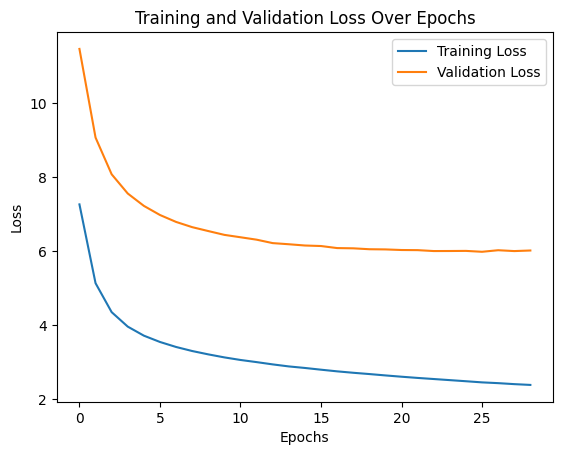

Training loss plot saved at /results/caption_model_training_plot.png
Training history saved at /results/caption_model_training_history.csv


In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint
import csv
import matplotlib.pyplot as plt

# Define checkpoint callback
checkpoint_cb = ModelCheckpoint(
    filepath=f'{tmpx}imgcap_{mdx}', 
    save_weights_only=True, 
    save_best_only=True,
    verbose=1
)

try:
    # Fit the model
    # Train the model and capture the history
    history = caption_model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=valid_dataset,
        callbacks=[early_stopping, checkpoint_cb],
    )

    # Save training history as a CSV
    csv_path = "/results/caption_model_training_history.csv"
    history_data = history.history
    with open(csv_path, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        # Write header
        writer.writerow(["epoch"] + list(history_data.keys()))
        # Write data
        for i in range(len(history_data["loss"])):
            writer.writerow([i + 1] + [history_data[key][i] for key in history_data.keys()])

    # Save and show the loss curves as a plot
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.title("Training and Validation Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plot_path = "/results/caption_model_training_plot.png"
    plt.savefig(plot_path)
    plt.show()
    plt.close()
    print(f"Training loss plot saved at {plot_path}")
    
    print(f"Training history saved at {csv_path}")
except ValueError as e:
    print(f"ValueError during model fitting: {e}")

Test image path.

In [28]:
# Main loop to process test images
dataset_directory = "/data/test/rxxch9vw59-2/"
test_image_filenames = os.listdir(dataset_directory+"images")

# Random Image Selection and Controlled Display

Generates a caption for a random image among test images.

In [29]:
random_image = np.random.choice(test_image_filenames)

Show Random Image and Caption Without Saving

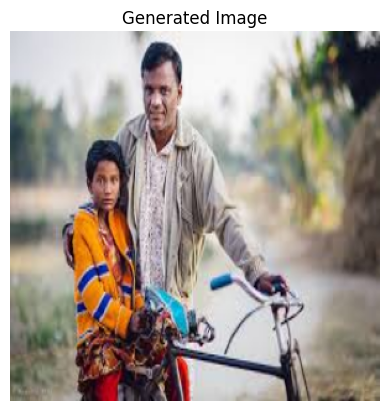


Predicted Caption:  একজন পুরুষ বসে আছে। একজন


'একজন পুরুষ বসে আছে। একজন'

In [30]:
# Generate and display the caption for the selected random image
# print(f"Generating caption for randomly selected image: {random_image}")
# caption = generate_caption(dataset_directory, random_image)

generate_caption(dataset_directory,'1228.png')

Display Only a Few Images Without Saving

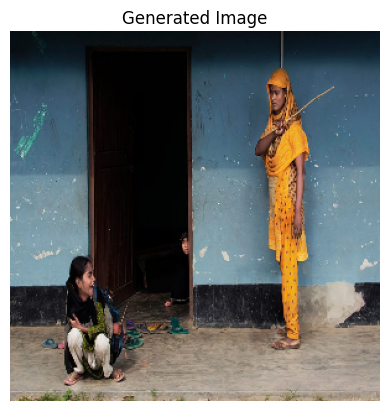


Predicted Caption:  একজন পুরুষ একটি শিশু কোলে নিয়ে আছে। একটি


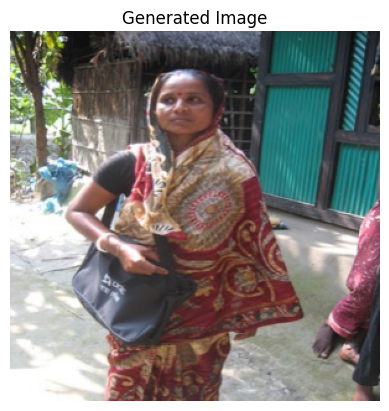


Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে। একজন


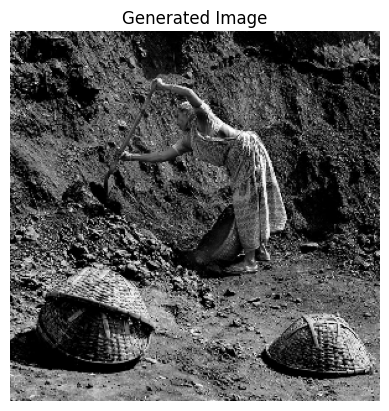


Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।


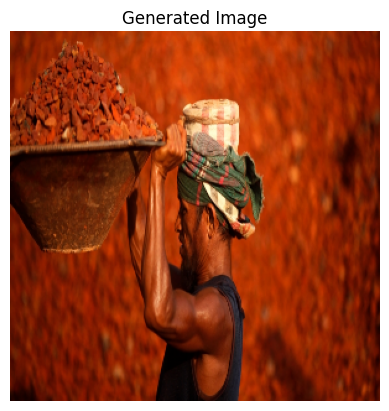


Predicted Caption:  একজন পুরুষ মাথায় টুপি পরে আছে। একজন মাথায়

Predicted Caption:  একজন নারী ও একজন পুরুষ বসে আছে।


In [31]:
# for idx, image_filename in enumerate(test_image_filenames[:5]):  # Process first 5 images
#     generate_caption(dataset_directory, image_filename, display_count=5)

# Generate captions for multiple random images


Generating caption for image 1: 1849.png


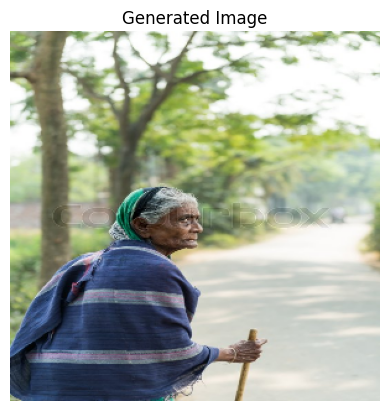


Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একজন
Generated Caption: একজন পুরুষ দাড়িয়ে আছে। একজন

Generating caption for image 2: 1775.png


2024-12-17 11:13:54.866394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


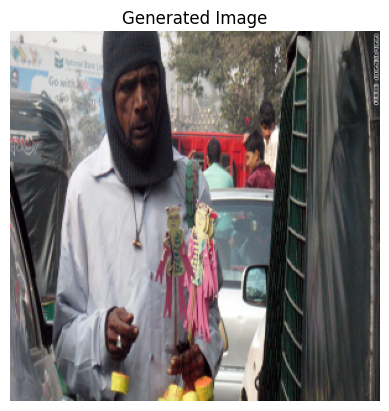


Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে। একজন
Generated Caption: একজন পুরুষ ও একজন নারী দাড়িয়ে আছে। একজন

Generating caption for image 3: 2190.png


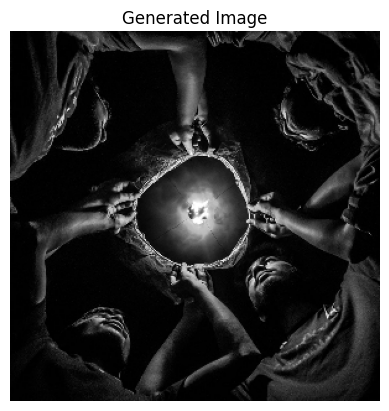


Predicted Caption:  একজন মানুষ আছে।
Generated Caption: একজন মানুষ আছে।

Generating caption for image 4: 203.png


2024-12-17 11:13:55.887459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


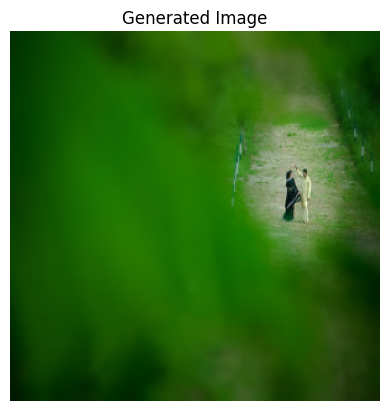


Predicted Caption:  একটি নৌকায় একজন মানুষ আছে।
Generated Caption: একটি নৌকায় একজন মানুষ আছে।

Generating caption for image 5: 1889.png


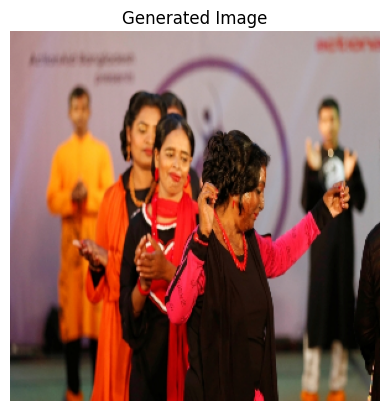


Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।
Generated Caption: একজন নারী ও একজন পুরুষ আছে।


In [32]:
# # Generate captions for 5 random test images
# num_random_images = 5

# for i in range(num_random_images):
#     random_image = np.random.choice(test_image_filenames)
#     print(f"\nGenerating caption for image {i + 1}: {random_image}")
#     caption = generate_caption(dataset_directory, random_image)
#     # print(f"Generated Caption: {caption}")


Generate captions for all test images.

In [33]:
for idx, image_filename in enumerate(test_image_filenames):
    generate_caption(dataset_directory, image_filename, save_dir=output_dir, save_idx=f"test_{idx+1}", display_count=5)

In [34]:
# Finalize and save HTML report
html_content += "</body></html>"
with open(html_report_path, "w", encoding="utf-8") as f:
    f.write(html_content)
print(f"HTML report saved at: {html_report_path}")

HTML report saved at: /results/generated_captions_report.html


Save the weights of the trained model.

In [35]:
# After training the model, save the weights
caption_model.save_weights(f'{tmpx}imgcap_{mdx}', save_format='tf')

Dump the vectorised vocabulary.

In [36]:
# Define the directory path
directory = f'/results/Vocab/{mdx}'

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)

# Save the vocabulary using pickle
with open(f'{directory}/vocab_{mdx}', 'wb') as f:
    pickle.dump(vocab, f)